MLND Capstone Development
=============

[Checkpoint Restart](#Checkpoint-Restart)

In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
from scipy.ndimage import imread
import pandas as pd
import seaborn as sns
import tests

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Data exploration
-------------

First, we need to download our dataset.

In [3]:
from urllib import urlretrieve
from os.path import isfile, isdir
from os import mkdir
from tqdm import tqdm
import tarfile

data_folder_path = 'data'
pascal_2007_foldername = 'pascal_2007'
pascal_2007_folderpath = "{}/{}".format(data_folder_path, pascal_2007_foldername)
pascal_2007_files = {'VOCtrainval_06-Nov-2007.tar': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
                     'VOCtest_06-Nov-2007.tar': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar',
                     'VOCdevkit_08-Jun-2007.tar': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCdevkit_08-Jun-2007.tar'}

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.updte((block_num - self.last_block) * block_size)
        self.last_block = block_num

# Create data director if it doesn't exist
if not isdir(data_folder_path):
    mkdir(data_folder_path)
    
# Create pascal_2007 data directory if it doesn't exist
if not isdir(pascal_2007_folderpath):
    mkdir(pascal_2007_folderpath)
        
# Download & extract data files
for filename, url in pascal_2007_files.iteritems():
    filepath = "./{}/{}".format(pascal_2007_folderpath, filename)
    
    if not isfile(filepath):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=filename) as pbar:
            urlretrieve(url, filepath, pbar.hook)

    # Extract data achrive files
    # Todo: Consider checking for already existing extractions, so we don't
    # have to re-extract the files.
    print "Extracting {}".format(filename)
    with tarfile.open(filepath) as tar:
        tar.extractall("{}/".format(pascal_2007_folderpath))
        tar.close()

print 'Testing...'
tests.test_pascal_2007_downloads()
tests.test_pascal_2007_extracts()

Extracting VOCdevkit_08-Jun-2007.tar
Extracting VOCtest_06-Nov-2007.tar
Extracting VOCtrainval_06-Nov-2007.tar
Testing...
PASCAL VOC 2007 data files downloaded.
PASCAL VOC 2007 data files extracted.


Now that we have the dataset downloaded and extracted. Let's take a look at some images and the corresponding annotations to get a better feel for what's in the dataset.

Inspecting image #000032...
Type: <type 'numpy.ndarray'>
Shape & type: (281, 500, 3) uint8
4 objects


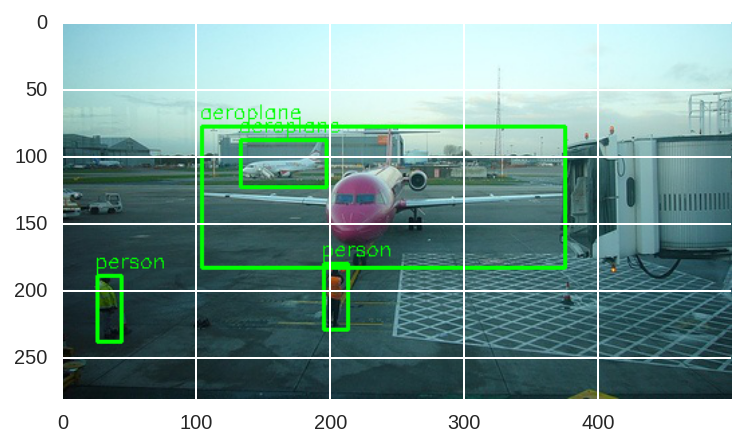

In [4]:
def load_image(image_id):
    example_image_path = '{}/VOCdevkit/VOC2007/JPEGImages/{}.jpg'.format(pascal_2007_folderpath, image_id)
    return imread(example_image_path)

def parse_annotations_for_image(image_id):
    example_image_annotations_path = '{}/VOCdevkit/VOC2007/Annotations/{}.xml'.format(pascal_2007_folderpath, image_id)
    tree = ET.parse(example_image_annotations_path)
    root = tree.getroot()
    
    image = {'width': int(root.find('size').find('width').text),
             'height': int(root.find('size').find('height').text),
             'depth': int(root.find('size').find('depth').text)}
    
    objects = []
    
    for obj in root.findall('object'):    
        object_class = obj.find('name').text
        difficult = obj.find('difficult').text == '1'
        pose = obj.find('pose').text
        truncated = obj.find('truncated').text == '1'
    
        xmin = int(obj.find('bndbox').find('xmin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        
        objects.append({'class': object_class, 
                        'difficult': difficult,
                        'pose': pose,
                        'truncated': truncated,
                        'xmin': xmin,
                        'xmax': xmax,
                        'ymin': ymin,
                        'ymax': ymax})
    
    return image, objects

def draw_bounding_boxes_on_image(image, objects):
    bounding_box_color = (0, 255, 0)
    
    for obj in objects:
        cv2.rectangle(image, (obj['xmin'], obj['ymin']), (obj['xmax'], obj['ymax']), bounding_box_color, 2)
        cv2.putText(image, obj['class'], (obj['xmin'] - 2, obj['ymin'] - 6), 0, 0.5, bounding_box_color)

def inspect_image(image_id):
    image = load_image(image_id)
    _, objects = parse_annotations_for_image(image_id)
    draw_bounding_boxes_on_image(image, objects)
    
    print 'Inspecting image #{}...'.format(image_id)
    print 'Type: {}'.format(type(image))
    print 'Shape & type: {} {}'.format(image.shape, image.dtype)
    print len(objects), 'objects'
    
    plt.imshow(image)
    
inspect_image('000032')

Now we have the ability to insepct an image with ground truth bounding boxes and object classifications overlaid. Next, we should inspect the overall dataset.

In [5]:
main_imageset_path = '{}/VOCdevkit/VOC2007/ImageSets/Main'.format(pascal_2007_folderpath)

pascal_voc_2007_detection_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
                                     'bottle', 'bus', 'car', 'cat', 'chair',
                                     'cow', 'diningtable', 'dog', 'horse',
                                     'motorbike', 'person', 'pottedplant',
                                     'sheep', 'sofa', 'train', 'tvmonitor']


def load_imageset(split):
    imageset = {}
    
    imageset['split'] = split
    imageset['image_ids'] = _load_imageset_image_ids(split)
    imageset['images'] = pd.DataFrame(columns=['image_id', 'width', 'height', 'depth'])
    imageset['objects'] = pd.DataFrame(columns=['image_id', 'class', 'pose', 'truncated', 'difficult', 
                                                'xmin', 'ymin', 'xmax', 'ymax'])
    _load_image_data(imageset)
    
    return imageset


def _load_imageset_image_ids(split):
    image_ids = []
    
    if split in ['train', 'val', 'trainval', 'test']:
        with open('{}/{}.txt'.format(main_imageset_path, split)) as f:
            image_ids = f.readlines()
    
        image_ids = [x.strip() for x in image_ids] 

    return image_ids


def _load_image_data(imageset):
    for image_id in imageset['image_ids']:
        image, objects = parse_annotations_for_image(image_id)
        
        imageset['images'] = imageset['images'].append({'image_id': image_id, 
                                   'width': image['width'],
                                   'height': image['height'],
                                   'depth': image['depth']
                                  }, ignore_index=True)
        
        for obj in objects:            
            imageset['objects'] = imageset['objects'].append({'image_id': image_id, 
                                        'class': obj['class'], 
                                        'pose': obj['pose'], 
                                        'truncated': obj['truncated'], 
                                        'difficult': obj['difficult'],         
                                        'xmin': obj['xmin'], 
                                        'ymin': obj['ymin'], 
                                        'xmax': obj['xmax'], 
                                        'ymax': obj['ymax']}, ignore_index=True)
    

def analyze_imageset(imageset):
    imageset['count'] = len(imageset['image_ids'])
        
    print len(imageset['images']), 'images'
    print len(imageset['objects']), 'objects'


print 'Loading train imageset...'
train_imageset = load_imageset('train')
analyze_imageset(train_imageset)

print ''
print 'Loading val imageset...'
val_imageset = load_imageset('val')
analyze_imageset(val_imageset)

Loading train imageset...
2501 images
7844 objects

Loading val imageset...
2510 images
7818 objects


In [6]:
print train_imageset['images'].head()
print train_imageset['objects'].head()

  image_id  width  height  depth
0   000012  500.0   333.0    3.0
1   000017  480.0   364.0    3.0
2   000023  334.0   500.0    3.0
3   000026  500.0   333.0    3.0
4   000032  500.0   281.0    3.0
  image_id    class         pose truncated difficult   xmin   ymin   xmax  \
0   000012      car         Rear     False     False  156.0   97.0  351.0   
1   000017   person         Left     False     False  185.0   62.0  279.0   
2   000017    horse         Left     False     False   90.0   78.0  403.0   
3   000023  bicycle  Unspecified      True     False    9.0  230.0  245.0   
4   000023  bicycle      Frontal      True     False  230.0  220.0  334.0   

    ymax  
0  270.0  
1  199.0  
2  336.0  
3  500.0  
4  500.0  


In [7]:
print 'Max train width: ', train_imageset['images']['width'].max()
print 'Min train width: ', train_imageset['images']['width'].min()

print 'Max train height: ', train_imageset['images']['height'].max()
print 'Min train height: ', train_imageset['images']['height'].min()

print 'Max train depth: ', train_imageset['images']['depth'].max()
print 'Min train depth: ', train_imageset['images']['depth'].min()

print ''

print 'Max val width: ', val_imageset['images']['width'].max()
print 'Min val width: ', val_imageset['images']['width'].min()

print 'Max val height: ', val_imageset['images']['height'].max()
print 'Min val height: ', val_imageset['images']['height'].min()

print 'Max val depth: ', val_imageset['images']['depth'].max()
print 'Min val depth: ', val_imageset['images']['depth'].min()

Max train width:  500.0
Min train width:  127.0
Max train height:  500.0
Min train height:  96.0
Max train depth:  3.0
Min train depth:  3.0

Max val width:  500.0
Min val width:  174.0
Max val height:  500.0
Min val height:  99.0
Max val depth:  3.0
Min val depth:  3.0


In [8]:
def difficult_percentage(df):
    return len(df[df.difficult]) / float(len(df)) * 100

print '{0:.2f}% difficult objects in train dataset'.format(difficult_percentage(train_imageset['objects']))
print '{0:.2f}% difficult objects in validation dataset'.format(difficult_percentage(val_imageset['objects']))

19.67% difficult objects in train dataset
19.33% difficult objects in validation dataset


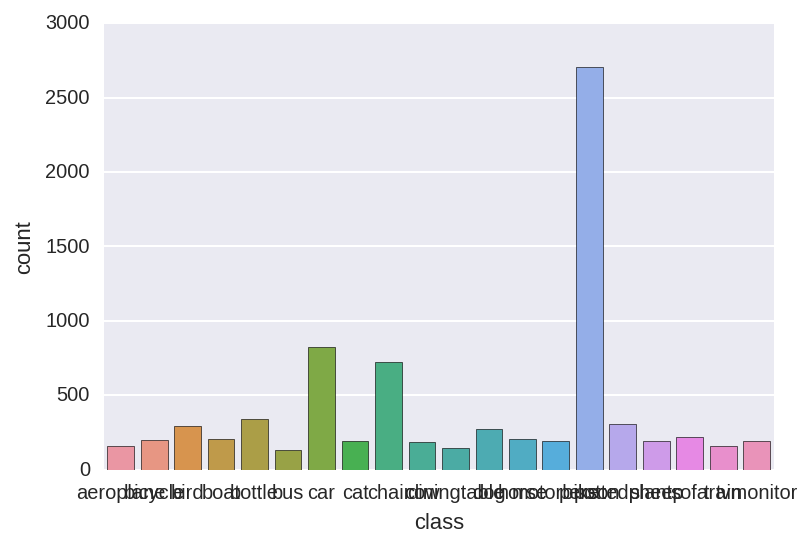

In [9]:
a = sns.countplot(x='class', data=train_imageset['objects'].sort_values(by='class'))

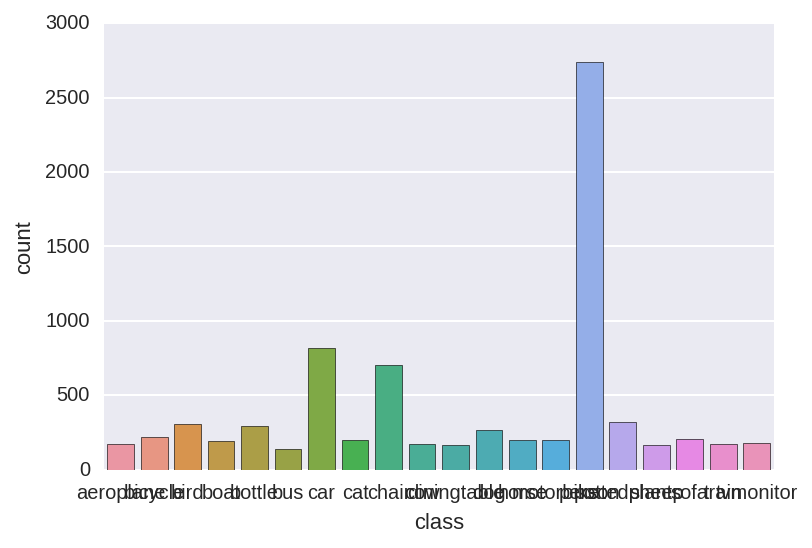

In [10]:
b = sns.countplot(x='class', data=val_imageset['objects'].sort_values(by='class'))

The PASCAL VOC 2007 dataset is already pre-split between train and validation sets, so we'll first see if we can use this. After the analysis, we can see that the split is about 50/50 in terms of number of images and objects. 

As we can see from the cursory analysis, all of the images are different sizes, but all are constrainted to be within a 500x500 square, presumably maintaining aspect ratio. Additionally, all images have a depth of 3, so we don't have to worry about correcting for any outliers in that regard.

Next, I looked at the percentage of objects that were identified as "difficult". Luckily, they are roughly equal, so we don't have to worry that one cut of the data is easier to detect objects than the other.

Finally, we inspected the class distribution within the set and compared the train and validation sets in this regard. It's not balanceda—there are significantly more person objects than anything else—but there is an even distribution between the training and validation sets, so while we should pay attention if our network is significantly better at detecting people, I think we can use this default splitting strategy for the project.

Checkpoint
--------

In [11]:
# Pickle the datasets
train_output = open('train_imageset.pkl', 'wb')
pickle.dump(train_imageset, train_output)
train_output.close()

val_output = open('val_imageset.pkl', 'wb')
pickle.dump(val_imageset, val_output)
val_output.close()

Checkpoint Restart
-----------------

The following is a network influenced by Ross Girshick's Faster-RCNN_TF implementation. I have rewritten it to be simpler and just focus on the PASCAL VOC 2007 dataset as well as to use the dataframe I used for dataset analysis and image preprocessing. It still depends on some general utility libraries, which I left unaltered in ./lib. 

In [1]:
# Add lib directory to path. There's probably a more elegant way to do this long term.
import sys
sys.path.insert(0, "./lib")

import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
from tensorflow.python.client import timeline
import pickle
import os
import os.path as osp
import time
import pprint
import PIL
import scipy.sparse
import cv2
import xml.etree.ElementTree as ET
import scipy.io as sio
import cPickle
import subprocess
import uuid
import pdb
import argparse
import heapq
import math
from distutils import spawn
from easydict import EasyDict as edict
import matplotlib.pyplot as plt

# from rpn_msr.generate import imdb_proposals_det

from utils.blob import prep_im_for_blob, im_list_to_blob
from utils.timer import Timer
from utils.cython_nms import nms, nms_new
# from utils.boxes_grid import get_boxes_grid
from utils.cython_bbox import bbox_overlaps
import utils.cython_bbox #still need or does the above import it?

# Reload the stored pickle file from the first checkpoint.
train_pkl_file = open('train_imageset.pkl', 'rb')
train_imageset = pickle.load(train_pkl_file)

val_pkl_file = open('val_imageset.pkl', 'rb')
val_imageset = pickle.load(val_pkl_file)

assert len(train_imageset['objects']), 7844
assert len(val_imageset['objects']), 7818

Preprocessing
------------

Now, we need to preprocess our data and save it before building our network

In [2]:
# Not sure if I should do this step first or as part of the batch processing

**Config**

In [3]:
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""Fast R-CNN config system.

This file specifies default config options for Fast R-CNN. You should not
change values in this file. Instead, you should write a config file (in yaml)
and use cfg_from_file(yaml_file) to load it and override the default options.

Most tools in $ROOT/tools take a --cfg option to specify an override file.
    - See tools/{train,test}_net.py for example code that uses cfg_from_file()
    - See experiments/cfgs/*.yml for example YAML config override files
"""



__C = edict()
# Consumers can get config by:
cfg = __C

#
# Training options
#

__C.TRAIN = edict()
#__C.NET_NAME = 'VGGnet'
# learning rate
__C.TRAIN.LEARNING_RATE = 0.001
__C.TRAIN.MOMENTUM = 0.9
__C.TRAIN.GAMMA = 0.1
__C.TRAIN.STEPSIZE = 50000
__C.TRAIN.DISPLAY = 10
__C.IS_MULTISCALE = False

# Scales to compute real features
#__C.TRAIN.SCALES_BASE = (0.25, 0.5, 1.0, 2.0, 3.0)
#__C.TRAIN.SCALES_BASE = (1.0,)

# parameters for ROI generating
#__C.TRAIN.SPATIAL_SCALE = 0.0625
#__C.TRAIN.KERNEL_SIZE = 5

# Aspect ratio to use during training
#__C.TRAIN.ASPECTS = (1, 0.75, 0.5, 0.25)
#__C.TRAIN.ASPECTS= (1,)


# Scales to use during training (can list multiple scales)
# Each scale is the pixel size of an image's shortest side
__C.TRAIN.SCALES = (600,)

# Max pixel size of the longest side of a scaled input image
__C.TRAIN.MAX_SIZE = 1000

# Images to use per minibatch
__C.TRAIN.IMS_PER_BATCH = 2

# Minibatch size (number of regions of interest [ROIs])
__C.TRAIN.BATCH_SIZE = 128

# Fraction of minibatch that is labeled foreground (i.e. class > 0)
__C.TRAIN.FG_FRACTION = 0.25

# Overlap threshold for a ROI to be considered foreground (if >= FG_THRESH)
__C.TRAIN.FG_THRESH = 0.5

# Overlap threshold for a ROI to be considered background (class = 0 if
# overlap in [LO, HI))
__C.TRAIN.BG_THRESH_HI = 0.5
__C.TRAIN.BG_THRESH_LO = 0.1

# Use horizontally-flipped images during training?
__C.TRAIN.USE_FLIPPED = True

# Train bounding-box regressors
__C.TRAIN.BBOX_REG = True

# Overlap required between a ROI and ground-truth box in order for that ROI to
# be used as a bounding-box regression training example
__C.TRAIN.BBOX_THRESH = 0.5

# Iterations between snapshots
__C.TRAIN.SNAPSHOT_ITERS = 5000

# solver.prototxt specifies the snapshot path prefix, this adds an optional
# infix to yield the path: <prefix>[_<infix>]_iters_XYZ.caffemodel
__C.TRAIN.SNAPSHOT_PREFIX = 'VGGnet_fast_rcnn'
__C.TRAIN.SNAPSHOT_INFIX = ''

# Use a prefetch thread in roi_data_layer.layer
# So far I haven't found this useful; likely more engineering work is required
__C.TRAIN.USE_PREFETCH = False

# Normalize the targets (subtract empirical mean, divide by empirical stddev)
__C.TRAIN.BBOX_NORMALIZE_TARGETS = True
# Deprecated (inside weights)
__C.TRAIN.BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)
# Normalize the targets using "precomputed" (or made up) means and stdevs
# (BBOX_NORMALIZE_TARGETS must also be True)
__C.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED = False
__C.TRAIN.BBOX_NORMALIZE_MEANS = (0.0, 0.0, 0.0, 0.0)
__C.TRAIN.BBOX_NORMALIZE_STDS = (0.1, 0.1, 0.2, 0.2)

# Train using these proposals
__C.TRAIN.PROPOSAL_METHOD = 'selective_search'

# Make minibatches from images that have similar aspect ratios (i.e. both
# tall and thin or both short and wide) in order to avoid wasting computation
# on zero-padding.
__C.TRAIN.ASPECT_GROUPING = True

# Use RPN to detect objects
__C.TRAIN.HAS_RPN = False
# IOU >= thresh: positive example
__C.TRAIN.RPN_POSITIVE_OVERLAP = 0.7
# IOU < thresh: negative example
__C.TRAIN.RPN_NEGATIVE_OVERLAP = 0.3
# If an anchor statisfied by positive and negative conditions set to negative
__C.TRAIN.RPN_CLOBBER_POSITIVES = False
# Max number of foreground examples
__C.TRAIN.RPN_FG_FRACTION = 0.5
# Total number of examples
__C.TRAIN.RPN_BATCHSIZE = 256
# NMS threshold used on RPN proposals
__C.TRAIN.RPN_NMS_THRESH = 0.7
# Number of top scoring boxes to keep before apply NMS to RPN proposals
__C.TRAIN.RPN_PRE_NMS_TOP_N = 12000
# Number of top scoring boxes to keep after applying NMS to RPN proposals
__C.TRAIN.RPN_POST_NMS_TOP_N = 2000
# Proposal height and width both need to be greater than RPN_MIN_SIZE (at orig image scale)
__C.TRAIN.RPN_MIN_SIZE = 16
# Deprecated (outside weights)
__C.TRAIN.RPN_BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)
# Give the positive RPN examples weight of p * 1 / {num positives}
# and give negatives a weight of (1 - p)
# Set to -1.0 to use uniform example weighting
__C.TRAIN.RPN_POSITIVE_WEIGHT = -1.0

# Enable timeline generation
__C.TRAIN.DEBUG_TIMELINE = False

#
# Testing options
#

__C.TEST = edict()

# Scales to use during testing (can list multiple scales)
# Each scale is the pixel size of an image's shortest side
__C.TEST.SCALES = (600,)

# Max pixel size of the longest side of a scaled input image
__C.TEST.MAX_SIZE = 1000

# Overlap threshold used for non-maximum suppression (suppress boxes with
# IoU >= this threshold)
__C.TEST.NMS = 0.3

# Experimental: treat the (K+1) units in the cls_score layer as linear
# predictors (trained, eg, with one-vs-rest SVMs).
__C.TEST.SVM = False

# Test using bounding-box regressors
__C.TEST.BBOX_REG = True

# Propose boxes
__C.TEST.HAS_RPN = True

# Test using these proposals
__C.TEST.PROPOSAL_METHOD = 'selective_search'

## NMS threshold used on RPN proposals
__C.TEST.RPN_NMS_THRESH = 0.7
## Number of top scoring boxes to keep before apply NMS to RPN proposals
__C.TEST.RPN_PRE_NMS_TOP_N = 6000
#__C.TEST.RPN_PRE_NMS_TOP_N = 12000
## Number of top scoring boxes to keep after applying NMS to RPN proposals
__C.TEST.RPN_POST_NMS_TOP_N = 300
#__C.TEST.RPN_POST_NMS_TOP_N = 2000
# Proposal height and width both need to be greater than RPN_MIN_SIZE (at orig image scale)
__C.TEST.RPN_MIN_SIZE = 16

# Enable timeline generation
__C.TEST.DEBUG_TIMELINE = False

#
# MISC
#

# The mapping from image coordinates to feature map coordinates might cause
# some boxes that are distinct in image space to become identical in feature
# coordinates. If DEDUP_BOXES > 0, then DEDUP_BOXES is used as the scale factor
# for identifying duplicate boxes.
# 1/16 is correct for {Alex,Caffe}Net, VGG_CNN_M_1024, and VGG16
__C.DEDUP_BOXES = 1./16.

# Pixel mean values (BGR order) as a (1, 1, 3) array
# We use the same pixel mean for all networks even though it's not exactly what
# they were trained with
__C.PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])

# For reproducibility
__C.RNG_SEED = 3

# A small number that's used many times
__C.EPS = 1e-14

# Root directory of project
# __C.ROOT_DIR = osp.abspath(osp.join(osp.dirname(__file__), '..', '..'))
__C.ROOT_DIR = osp.abspath('.')

# Data directory
__C.DATA_DIR = osp.abspath(osp.join(__C.ROOT_DIR, 'data'))

# Model directory
__C.MODELS_DIR = osp.abspath(osp.join(__C.ROOT_DIR, 'models', 'pascal_voc'))

# Name (or path to) the matlab executable
__C.MATLAB = 'matlab'

# Place outputs under an experiments directory
__C.EXP_DIR = 'default'


if spawn.find_executable("nvcc"):
    # Use GPU implementation of non-maximum suppression
    __C.USE_GPU_NMS = True

    # Default GPU device id
    __C.GPU_ID = 0
else:
    __C.USE_GPU_NMS = False


def get_output_dir(imdb, weights_filename):
    """Return the directory where experimental artifacts are placed.
    If the directory does not exist, it is created.

    A canonical path is built using the name from an imdb and a network
    (if not None).
    """
    outdir = osp.abspath(osp.join(__C.ROOT_DIR, 'output', __C.EXP_DIR, imdb.name))
    if weights_filename is not None:
        outdir = osp.join(outdir, weights_filename)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    return outdir

def _merge_a_into_b(a, b):
    """Merge config dictionary a into config dictionary b, clobbering the
    options in b whenever they are also specified in a.
    """
    if type(a) is not edict:
        return

    for k, v in a.iteritems():
        # a must specify keys that are in b
        if not b.has_key(k):
            raise KeyError('{} is not a valid config key'.format(k))

        # the types must match, too
        old_type = type(b[k])
        if old_type is not type(v):
            if isinstance(b[k], np.ndarray):
                v = np.array(v, dtype=b[k].dtype)
            else:
                raise ValueError(('Type mismatch ({} vs. {}) '
                                'for config key: {}').format(type(b[k]),
                                                            type(v), k))

        # recursively merge dicts
        if type(v) is edict:
            try:
                _merge_a_into_b(a[k], b[k])
            except:
                print('Error under config key: {}'.format(k))
                raise
        else:
            b[k] = v


**IMDB**

In [4]:
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------


class imdb(object):
    """Image database."""

    def __init__(self, name):
        self._name = name
        self._num_classes = 0
        self._classes = []
        self._image_index = []
        self._obj_proposer = 'selective_search'
        self._roidb = None
        print self.default_roidb
        self._roidb_handler = self.default_roidb
        # Use this dict for storing dataset specific config options
        self.config = {}

    @property
    def name(self):
        return self._name

    @property
    def num_classes(self):
        return len(self._classes)

    @property
    def classes(self):
        return self._classes

    @property
    def image_index(self):
        return self._image_index

    @property
    def roidb_handler(self):
        return self._roidb_handler

    @roidb_handler.setter
    def roidb_handler(self, val):
        self._roidb_handler = val

    def set_proposal_method(self, method):
        method = eval('self.' + method + '_roidb')
        self.roidb_handler = method

    @property
    def roidb(self):
        # A roidb is a list of dictionaries, each with the following keys:
        #   boxes
        #   gt_overlaps
        #   gt_classes
        #   flipped
        if self._roidb is not None:
            return self._roidb
        self._roidb = self.roidb_handler()
        return self._roidb

    @property
    def cache_path(self):
        cache_path = osp.abspath(osp.join(cfg.DATA_DIR, 'cache'))
        if not os.path.exists(cache_path):
            os.makedirs(cache_path)
        return cache_path

    @property
    def num_images(self):
      return len(self.image_index)

    def image_path_at(self, i):
        raise NotImplementedError

    def default_roidb(self):
        raise NotImplementedError

    def evaluate_detections(self, all_boxes, output_dir=None):
        """
        all_boxes is a list of length number-of-classes.
        Each list element is a list of length number-of-images.
        Each of those list elements is either an empty list []
        or a numpy array of detection.

        all_boxes[class][image] = [] or np.array of shape #dets x 5
        """
        raise NotImplementedError

    def _get_widths(self):
      return [PIL.Image.open(self.image_path_at(i)).size[0]
              for i in xrange(self.num_images)]

    def append_flipped_images(self):
        num_images = self.num_images
        widths = self._get_widths()
        for i in xrange(num_images):
            boxes = self.roidb[i]['boxes'].copy()
            oldx1 = boxes[:, 0].copy()
            oldx2 = boxes[:, 2].copy()
            boxes[:, 0] = widths[i] - oldx2 - 1
            boxes[:, 2] = widths[i] - oldx1 - 1
            assert (boxes[:, 2] >= boxes[:, 0]).all()
            entry = {'boxes' : boxes,
                     'gt_overlaps' : self.roidb[i]['gt_overlaps'],
                     'gt_classes' : self.roidb[i]['gt_classes'],
                     'flipped' : True}
            self.roidb.append(entry)
        self._image_index = self._image_index * 2

    def evaluate_recall(self, candidate_boxes=None, thresholds=None,
                        area='all', limit=None):
        """Evaluate detection proposal recall metrics.

        Returns:
            results: dictionary of results with keys
                'ar': average recall
                'recalls': vector recalls at each IoU overlap threshold
                'thresholds': vector of IoU overlap thresholds
                'gt_overlaps': vector of all ground-truth overlaps
        """
        # Record max overlap value for each gt box
        # Return vector of overlap values
        areas = { 'all': 0, 'small': 1, 'medium': 2, 'large': 3,
                  '96-128': 4, '128-256': 5, '256-512': 6, '512-inf': 7}
        area_ranges = [ [0**2, 1e5**2],    # all
                        [0**2, 32**2],     # small
                        [32**2, 96**2],    # medium
                        [96**2, 1e5**2],   # large
                        [96**2, 128**2],   # 96-128
                        [128**2, 256**2],  # 128-256
                        [256**2, 512**2],  # 256-512
                        [512**2, 1e5**2],  # 512-inf
                      ]
        assert areas.has_key(area), 'unknown area range: {}'.format(area)
        area_range = area_ranges[areas[area]]
        gt_overlaps = np.zeros(0)
        num_pos = 0
        for i in xrange(self.num_images):
            # Checking for max_overlaps == 1 avoids including crowd annotations
            # (...pretty hacking :/)
            max_gt_overlaps = self.roidb[i]['gt_overlaps'].toarray().max(axis=1)
            gt_inds = np.where((self.roidb[i]['gt_classes'] > 0) &
                               (max_gt_overlaps == 1))[0]
            gt_boxes = self.roidb[i]['boxes'][gt_inds, :]
            gt_areas = self.roidb[i]['seg_areas'][gt_inds]
            valid_gt_inds = np.where((gt_areas >= area_range[0]) &
                                     (gt_areas <= area_range[1]))[0]
            gt_boxes = gt_boxes[valid_gt_inds, :]
            num_pos += len(valid_gt_inds)

            if candidate_boxes is None:
                # If candidate_boxes is not supplied, the default is to use the
                # non-ground-truth boxes from this roidb
                non_gt_inds = np.where(self.roidb[i]['gt_classes'] == 0)[0]
                boxes = self.roidb[i]['boxes'][non_gt_inds, :]
            else:
                boxes = candidate_boxes[i]
            if boxes.shape[0] == 0:
                continue
            if limit is not None and boxes.shape[0] > limit:
                boxes = boxes[:limit, :]

            overlaps = bbox_overlaps(boxes.astype(np.float),
                                     gt_boxes.astype(np.float))

            _gt_overlaps = np.zeros((gt_boxes.shape[0]))
            for j in xrange(gt_boxes.shape[0]):
                # find which proposal box maximally covers each gt box
                argmax_overlaps = overlaps.argmax(axis=0)
                # and get the iou amount of coverage for each gt box
                max_overlaps = overlaps.max(axis=0)
                # find which gt box is 'best' covered (i.e. 'best' = most iou)
                gt_ind = max_overlaps.argmax()
                gt_ovr = max_overlaps.max()
                assert(gt_ovr >= 0)
                # find the proposal box that covers the best covered gt box
                box_ind = argmax_overlaps[gt_ind]
                # record the iou coverage of this gt box
                _gt_overlaps[j] = overlaps[box_ind, gt_ind]
                assert(_gt_overlaps[j] == gt_ovr)
                # mark the proposal box and the gt box as used
                overlaps[box_ind, :] = -1
                overlaps[:, gt_ind] = -1
            # append recorded iou coverage level
            gt_overlaps = np.hstack((gt_overlaps, _gt_overlaps))

        gt_overlaps = np.sort(gt_overlaps)
        if thresholds is None:
            step = 0.05
            thresholds = np.arange(0.5, 0.95 + 1e-5, step)
        recalls = np.zeros_like(thresholds)
        # compute recall for each iou threshold
        for i, t in enumerate(thresholds):
            recalls[i] = (gt_overlaps >= t).sum() / float(num_pos)
        # ar = 2 * np.trapz(recalls, thresholds)
        ar = recalls.mean()
        return {'ar': ar, 'recalls': recalls, 'thresholds': thresholds,
                'gt_overlaps': gt_overlaps}

    def create_roidb_from_box_list(self, box_list, gt_roidb):
        assert len(box_list) == self.num_images, \
                'Number of boxes must match number of ground-truth images'
        roidb = []
        for i in xrange(self.num_images):
            boxes = box_list[i]
            num_boxes = boxes.shape[0]
            overlaps = np.zeros((num_boxes, self.num_classes), dtype=np.float32)

            if gt_roidb is not None and gt_roidb[i]['boxes'].size > 0:
                gt_boxes = gt_roidb[i]['boxes']
                gt_classes = gt_roidb[i]['gt_classes']
                gt_overlaps = bbox_overlaps(boxes.astype(np.float),
                                            gt_boxes.astype(np.float))
                argmaxes = gt_overlaps.argmax(axis=1)
                maxes = gt_overlaps.max(axis=1)
                I = np.where(maxes > 0)[0]
                overlaps[I, gt_classes[argmaxes[I]]] = maxes[I]

            overlaps = scipy.sparse.csr_matrix(overlaps)
            roidb.append({
                'boxes' : boxes,
                'gt_classes' : np.zeros((num_boxes,), dtype=np.int32),
                'gt_overlaps' : overlaps,
                'flipped' : False,
                'seg_areas' : np.zeros((num_boxes,), dtype=np.float32),
            })
        return roidb

    @staticmethod
    def merge_roidbs(a, b):
        assert len(a) == len(b)
        for i in xrange(len(a)):
            a[i]['boxes'] = np.vstack((a[i]['boxes'], b[i]['boxes']))
            a[i]['gt_classes'] = np.hstack((a[i]['gt_classes'],
                                            b[i]['gt_classes']))
            a[i]['gt_overlaps'] = scipy.sparse.vstack([a[i]['gt_overlaps'],
                                                       b[i]['gt_overlaps']])
            a[i]['seg_areas'] = np.hstack((a[i]['seg_areas'],
                                           b[i]['seg_areas']))
        return a

    def competition_mode(self, on):
        """Turn competition mode on or off."""
        pass


**PASCAL_VOC**

In [5]:
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                              int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text),
                              int(bbox.find('ymax').text)]
        objects.append(obj_struct)

    return objects

def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
    """rec, prec, ap = voc_eval(detpath,
                                annopath,
                                imagesetfile,
                                classname,
                                [ovthresh],
                                [use_07_metric])

    Top level function that does the PASCAL VOC evaluation.

    detpath: Path to detections
        detpath.format(classname) should produce the detection results file.
    annopath: Path to annotations
        annopath.format(imagename) should be the xml annotations file.
    imagesetfile: Text file containing the list of images, one image per line.
    classname: Category name (duh)
    cachedir: Directory for caching the annotations
    [ovthresh]: Overlap threshold (default = 0.5)
    [use_07_metric]: Whether to use VOC07's 11 point AP computation
        (default False)
    """
    # assumes detections are in detpath.format(classname)
    # assumes annotations are in annopath.format(imagename)
    # assumes imagesetfile is a text file with each line an image name
    # cachedir caches the annotations in a pickle file

    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    # read list of images
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip() for x in lines]

    if not os.path.isfile(cachefile):
        # load annots
        recs = {}
        for i, imagename in enumerate(imagenames):
            recs[imagename] = parse_rec(annopath.format(imagename))
            if i % 100 == 0:
                print 'Reading annotation for {:d}/{:d}'.format(
                    i + 1, len(imagenames))
        # save
        print 'Saving cached annotations to {:s}'.format(cachefile)
        with open(cachefile, 'w') as f:
            cPickle.dump(recs, f)
    else:
        # load
        with open(cachefile, 'r') as f:
            recs = cPickle.load(f)

    # extract gt objects for this class
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename] = {'bbox': bbox,
                                 'difficult': difficult,
                                 'det': det}

    # read dets
    detfile = detpath.format(classname)
    with open(detfile, 'r') as f:
        lines = f.readlines()
    if any(lines) == 1:

        splitlines = [x.strip().split(' ') for x in lines]
        image_ids = [x[0] for x in splitlines]
        confidence = np.array([float(x[1]) for x in splitlines])
        BB = np.array([[float(z) for z in x[2:]] for x in splitlines])

        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d in range(nd):
            R = class_recs[image_ids[d]]
            bb = BB[d, :].astype(float)
            ovmax = -np.inf
            BBGT = R['bbox'].astype(float)

            if BBGT.size > 0:
                # compute overlaps
                # intersection
                ixmin = np.maximum(BBGT[:, 0], bb[0])
                iymin = np.maximum(BBGT[:, 1], bb[1])
                ixmax = np.minimum(BBGT[:, 2], bb[2])
                iymax = np.minimum(BBGT[:, 3], bb[3])
                iw = np.maximum(ixmax - ixmin + 1., 0.)
                ih = np.maximum(iymax - iymin + 1., 0.)
                inters = iw * ih

                # union
                uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                       (BBGT[:, 2] - BBGT[:, 0] + 1.) *
                       (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

                overlaps = inters / uni
                ovmax = np.max(overlaps)
                jmax = np.argmax(overlaps)

            if ovmax > ovthresh:
                if not R['difficult'][jmax]:
                    if not R['det'][jmax]:
                        tp[d] = 1.
                        R['det'][jmax] = 1
                    else:
                        fp[d] = 1.
            else:
                fp[d] = 1.

        # compute precision recall
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        # ground truth
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
        ap = voc_ap(rec, prec, use_07_metric)
    else:
         rec = -1
         prec = -1
         ap = -1

    return rec, prec, ap



class pascal_voc(imdb):
    def __init__(self, image_set, year, devkit_path=None):
        imdb.__init__(self, 'voc_' + year + '_' + image_set)
        self._year = year
        self._image_set = image_set
        self._devkit_path = self._get_default_path() if devkit_path is None \
                            else devkit_path
        self._data_path = os.path.join(self._devkit_path, 'VOC' + self._year)
        self._classes = ('__background__', # always index 0
                         'aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor')
        self._class_to_ind = dict(zip(self.classes, xrange(self.num_classes)))
        self._image_ext = '.jpg'
        self._image_index = self._load_image_set_index()
        # Default to roidb handler
        #self._roidb_handler = self.selective_search_roidb
        self._roidb_handler = self.gt_roidb
        self._salt = str(uuid.uuid4())
        self._comp_id = 'comp4'

        # PASCAL specific config options
        self.config = {'cleanup'     : True,
                       'use_salt'    : True,
                       'use_diff'    : False,
                       'matlab_eval' : False,
                       'rpn_file'    : None,
                       'min_size'    : 2}

        assert os.path.exists(self._devkit_path), \
                'VOCdevkit path does not exist: {}'.format(self._devkit_path)
        assert os.path.exists(self._data_path), \
                'Path does not exist: {}'.format(self._data_path)

    def image_path_at(self, i):
        """
        Return the absolute path to image i in the image sequence.
        """
        return self.image_path_from_index(self._image_index[i])

    def image_path_from_index(self, index):
        """
        Construct an image path from the image's "index" identifier.
        """
        image_path = os.path.join(self._data_path, 'JPEGImages',
                                  index + self._image_ext)
        assert os.path.exists(image_path), \
                'Path does not exist: {}'.format(image_path)
        return image_path

    def _load_image_set_index(self):
        """
        Load the indexes listed in this dataset's image set file.
        """
        # Example path to image set file:
        # self._devkit_path + /VOCdevkit2007/VOC2007/ImageSets/Main/val.txt
        image_set_file = os.path.join(self._data_path, 'ImageSets', 'Main',
                                      self._image_set + '.txt')
        assert os.path.exists(image_set_file), \
                'Path does not exist: {}'.format(image_set_file)
        with open(image_set_file) as f:
            image_index = [x.strip() for x in f.readlines()]
        return image_index

    def _get_default_path(self):
        """
        Return the default path where PASCAL VOC is expected to be installed.
        """
        return os.path.join(cfg.DATA_DIR, 'pascal_' + self._year, 'VOCdevkit')

    def gt_roidb(self):
        """
        Return the database of ground-truth regions of interest.

        This function loads/saves from/to a cache file to speed up future calls.
        """
        cache_file = os.path.join(self.cache_path, self.name + '_gt_roidb.pkl')
        if os.path.exists(cache_file):
            with open(cache_file, 'rb') as fid:
                roidb = cPickle.load(fid)
            print '{} gt roidb loaded from {}'.format(self.name, cache_file)
            return roidb

        gt_roidb = [self._load_pascal_annotation(index)
                    for index in self.image_index]
        with open(cache_file, 'wb') as fid:
            cPickle.dump(gt_roidb, fid, cPickle.HIGHEST_PROTOCOL)
        print 'wrote gt roidb to {}'.format(cache_file)

        return gt_roidb

# -

    def rpn_roidb(self):
        if int(self._year) == 2007 or self._image_set != 'test':
            gt_roidb = self.gt_roidb()
            rpn_roidb = self._load_rpn_roidb(gt_roidb)
            roidb = imdb.merge_roidbs(gt_roidb, rpn_roidb)
        else:
            roidb = self._load_rpn_roidb(None)

        return roidb

    def _load_rpn_roidb(self, gt_roidb):
        filename = self.config['rpn_file']
        print 'loading {}'.format(filename)
        assert os.path.exists(filename), \
               'rpn data not found at: {}'.format(filename)
        with open(filename, 'rb') as f:
            box_list = cPickle.load(f)
        return self.create_roidb_from_box_list(box_list, gt_roidb)

#     def _load_selective_search_roidb(self, gt_roidb):
#         filename = os.path.abspath(os.path.join(cfg.DATA_DIR,
#                                                 'selective_search_data',
#                                                 self.name + '.mat'))
#         assert os.path.exists(filename), \
#                'Selective search data not found at: {}'.format(filename)
#         raw_data = sio.loadmat(filename)['boxes'].ravel()

#         box_list = []
#         for i in xrange(raw_data.shape[0]):
#             boxes = raw_data[i][:, (1, 0, 3, 2)] - 1
#             keep = ds_utils.unique_boxes(boxes)
#             boxes = boxes[keep, :]
#             keep = ds_utils.filter_small_boxes(boxes, self.config['min_size'])
#             boxes = boxes[keep, :]
#             box_list.append(boxes)

#         return self.create_roidb_from_box_list(box_list, gt_roidb)

    def _load_pascal_annotation(self, index):
        """
        Load image and bounding boxes info from XML file in the PASCAL VOC
        format.
        """
        filename = os.path.join(self._data_path, 'Annotations', index + '.xml')
        tree = ET.parse(filename)
        objs = tree.findall('object')
        if not self.config['use_diff']:
            # Exclude the samples labeled as difficult
            non_diff_objs = [
                obj for obj in objs if int(obj.find('difficult').text) == 0]
            # if len(non_diff_objs) != len(objs):
            #     print 'Removed {} difficult objects'.format(
            #         len(objs) - len(non_diff_objs))
            objs = non_diff_objs
        num_objs = len(objs)

        boxes = np.zeros((num_objs, 4), dtype=np.uint16)
        gt_classes = np.zeros((num_objs), dtype=np.int32)
        overlaps = np.zeros((num_objs, self.num_classes), dtype=np.float32)
        # "Seg" area for pascal is just the box area
        seg_areas = np.zeros((num_objs), dtype=np.float32)

        # Load object bounding boxes into a data frame.
        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox')
            # Make pixel indexes 0-based
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1
            cls = self._class_to_ind[obj.find('name').text.lower().strip()]
            boxes[ix, :] = [x1, y1, x2, y2]
            gt_classes[ix] = cls
            overlaps[ix, cls] = 1.0
            seg_areas[ix] = (x2 - x1 + 1) * (y2 - y1 + 1)

        overlaps = scipy.sparse.csr_matrix(overlaps)

        return {'boxes' : boxes,
                'gt_classes': gt_classes,
                'gt_overlaps' : overlaps,
                'flipped' : False,
                'seg_areas' : seg_areas}

    def _get_comp_id(self):
        comp_id = (self._comp_id + '_' + self._salt if self.config['use_salt']
            else self._comp_id)
        return comp_id

    def _get_voc_results_file_template(self):
        # VOCdevkit/results/VOC2007/Main/<comp_id>_det_test_aeroplane.txt
        filename = self._get_comp_id() + '_det_' + self._image_set + '_{:s}.txt'
        path = os.path.join(
            self._devkit_path,
            'results',
            'VOC' + self._year,
            'Main',
            filename)
        return path

    def _write_voc_results_file(self, all_boxes):
        for cls_ind, cls in enumerate(self.classes):
            if cls == '__background__':
                continue
            print 'Writing {} VOC results file'.format(cls)
            filename = self._get_voc_results_file_template().format(cls)
            with open(filename, 'wt') as f:
                for im_ind, index in enumerate(self.image_index):
                    dets = all_boxes[cls_ind][im_ind]
                    if dets == []:
                        continue
                    # the VOCdevkit expects 1-based indices
                    for k in xrange(dets.shape[0]):
                        f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                                format(index, dets[k, -1],
                                       dets[k, 0] + 1, dets[k, 1] + 1,
                                       dets[k, 2] + 1, dets[k, 3] + 1))

    def _do_python_eval(self, output_dir = 'output'):
        annopath = os.path.join(
            self._devkit_path,
            'VOC' + self._year,
            'Annotations',
            '{:s}.xml')
        imagesetfile = os.path.join(
            self._devkit_path,
            'VOC' + self._year,
            'ImageSets',
            'Main',
            self._image_set + '.txt')
        cachedir = os.path.join(self._devkit_path, 'annotations_cache')
        aps = []
        # The PASCAL VOC metric changed in 2010
        use_07_metric = True if int(self._year) < 2010 else False
        print 'VOC07 metric? ' + ('Yes' if use_07_metric else 'No')
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)
        for i, cls in enumerate(self._classes):
            if cls == '__background__':
                continue
            filename = self._get_voc_results_file_template().format(cls)
            rec, prec, ap = voc_eval(
                filename, annopath, imagesetfile, cls, cachedir, ovthresh=0.5,
                use_07_metric=use_07_metric)
            aps += [ap]
            print('AP for {} = {:.4f}'.format(cls, ap))
            with open(os.path.join(output_dir, cls + '_pr.pkl'), 'w') as f:
                cPickle.dump({'rec': rec, 'prec': prec, 'ap': ap}, f)
        print('Mean AP = {:.4f}'.format(np.mean(aps)))
        print('~~~~~~~~')
        print('Results:')
        for ap in aps:
            print('{:.3f}'.format(ap))
        print('{:.3f}'.format(np.mean(aps)))
        print('~~~~~~~~')
        print('')
        print('--------------------------------------------------------------')
        print('Results computed with the **unofficial** Python eval code.')
        print('Results should be very close to the official MATLAB eval code.')
        print('Recompute with `./tools/reval.py --matlab ...` for your paper.')
        print('-- Thanks, The Management')
        print('--------------------------------------------------------------')

    def _do_matlab_eval(self, output_dir='output'):
        print '-----------------------------------------------------'
        print 'Computing results with the official MATLAB eval code.'
        print '-----------------------------------------------------'
        path = os.path.join(cfg.ROOT_DIR, 'lib', 'datasets',
                            'VOCdevkit-matlab-wrapper')
        cmd = 'cd {} && '.format(path)
        cmd += '{:s} -nodisplay -nodesktop '.format(cfg.MATLAB)
        cmd += '-r "dbstop if error; '
        cmd += 'voc_eval(\'{:s}\',\'{:s}\',\'{:s}\',\'{:s}\'); quit;"' \
               .format(self._devkit_path, self._get_comp_id(),
                       self._image_set, output_dir)
        print('Running:\n{}'.format(cmd))
        status = subprocess.call(cmd, shell=True)

    def evaluate_detections(self, all_boxes, output_dir):
        self._write_voc_results_file(all_boxes)
        self._do_python_eval(output_dir)
        if self.config['matlab_eval']:
            self._do_matlab_eval(output_dir)
        if self.config['cleanup']:
            for cls in self._classes:
                if cls == '__background__':
                    continue
                filename = self._get_voc_results_file_template().format(cls)
                os.remove(filename)

    def competition_mode(self, on):
        if on:
            self.config['use_salt'] = False
            self.config['cleanup'] = False
        else:
            self.config['use_salt'] = True
            self.config['cleanup'] = True

**ROIDB**

In [6]:
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------


def bbox_transform(ex_rois, gt_rois):
    ex_widths = ex_rois[:, 2] - ex_rois[:, 0] + 1.0
    ex_heights = ex_rois[:, 3] - ex_rois[:, 1] + 1.0
    ex_ctr_x = ex_rois[:, 0] + 0.5 * ex_widths
    ex_ctr_y = ex_rois[:, 1] + 0.5 * ex_heights

    gt_widths = gt_rois[:, 2] - gt_rois[:, 0] + 1.0
    gt_heights = gt_rois[:, 3] - gt_rois[:, 1] + 1.0
    gt_ctr_x = gt_rois[:, 0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[:, 1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = np.log(gt_widths / ex_widths)
    targets_dh = np.log(gt_heights / ex_heights)

    targets = np.vstack(
        (targets_dx, targets_dy, targets_dw, targets_dh)).transpose()
    return targets

def bbox_transform_inv(boxes, deltas):
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)

    boxes = boxes.astype(deltas.dtype, copy=False)

    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]

    pred_ctr_x = dx * widths[:, np.newaxis] + ctr_x[:, np.newaxis]
    pred_ctr_y = dy * heights[:, np.newaxis] + ctr_y[:, np.newaxis]
    pred_w = np.exp(dw) * widths[:, np.newaxis]
    pred_h = np.exp(dh) * heights[:, np.newaxis]

    pred_boxes = np.zeros(deltas.shape, dtype=deltas.dtype)
    # x1
    pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
    # y1
    pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
    # x2
    pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
    # y2
    pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h

    return pred_boxes

def clip_boxes(boxes, im_shape):
    """
    Clip boxes to image boundaries.
    """

    # x1 >= 0
    boxes[:, 0::4] = np.maximum(np.minimum(boxes[:, 0::4], im_shape[1] - 1), 0)
    # y1 >= 0
    boxes[:, 1::4] = np.maximum(np.minimum(boxes[:, 1::4], im_shape[0] - 1), 0)
    # x2 < im_shape[1]
    boxes[:, 2::4] = np.maximum(np.minimum(boxes[:, 2::4], im_shape[1] - 1), 0)
    # y2 < im_shape[0]
    boxes[:, 3::4] = np.maximum(np.minimum(boxes[:, 3::4], im_shape[0] - 1), 0)
    return boxes



"""Transform a roidb into a trainable roidb by adding a bunch of metadata."""

def prepare_roidb(imdb):
    """Enrich the imdb's roidb by adding some derived quantities that
    are useful for training. This function precomputes the maximum
    overlap, taken over ground-truth boxes, between each ROI and
    each ground-truth box. The class with maximum overlap is also
    recorded.
    """
    sizes = [PIL.Image.open(imdb.image_path_at(i)).size
             for i in xrange(imdb.num_images)]
    roidb = imdb.roidb
    for i in xrange(len(imdb.image_index)):
        roidb[i]['image'] = imdb.image_path_at(i)
        roidb[i]['width'] = sizes[i][0]
        roidb[i]['height'] = sizes[i][1]
        # need gt_overlaps as a dense array for argmax
        gt_overlaps = roidb[i]['gt_overlaps'].toarray()
        # max overlap with gt over classes (columns)
        max_overlaps = gt_overlaps.max(axis=1)
        # gt class that had the max overlap
        max_classes = gt_overlaps.argmax(axis=1)
        roidb[i]['max_classes'] = max_classes
        roidb[i]['max_overlaps'] = max_overlaps
        # sanity checks
        # max overlap of 0 => class should be zero (background)
        zero_inds = np.where(max_overlaps == 0)[0]
        assert all(max_classes[zero_inds] == 0)
        # max overlap > 0 => class should not be zero (must be a fg class)
        nonzero_inds = np.where(max_overlaps > 0)[0]
        assert all(max_classes[nonzero_inds] != 0)

def add_bbox_regression_targets(roidb):
    """Add information needed to train bounding-box regressors."""
    assert len(roidb) > 0
    assert 'max_classes' in roidb[0], 'Did you call prepare_roidb first?'

    num_images = len(roidb)
    # Infer number of classes from the number of columns in gt_overlaps
    num_classes = roidb[0]['gt_overlaps'].shape[1]
    for im_i in xrange(num_images):
        rois = roidb[im_i]['boxes']
        max_overlaps = roidb[im_i]['max_overlaps']
        max_classes = roidb[im_i]['max_classes']
        roidb[im_i]['bbox_targets'] = \
                _compute_targets(rois, max_overlaps, max_classes)

    if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
        # Use fixed / precomputed "means" and "stds" instead of empirical values
        means = np.tile(
                np.array(cfg.TRAIN.BBOX_NORMALIZE_MEANS), (num_classes, 1))
        stds = np.tile(
                np.array(cfg.TRAIN.BBOX_NORMALIZE_STDS), (num_classes, 1))
    else:
        # Compute values needed for means and stds
        # var(x) = E(x^2) - E(x)^2
        class_counts = np.zeros((num_classes, 1)) + cfg.EPS
        sums = np.zeros((num_classes, 4))
        squared_sums = np.zeros((num_classes, 4))
        for im_i in xrange(num_images):
            targets = roidb[im_i]['bbox_targets']
            for cls in xrange(1, num_classes):
                cls_inds = np.where(targets[:, 0] == cls)[0]
                if cls_inds.size > 0:
                    class_counts[cls] += cls_inds.size
                    sums[cls, :] += targets[cls_inds, 1:].sum(axis=0)
                    squared_sums[cls, :] += \
                            (targets[cls_inds, 1:] ** 2).sum(axis=0)

        means = sums / class_counts
        stds = np.sqrt(squared_sums / class_counts - means ** 2)

    print 'bbox target means:'
    print means
    print means[1:, :].mean(axis=0) # ignore bg class
    print 'bbox target stdevs:'
    print stds
    print stds[1:, :].mean(axis=0) # ignore bg class

    # Normalize targets
    if cfg.TRAIN.BBOX_NORMALIZE_TARGETS:
        print "Normalizing targets"
        for im_i in xrange(num_images):
            targets = roidb[im_i]['bbox_targets']
            for cls in xrange(1, num_classes):
                cls_inds = np.where(targets[:, 0] == cls)[0]
                roidb[im_i]['bbox_targets'][cls_inds, 1:] -= means[cls, :]
                roidb[im_i]['bbox_targets'][cls_inds, 1:] /= stds[cls, :]
    else:
        print "NOT normalizing targets"

    # These values will be needed for making predictions
    # (the predicts will need to be unnormalized and uncentered)
    return means.ravel(), stds.ravel()

def _compute_targets(rois, overlaps, labels):
    """Compute bounding-box regression targets for an image."""
    # Indices of ground-truth ROIs
    gt_inds = np.where(overlaps == 1)[0]
    if len(gt_inds) == 0:
        # Bail if the image has no ground-truth ROIs
        return np.zeros((rois.shape[0], 5), dtype=np.float32)
    # Indices of examples for which we try to make predictions
    ex_inds = np.where(overlaps >= cfg.TRAIN.BBOX_THRESH)[0]

    # Get IoU overlap between each ex ROI and gt ROI
    ex_gt_overlaps = bbox_overlaps(
        np.ascontiguousarray(rois[ex_inds, :], dtype=np.float),
        np.ascontiguousarray(rois[gt_inds, :], dtype=np.float))

    # Find which gt ROI each ex ROI has max overlap with:
    # this will be the ex ROI's gt target
    gt_assignment = ex_gt_overlaps.argmax(axis=1)
    gt_rois = rois[gt_inds[gt_assignment], :]
    ex_rois = rois[ex_inds, :]

    targets = np.zeros((rois.shape[0], 5), dtype=np.float32)
    targets[ex_inds, 0] = labels[ex_inds]
    targets[ex_inds, 1:] = bbox_transform(ex_rois, gt_rois)
    return targets


**Minibatch**

In [7]:
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""Compute minibatch blobs for training a Fast R-CNN network."""

def get_minibatch(roidb, num_classes):
    """Given a roidb, construct a minibatch sampled from it."""
    num_images = len(roidb)
    # Sample random scales to use for each image in this batch
    random_scale_inds = npr.randint(0, high=len(cfg.TRAIN.SCALES),
                                    size=num_images)
    assert(cfg.TRAIN.BATCH_SIZE % num_images == 0), \
        'num_images ({}) must divide BATCH_SIZE ({})'. \
        format(num_images, cfg.TRAIN.BATCH_SIZE)
    rois_per_image = cfg.TRAIN.BATCH_SIZE / num_images
    fg_rois_per_image = np.round(cfg.TRAIN.FG_FRACTION * rois_per_image)

    # Get the input image blob, formatted for caffe
    im_blob, im_scales = _get_image_blob(roidb, random_scale_inds)

    blobs = {'data': im_blob}

    if cfg.TRAIN.HAS_RPN:
        assert len(im_scales) == 1, "Single batch only"
        assert len(roidb) == 1, "Single batch only"
        # gt boxes: (x1, y1, x2, y2, cls)
        gt_inds = np.where(roidb[0]['gt_classes'] != 0)[0]
        gt_boxes = np.empty((len(gt_inds), 5), dtype=np.float32)
        gt_boxes[:, 0:4] = roidb[0]['boxes'][gt_inds, :] * im_scales[0]
        gt_boxes[:, 4] = roidb[0]['gt_classes'][gt_inds]
        blobs['gt_boxes'] = gt_boxes
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    else: # not using RPN
        # Now, build the region of interest and label blobs
        rois_blob = np.zeros((0, 5), dtype=np.float32)
        labels_blob = np.zeros((0), dtype=np.float32)
        bbox_targets_blob = np.zeros((0, 4 * num_classes), dtype=np.float32)
        bbox_inside_blob = np.zeros(bbox_targets_blob.shape, dtype=np.float32)
        # all_overlaps = []
        for im_i in xrange(num_images):
            labels, overlaps, im_rois, bbox_targets, bbox_inside_weights \
                = _sample_rois(roidb[im_i], fg_rois_per_image, rois_per_image,
                               num_classes)

            # Add to RoIs blob
            rois = _project_im_rois(im_rois, im_scales[im_i])
            batch_ind = im_i * np.ones((rois.shape[0], 1))
            rois_blob_this_image = np.hstack((batch_ind, rois))
            rois_blob = np.vstack((rois_blob, rois_blob_this_image))

            # Add to labels, bbox targets, and bbox loss blobs
            labels_blob = np.hstack((labels_blob, labels))
            bbox_targets_blob = np.vstack((bbox_targets_blob, bbox_targets))
            bbox_inside_blob = np.vstack((bbox_inside_blob, bbox_inside_weights))
            # all_overlaps = np.hstack((all_overlaps, overlaps))

        # For debug visualizations
        # _vis_minibatch(im_blob, rois_blob, labels_blob, all_overlaps)

        blobs['rois'] = rois_blob
        blobs['labels'] = labels_blob

        if cfg.TRAIN.BBOX_REG:
            blobs['bbox_targets'] = bbox_targets_blob
            blobs['bbox_inside_weights'] = bbox_inside_blob
            blobs['bbox_outside_weights'] = \
                np.array(bbox_inside_blob > 0).astype(np.float32)

    return blobs

def _sample_rois(roidb, fg_rois_per_image, rois_per_image, num_classes):
    """Generate a random sample of RoIs comprising foreground and background
    examples.
    """
    # label = class RoI has max overlap with
    labels = roidb['max_classes']
    overlaps = roidb['max_overlaps']
    rois = roidb['boxes']

    # Select foreground RoIs as those with >= FG_THRESH overlap
    fg_inds = np.where(overlaps >= cfg.TRAIN.FG_THRESH)[0]
    # Guard against the case when an image has fewer than fg_rois_per_image
    # foreground RoIs
    fg_rois_per_this_image = int(np.minimum(fg_rois_per_image, fg_inds.size))
    # Sample foreground regions without replacement
    if fg_inds.size > 0:
        fg_inds = npr.choice(
                fg_inds, size=fg_rois_per_this_image, replace=False)

    # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
    bg_inds = np.where((overlaps < cfg.TRAIN.BG_THRESH_HI) &
                       (overlaps >= cfg.TRAIN.BG_THRESH_LO))[0]
    # Compute number of background RoIs to take from this image (guarding
    # against there being fewer than desired)
    bg_rois_per_this_image = rois_per_image - fg_rois_per_this_image
    bg_rois_per_this_image = np.minimum(bg_rois_per_this_image,
                                        bg_inds.size)
    # Sample foreground regions without replacement
    if bg_inds.size > 0:
        bg_inds = npr.choice(
                bg_inds, size=bg_rois_per_this_image, replace=False)

    # The indices that we're selecting (both fg and bg)
    keep_inds = np.append(fg_inds, bg_inds)
    # Select sampled values from various arrays:
    labels = labels[keep_inds]
    # Clamp labels for the background RoIs to 0
    labels[fg_rois_per_this_image:] = 0
    overlaps = overlaps[keep_inds]
    rois = rois[keep_inds]

    bbox_targets, bbox_inside_weights = _get_bbox_regression_labels(
            roidb['bbox_targets'][keep_inds, :], num_classes)

    return labels, overlaps, rois, bbox_targets, bbox_inside_weights

def _get_image_blob(roidb, scale_inds):
    """Builds an input blob from the images in the roidb at the specified
    scales.
    """
    num_images = len(roidb)
    processed_ims = []
    im_scales = []
    for i in xrange(num_images):
        im = cv2.imread(roidb[i]['image'])
        if roidb[i]['flipped']:
            im = im[:, ::-1, :]
        target_size = cfg.TRAIN.SCALES[scale_inds[i]]
        im, im_scale = prep_im_for_blob(im, cfg.PIXEL_MEANS, target_size,
                                        cfg.TRAIN.MAX_SIZE)
        im_scales.append(im_scale)
        processed_ims.append(im)

    # Create a blob to hold the input images
    blob = im_list_to_blob(processed_ims)

    return blob, im_scales

def _project_im_rois(im_rois, im_scale_factor):
    """Project image RoIs into the rescaled training image."""
    rois = im_rois * im_scale_factor
    return rois

def _get_bbox_regression_labels(bbox_target_data, num_classes):
    """Bounding-box regression targets are stored in a compact form in the
    roidb.

    This function expands those targets into the 4-of-4*K representation used
    by the network (i.e. only one class has non-zero targets). The loss weights
    are similarly expanded.

    Returns:
        bbox_target_data (ndarray): N x 4K blob of regression targets
        bbox_inside_weights (ndarray): N x 4K blob of loss weights
    """
    clss = np.array(bbox_target_data[:, 0], dtype=np.uint16, copy=True)
    bbox_targets = np.zeros((clss.size, 4 * num_classes), dtype=np.float32)
    bbox_inside_weights = np.zeros(bbox_targets.shape, dtype=np.float32)
    inds = np.where(clss > 0)[0]
    for ind in inds:
        cls = clss[ind]
        start = 4 * cls
        end = start + 4
        bbox_targets[ind, start:end] = bbox_target_data[ind, 1:]
        bbox_inside_weights[ind, start:end] = cfg.TRAIN.BBOX_INSIDE_WEIGHTS
    return bbox_targets, bbox_inside_weights

def _vis_minibatch(im_blob, rois_blob, labels_blob, overlaps):
    """Visualize a mini-batch for debugging."""
    import matplotlib.pyplot as plt
    for i in xrange(rois_blob.shape[0]):
        rois = rois_blob[i, :]
        im_ind = rois[0]
        roi = rois[1:]
        im = im_blob[im_ind, :, :, :].transpose((1, 2, 0)).copy()
        im += cfg.PIXEL_MEANS
        im = im[:, :, (2, 1, 0)]
        im = im.astype(np.uint8)
        cls = labels_blob[i]
        plt.imshow(im)
        print 'class: ', cls, ' overlap: ', overlaps[i]
        plt.gca().add_patch(
            plt.Rectangle((roi[0], roi[1]), roi[2] - roi[0],
                          roi[3] - roi[1], fill=False,
                          edgecolor='r', linewidth=3)
            )
        plt.show()


**RoIDataLayer**

In [8]:
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""The data layer used during training to train a Fast R-CNN network.

RoIDataLayer implements a Caffe Python layer.
"""

class RoIDataLayer(object):
    """Fast R-CNN data layer used for training."""

    def __init__(self, roidb, num_classes):
        """Set the roidb to be used by this layer during training."""
        self._roidb = roidb
        self._num_classes = num_classes
        self._shuffle_roidb_inds()

    def _shuffle_roidb_inds(self):
        """Randomly permute the training roidb."""
        self._perm = np.random.permutation(np.arange(len(self._roidb)))
        self._cur = 0

    def _get_next_minibatch_inds(self):
        """Return the roidb indices for the next minibatch."""
        
        if cfg.TRAIN.HAS_RPN:
            if self._cur + cfg.TRAIN.IMS_PER_BATCH >= len(self._roidb):
                self._shuffle_roidb_inds()

            db_inds = self._perm[self._cur:self._cur + cfg.TRAIN.IMS_PER_BATCH]
            self._cur += cfg.TRAIN.IMS_PER_BATCH
        else:
            # sample images
            db_inds = np.zeros((cfg.TRAIN.IMS_PER_BATCH), dtype=np.int32)
            i = 0
            while (i < cfg.TRAIN.IMS_PER_BATCH):
                ind = self._perm[self._cur]
                num_objs = self._roidb[ind]['boxes'].shape[0]
                if num_objs != 0:
                    db_inds[i] = ind
                    i += 1

                self._cur += 1
                if self._cur >= len(self._roidb):
                    self._shuffle_roidb_inds()

        return db_inds

    def _get_next_minibatch(self):
        """Return the blobs to be used for the next minibatch.

        If cfg.TRAIN.USE_PREFETCH is True, then blobs will be computed in a
        separate process and made available through self._blob_queue.
        """
        db_inds = self._get_next_minibatch_inds()
        minibatch_db = [self._roidb[i] for i in db_inds]
        return get_minibatch(minibatch_db, self._num_classes)
            
    def forward(self):
        """Get blobs and copy them into this layer's top blob vector."""
        blobs = self._get_next_minibatch()
        return blobs


**Network class**

In [9]:
import roi_pooling_layer.roi_pooling_op as roi_pool_op
import roi_pooling_layer.roi_pooling_op_grad
# from rpn_msr.proposal_layer_tf import proposal_layer as proposal_layer_py
# from rpn_msr.anchor_target_layer_tf import anchor_target_layer as anchor_target_layer_py
# from rpn_msr.proposal_target_layer_tf import proposal_target_layer as proposal_target_layer_py

DEFAULT_PADDING = 'SAME'
DEBUG = False

def generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """

    base_anchor = np.array([1, 1, base_size, base_size]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in xrange(ratio_anchors.shape[0])])
    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

"""
Outputs object detection proposals by applying estimated bounding-box
transformations to a set of regular boxes (called "anchors").
"""
def proposal_layer_py(rpn_cls_prob_reshape,rpn_bbox_pred,im_info,cfg_key,_feat_stride = [16,],anchor_scales = [8, 16, 32]):
    # Algorithm:
    #
    # for each (H, W) location i
    #   generate A anchor boxes centered on cell i
    #   apply predicted bbox deltas at cell i to each of the A anchors
    # clip predicted boxes to image
    # remove predicted boxes with either height or width < threshold
    # sort all (proposal, score) pairs by score from highest to lowest
    # take top pre_nms_topN proposals before NMS
    # apply NMS with threshold 0.7 to remaining proposals
    # take after_nms_topN proposals after NMS
    # return the top proposals (-> RoIs top, scores top)
    #layer_params = yaml.load(self.param_str_)
    _anchors = generate_anchors(scales=np.array(anchor_scales))
    _num_anchors = _anchors.shape[0]
    rpn_cls_prob_reshape = np.transpose(rpn_cls_prob_reshape,[0,3,1,2])
    rpn_bbox_pred = np.transpose(rpn_bbox_pred,[0,3,1,2])
    #rpn_cls_prob_reshape = np.transpose(np.reshape(rpn_cls_prob_reshape,[1,rpn_cls_prob_reshape.shape[0],rpn_cls_prob_reshape.shape[1],rpn_cls_prob_reshape.shape[2]]),[0,3,2,1])
    #rpn_bbox_pred = np.transpose(rpn_bbox_pred,[0,3,2,1])
    im_info = im_info[0]

    assert rpn_cls_prob_reshape.shape[0] == 1, \
        'Only single item batches are supported'
    # cfg_key = str(self.phase) # either 'TRAIN' or 'TEST'
    #cfg_key = 'TEST'
    pre_nms_topN  = cfg[cfg_key].RPN_PRE_NMS_TOP_N
    post_nms_topN = cfg[cfg_key].RPN_POST_NMS_TOP_N
    nms_thresh    = cfg[cfg_key].RPN_NMS_THRESH
    min_size      = cfg[cfg_key].RPN_MIN_SIZE

    # the first set of _num_anchors channels are bg probs
    # the second set are the fg probs, which we want
    scores = rpn_cls_prob_reshape[:, _num_anchors:, :, :]
    bbox_deltas = rpn_bbox_pred
    #im_info = bottom[2].data[0, :]

    if DEBUG:
        print 'im_size: ({}, {})'.format(im_info[0], im_info[1])
        print 'scale: {}'.format(im_info[2])

    # 1. Generate proposals from bbox deltas and shifted anchors
    height, width = scores.shape[-2:]

    if DEBUG:
        print 'score map size: {}'.format(scores.shape)

    # Enumerate all shifts
    shift_x = np.arange(0, width) * _feat_stride
    shift_y = np.arange(0, height) * _feat_stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(),
                        shift_x.ravel(), shift_y.ravel())).transpose()

    # Enumerate all shifted anchors:
    #
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = _num_anchors
    K = shifts.shape[0]
    anchors = _anchors.reshape((1, A, 4)) + \
              shifts.reshape((1, K, 4)).transpose((1, 0, 2))
    anchors = anchors.reshape((K * A, 4))

    # Transpose and reshape predicted bbox transformations to get them
    # into the same order as the anchors:
    #
    # bbox deltas will be (1, 4 * A, H, W) format
    # transpose to (1, H, W, 4 * A)
    # reshape to (1 * H * W * A, 4) where rows are ordered by (h, w, a)
    # in slowest to fastest order
    bbox_deltas = bbox_deltas.transpose((0, 2, 3, 1)).reshape((-1, 4))

    # Same story for the scores:
    #
    # scores are (1, A, H, W) format
    # transpose to (1, H, W, A)
    # reshape to (1 * H * W * A, 1) where rows are ordered by (h, w, a)
    scores = scores.transpose((0, 2, 3, 1)).reshape((-1, 1))

    # Convert anchors into proposals via bbox transformations
    proposals = bbox_transform_inv(anchors, bbox_deltas)

    # 2. clip predicted boxes to image
    proposals = clip_boxes(proposals, im_info[:2])

    # 3. remove predicted boxes with either height or width < threshold
    # (NOTE: convert min_size to input image scale stored in im_info[2])
    keep = _filter_boxes(proposals, min_size * im_info[2])
    proposals = proposals[keep, :]
    scores = scores[keep]

    # 4. sort all (proposal, score) pairs by score from highest to lowest
    # 5. take top pre_nms_topN (e.g. 6000)
    order = scores.ravel().argsort()[::-1]
    if pre_nms_topN > 0:
        order = order[:pre_nms_topN]
    proposals = proposals[order, :]
    scores = scores[order]

    # 6. apply nms (e.g. threshold = 0.7)
    # 7. take after_nms_topN (e.g. 300)
    # 8. return the top proposals (-> RoIs top)
    keep = nms(np.hstack((proposals, scores)), nms_thresh)
    if post_nms_topN > 0:
        keep = keep[:post_nms_topN]
    proposals = proposals[keep, :]
    scores = scores[keep]
    # Output rois blob
    # Our RPN implementation only supports a single input image, so all
    # batch inds are 0
    batch_inds = np.zeros((proposals.shape[0], 1), dtype=np.float32)
    blob = np.hstack((batch_inds, proposals.astype(np.float32, copy=False)))
    return blob
    #top[0].reshape(*(blob.shape))
    #top[0].data[...] = blob

    # [Optional] output scores blob
    #if len(top) > 1:
    #    top[1].reshape(*(scores.shape))
    #    top[1].data[...] = scores

def _filter_boxes(boxes, min_size):
    """Remove all boxes with any side smaller than min_size."""
    ws = boxes[:, 2] - boxes[:, 0] + 1
    hs = boxes[:, 3] - boxes[:, 1] + 1
    keep = np.where((ws >= min_size) & (hs >= min_size))[0]
    return keep

def anchor_target_layer_py(rpn_cls_score, gt_boxes, im_info, data, _feat_stride = [16,], anchor_scales = [4 ,8, 16, 32]):
    """
    Assign anchors to ground-truth targets. Produces anchor classification
    labels and bounding-box regression targets.
    """
    _anchors = generate_anchors(scales=np.array(anchor_scales))
    _num_anchors = _anchors.shape[0]

    if DEBUG:
        print 'anchors:'
        print _anchors
        print 'anchor shapes:'
        print np.hstack((
            _anchors[:, 2::4] - _anchors[:, 0::4],
            _anchors[:, 3::4] - _anchors[:, 1::4],
        ))
        _counts = cfg.EPS
        _sums = np.zeros((1, 4))
        _squared_sums = np.zeros((1, 4))
        _fg_sum = 0
        _bg_sum = 0
        _count = 0

    # allow boxes to sit over the edge by a small amount
    _allowed_border =  0
    # map of shape (..., H, W)
    #height, width = rpn_cls_score.shape[1:3]

    im_info = im_info[0]

    # Algorithm:
    #
    # for each (H, W) location i
    #   generate 9 anchor boxes centered on cell i
    #   apply predicted bbox deltas at cell i to each of the 9 anchors
    # filter out-of-image anchors
    # measure GT overlap

    assert rpn_cls_score.shape[0] == 1, \
        'Only single item batches are supported'

    # map of shape (..., H, W)
    height, width = rpn_cls_score.shape[1:3]

    if DEBUG:
        print 'AnchorTargetLayer: height', height, 'width', width
        print ''
        print 'im_size: ({}, {})'.format(im_info[0], im_info[1])
        print 'scale: {}'.format(im_info[2])
        print 'height, width: ({}, {})'.format(height, width)
        print 'rpn: gt_boxes.shape', gt_boxes.shape
        print 'rpn: gt_boxes', gt_boxes

    # 1. Generate proposals from bbox deltas and shifted anchors
    shift_x = np.arange(0, width) * _feat_stride
    shift_y = np.arange(0, height) * _feat_stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(),
                        shift_x.ravel(), shift_y.ravel())).transpose()
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = _num_anchors
    K = shifts.shape[0]
    all_anchors = (_anchors.reshape((1, A, 4)) +
                   shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))
    total_anchors = int(K * A)

    # only keep anchors inside the image
    inds_inside = np.where(
        (all_anchors[:, 0] >= -_allowed_border) &
        (all_anchors[:, 1] >= -_allowed_border) &
        (all_anchors[:, 2] < im_info[1] + _allowed_border) &  # width
        (all_anchors[:, 3] < im_info[0] + _allowed_border)    # height
    )[0]

    if DEBUG:
        print 'total_anchors', total_anchors
        print 'inds_inside', len(inds_inside)

    # keep only inside anchors
    anchors = all_anchors[inds_inside, :]
    if DEBUG:
        print 'anchors.shape', anchors.shape

    # label: 1 is positive, 0 is negative, -1 is dont care
    labels = np.empty((len(inds_inside), ), dtype=np.float32)
    labels.fill(-1)

    # overlaps between the anchors and the gt boxes
    # overlaps (ex, gt)
    overlaps = bbox_overlaps(
        np.ascontiguousarray(anchors, dtype=np.float),
        np.ascontiguousarray(gt_boxes, dtype=np.float))
    argmax_overlaps = overlaps.argmax(axis=1)
    max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]
    gt_argmax_overlaps = overlaps.argmax(axis=0)
    gt_max_overlaps = overlaps[gt_argmax_overlaps,
                               np.arange(overlaps.shape[1])]
    gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]

    if not cfg.TRAIN.RPN_CLOBBER_POSITIVES:
        # assign bg labels first so that positive labels can clobber them
        labels[max_overlaps < cfg.TRAIN.RPN_NEGATIVE_OVERLAP] = 0

    # fg label: for each gt, anchor with highest overlap
    labels[gt_argmax_overlaps] = 1

    # fg label: above threshold IOU
    labels[max_overlaps >= cfg.TRAIN.RPN_POSITIVE_OVERLAP] = 1

    if cfg.TRAIN.RPN_CLOBBER_POSITIVES:
        # assign bg labels last so that negative labels can clobber positives
        labels[max_overlaps < cfg.TRAIN.RPN_NEGATIVE_OVERLAP] = 0

    # subsample positive labels if we have too many
    num_fg = int(cfg.TRAIN.RPN_FG_FRACTION * cfg.TRAIN.RPN_BATCHSIZE)
    fg_inds = np.where(labels == 1)[0]
    if len(fg_inds) > num_fg:
        disable_inds = npr.choice(
            fg_inds, size=(len(fg_inds) - num_fg), replace=False)
        labels[disable_inds] = -1

    # subsample negative labels if we have too many
    num_bg = cfg.TRAIN.RPN_BATCHSIZE - np.sum(labels == 1)
    bg_inds = np.where(labels == 0)[0]
    if len(bg_inds) > num_bg:
        disable_inds = npr.choice(
            bg_inds, size=(len(bg_inds) - num_bg), replace=False)
        labels[disable_inds] = -1
        #print "was %s inds, disabling %s, now %s inds" % (
            #len(bg_inds), len(disable_inds), np.sum(labels == 0))

    bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
    bbox_targets = _anchor_target_layer_compute_targets(anchors, gt_boxes[argmax_overlaps, :])

    bbox_inside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
    bbox_inside_weights[labels == 1, :] = np.array(cfg.TRAIN.RPN_BBOX_INSIDE_WEIGHTS)

    bbox_outside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
    if cfg.TRAIN.RPN_POSITIVE_WEIGHT < 0:
        # uniform weighting of examples (given non-uniform sampling)
        num_examples = np.sum(labels >= 0)
        positive_weights = np.ones((1, 4)) * 1.0 / num_examples
        negative_weights = np.ones((1, 4)) * 1.0 / num_examples
    else:
        assert ((cfg.TRAIN.RPN_POSITIVE_WEIGHT > 0) &
                (cfg.TRAIN.RPN_POSITIVE_WEIGHT < 1))
        positive_weights = (cfg.TRAIN.RPN_POSITIVE_WEIGHT /
                            np.sum(labels == 1))
        negative_weights = ((1.0 - cfg.TRAIN.RPN_POSITIVE_WEIGHT) /
                            np.sum(labels == 0))
    bbox_outside_weights[labels == 1, :] = positive_weights
    bbox_outside_weights[labels == 0, :] = negative_weights

    if DEBUG:
        _sums += bbox_targets[labels == 1, :].sum(axis=0)
        _squared_sums += (bbox_targets[labels == 1, :] ** 2).sum(axis=0)
        _counts += np.sum(labels == 1)
        means = _sums / _counts
        stds = np.sqrt(_squared_sums / _counts - means ** 2)
        print 'means:'
        print means
        print 'stdevs:'
        print stds

    # map up to original set of anchors
    labels = _unmap(labels, total_anchors, inds_inside, fill=-1)
    bbox_targets = _unmap(bbox_targets, total_anchors, inds_inside, fill=0)
    bbox_inside_weights = _unmap(bbox_inside_weights, total_anchors, inds_inside, fill=0)
    bbox_outside_weights = _unmap(bbox_outside_weights, total_anchors, inds_inside, fill=0)

    if DEBUG:
        print 'rpn: max max_overlap', np.max(max_overlaps)
        print 'rpn: num_positive', np.sum(labels == 1)
        print 'rpn: num_negative', np.sum(labels == 0)
        _fg_sum += np.sum(labels == 1)
        _bg_sum += np.sum(labels == 0)
        _count += 1
        print 'rpn: num_positive avg', _fg_sum / _count
        print 'rpn: num_negative avg', _bg_sum / _count

    # labels
    #pdb.set_trace()
    labels = labels.reshape((1, height, width, A)).transpose(0, 3, 1, 2)
    labels = labels.reshape((1, 1, A * height, width))
    rpn_labels = labels

    # bbox_targets
    bbox_targets = bbox_targets \
        .reshape((1, height, width, A * 4)).transpose(0, 3, 1, 2)

    rpn_bbox_targets = bbox_targets
    # bbox_inside_weights
    bbox_inside_weights = bbox_inside_weights \
        .reshape((1, height, width, A * 4)).transpose(0, 3, 1, 2)
    #assert bbox_inside_weights.shape[2] == height
    #assert bbox_inside_weights.shape[3] == width

    rpn_bbox_inside_weights = bbox_inside_weights

    # bbox_outside_weights
    bbox_outside_weights = bbox_outside_weights \
        .reshape((1, height, width, A * 4)).transpose(0, 3, 1, 2)
    #assert bbox_outside_weights.shape[2] == height
    #assert bbox_outside_weights.shape[3] == width

    rpn_bbox_outside_weights = bbox_outside_weights

    return rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights



def _unmap(data, count, inds, fill=0):
    """ Unmap a subset of item (data) back to the original set of items (of
    size count) """
    if len(data.shape) == 1:
        ret = np.empty((count, ), dtype=np.float32)
        ret.fill(fill)
        ret[inds] = data
    else:
        ret = np.empty((count, ) + data.shape[1:], dtype=np.float32)
        ret.fill(fill)
        ret[inds, :] = data
    return ret


def _anchor_target_layer_compute_targets(ex_rois, gt_rois):
    """Compute bounding-box regression targets for an image."""

    assert ex_rois.shape[0] == gt_rois.shape[0]
    assert ex_rois.shape[1] == 4
    assert gt_rois.shape[1] == 5

    return bbox_transform(ex_rois, gt_rois[:, :4]).astype(np.float32, copy=False)


def proposal_target_layer_py(rpn_rois, gt_boxes,_num_classes):
    """
    Assign object detection proposals to ground-truth targets. Produces proposal
    classification labels and bounding-box regression targets.
    """

    # Proposal ROIs (0, x1, y1, x2, y2) coming from RPN
    # (i.e., rpn.proposal_layer.ProposalLayer), or any other source
    all_rois = rpn_rois
    # TODO(rbg): it's annoying that sometimes I have extra info before
    # and other times after box coordinates -- normalize to one format

    # Include ground-truth boxes in the set of candidate rois
    zeros = np.zeros((gt_boxes.shape[0], 1), dtype=gt_boxes.dtype)
    all_rois = np.vstack(
        (all_rois, np.hstack((zeros, gt_boxes[:, :-1])))
    )

    # Sanity check: single batch only
    assert np.all(all_rois[:, 0] == 0), \
            'Only single item batches are supported'

    num_images = 1
    rois_per_image = cfg.TRAIN.BATCH_SIZE / num_images
    fg_rois_per_image = np.round(cfg.TRAIN.FG_FRACTION * rois_per_image)

    # Sample rois with classification labels and bounding box regression
    # targets
    labels, rois, bbox_targets, bbox_inside_weights = _sample_rois(
        all_rois, gt_boxes, fg_rois_per_image,
        rois_per_image, _num_classes)

    if DEBUG:
        print 'num fg: {}'.format((labels > 0).sum())
        print 'num bg: {}'.format((labels == 0).sum())
        _count += 1
        _fg_num += (labels > 0).sum()
        _bg_num += (labels == 0).sum()
        print 'num fg avg: {}'.format(_fg_num / _count)
        print 'num bg avg: {}'.format(_bg_num / _count)
        print 'ratio: {:.3f}'.format(float(_fg_num) / float(_bg_num))

    rois = rois.reshape(-1,5)
    labels = labels.reshape(-1,1)
    bbox_targets = bbox_targets.reshape(-1,_num_classes*4)
    bbox_inside_weights = bbox_inside_weights.reshape(-1,_num_classes*4)

    bbox_outside_weights = np.array(bbox_inside_weights > 0).astype(np.float32)

    return rois,labels,bbox_targets,bbox_inside_weights,bbox_outside_weights

def _get_bbox_regression_labels(bbox_target_data, num_classes):
    """Bounding-box regression targets (bbox_target_data) are stored in a
    compact form N x (class, tx, ty, tw, th)

    This function expands those targets into the 4-of-4*K representation used
    by the network (i.e. only one class has non-zero targets).

    Returns:
        bbox_target (ndarray): N x 4K blob of regression targets
        bbox_inside_weights (ndarray): N x 4K blob of loss weights
    """

    clss = np.array(bbox_target_data[:, 0], dtype=np.uint16, copy=True)
    bbox_targets = np.zeros((clss.size, 4 * num_classes), dtype=np.float32)
    bbox_inside_weights = np.zeros(bbox_targets.shape, dtype=np.float32)
    inds = np.where(clss > 0)[0]
    for ind in inds:
        cls = clss[ind]
        start = 4 * cls
        end = start + 4
        bbox_targets[ind, start:end] = bbox_target_data[ind, 1:]
        bbox_inside_weights[ind, start:end] = cfg.TRAIN.BBOX_INSIDE_WEIGHTS
    return bbox_targets, bbox_inside_weights


def _proposal_target_layer_compute_targets(ex_rois, gt_rois, labels):
    """Compute bounding-box regression targets for an image."""

    assert ex_rois.shape[0] == gt_rois.shape[0]
    assert ex_rois.shape[1] == 4
    assert gt_rois.shape[1] == 4

    targets = bbox_transform(ex_rois, gt_rois)
    if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
        # Optionally normalize targets by a precomputed mean and stdev
        targets = ((targets - np.array(cfg.TRAIN.BBOX_NORMALIZE_MEANS))
                / np.array(cfg.TRAIN.BBOX_NORMALIZE_STDS))
    return np.hstack(
            (labels[:, np.newaxis], targets)).astype(np.float32, copy=False)

def _sample_rois(all_rois, gt_boxes, fg_rois_per_image, rois_per_image, num_classes):
    """Generate a random sample of RoIs comprising foreground and background
    examples.
    """
    # overlaps: (rois x gt_boxes)
    overlaps = bbox_overlaps(
        np.ascontiguousarray(all_rois[:, 1:5], dtype=np.float),
        np.ascontiguousarray(gt_boxes[:, :4], dtype=np.float))
    gt_assignment = overlaps.argmax(axis=1)
    max_overlaps = overlaps.max(axis=1)
    labels = gt_boxes[gt_assignment, 4]

    # Select foreground RoIs as those with >= FG_THRESH overlap
    fg_inds = np.where(max_overlaps >= cfg.TRAIN.FG_THRESH)[0]
    # Guard against the case when an image has fewer than fg_rois_per_image
    # foreground RoIs
    fg_rois_per_this_image = int(min(fg_rois_per_image, fg_inds.size))
    # Sample foreground regions without replacement
    if fg_inds.size > 0:
        fg_inds = npr.choice(fg_inds, size=fg_rois_per_this_image, replace=False)

    # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
    bg_inds = np.where((max_overlaps < cfg.TRAIN.BG_THRESH_HI) &
                       (max_overlaps >= cfg.TRAIN.BG_THRESH_LO))[0]
    # Compute number of background RoIs to take from this image (guarding
    # against there being fewer than desired)
    bg_rois_per_this_image = rois_per_image - fg_rois_per_this_image
    bg_rois_per_this_image = min(bg_rois_per_this_image, bg_inds.size)
    # Sample background regions without replacement
    if bg_inds.size > 0:
        bg_inds = npr.choice(bg_inds, size=bg_rois_per_this_image, replace=False)

    # The indices that we're selecting (both fg and bg)
    keep_inds = np.append(fg_inds, bg_inds)
    # Select sampled values from various arrays:
    labels = labels[keep_inds]
    # Clamp labels for the background RoIs to 0
    labels[fg_rois_per_this_image:] = 0
    rois = all_rois[keep_inds]

    bbox_target_data = _proposal_target_layer_compute_targets(
        rois[:, 1:5], gt_boxes[gt_assignment[keep_inds], :4], labels)

    bbox_targets, bbox_inside_weights = \
        _get_bbox_regression_labels(bbox_target_data, num_classes)

    return labels, rois, bbox_targets, bbox_inside_weights



def layer(op):
    def layer_decorated(self, *args, **kwargs):
        # Automatically set a name if not provided.
        name = kwargs.setdefault('name', self.get_unique_name(op.__name__))
        # Figure out the layer inputs.
        if len(self.inputs)==0:
            raise RuntimeError('No input variables found for layer %s.'%name)
        elif len(self.inputs)==1:
            layer_input = self.inputs[0]
        else:
            layer_input = list(self.inputs)
        # Perform the operation and get the output.
        layer_output = op(self, layer_input, *args, **kwargs)
        # Add to layer LUT.
        self.layers[name] = layer_output
        # This output is now the input for the next layer.
        self.feed(layer_output)
        # Return self for chained calls.
        return self
    return layer_decorated

class Network(object):
    def __init__(self, inputs, trainable=True):
        self.inputs = []
        self.layers = dict(inputs)
        self.trainable = trainable
        self.setup()

    def setup(self):
        raise NotImplementedError('Must be subclassed.')

    def load(self, data_path, session, saver, ignore_missing=False):
        if data_path.endswith('.ckpt'):
            saver.restore(session, data_path)
        else:
            data_dict = np.load(data_path).item()
            for key in data_dict:
                with tf.variable_scope(key, reuse=True):
                    for subkey in data_dict[key]:
                        try:
                            var = tf.get_variable(subkey)
                            session.run(var.assign(data_dict[key][subkey]))
                            print "assign pretrain model "+subkey+ " to "+key
                        except ValueError:
                            print "ignore "+key
                            if not ignore_missing:

                                raise

    def feed(self, *args):
        assert len(args)!=0
        self.inputs = []
        for layer in args:
            if isinstance(layer, basestring):
                try:
                    layer = self.layers[layer]
                    print layer
                except KeyError:
                    print self.layers.keys()
                    raise KeyError('Unknown layer name fed: %s'%layer)
            self.inputs.append(layer)
        return self

    def get_output(self, layer):
        try:
            layer = self.layers[layer]
        except KeyError:
            print self.layers.keys()
            raise KeyError('Unknown layer name fed: %s'%layer)
        return layer

    def get_unique_name(self, prefix):
        id = sum(t.startswith(prefix) for t,_ in self.layers.items())+1
        return '%s_%d'%(prefix, id)

    def make_var(self, name, shape, initializer=None, trainable=True):
        return tf.get_variable(name, shape, initializer=initializer, trainable=trainable)

    def validate_padding(self, padding):
        assert padding in ('SAME', 'VALID')

    @layer
    def conv(self, input, k_h, k_w, c_o, s_h, s_w, name, relu=True, padding=DEFAULT_PADDING, group=1, trainable=True):
        self.validate_padding(padding)
        c_i = input.get_shape()[-1]
        assert c_i%group==0
        assert c_o%group==0
        convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
        with tf.variable_scope(name) as scope:

            init_weights = tf.truncated_normal_initializer(0.0, stddev=0.01)
            init_biases = tf.constant_initializer(0.0)
            kernel = self.make_var('weights', [k_h, k_w, c_i/group, c_o], init_weights, trainable)
            biases = self.make_var('biases', [c_o], init_biases, trainable)

            if group==1:
                conv = convolve(input, kernel)
            else:
                input_groups = tf.split(3, group, input)
                kernel_groups = tf.split(3, group, kernel)
                output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
                conv = tf.concat(3, output_groups)
            if relu:
                bias = tf.nn.bias_add(conv, biases)
                return tf.nn.relu(bias, name=scope.name)
            return tf.nn.bias_add(conv, biases, name=scope.name)

    @layer
    def relu(self, input, name):
        return tf.nn.relu(input, name=name)

    @layer
    def max_pool(self, input, k_h, k_w, s_h, s_w, name, padding=DEFAULT_PADDING):
        self.validate_padding(padding)
        return tf.nn.max_pool(input,
                              ksize=[1, k_h, k_w, 1],
                              strides=[1, s_h, s_w, 1],
                              padding=padding,
                              name=name)

    @layer
    def avg_pool(self, input, k_h, k_w, s_h, s_w, name, padding=DEFAULT_PADDING):
        self.validate_padding(padding)
        return tf.nn.avg_pool(input,
                              ksize=[1, k_h, k_w, 1],
                              strides=[1, s_h, s_w, 1],
                              padding=padding,
                              name=name)

    @layer
    def roi_pool(self, input, pooled_height, pooled_width, spatial_scale, name):
        # only use the first input
        if isinstance(input[0], tuple):
            input[0] = input[0][0]

        if isinstance(input[1], tuple):
            input[1] = input[1][0]

        print input
        return roi_pool_op.roi_pool(input[0], input[1],
                                    pooled_height,
                                    pooled_width,
                                    spatial_scale,
                                    name=name)[0]

    @layer
    def proposal_layer(self, input, _feat_stride, anchor_scales, cfg_key, name):
        if isinstance(input[0], tuple):
            input[0] = input[0][0]
        return tf.reshape(tf.py_func(proposal_layer_py,[input[0],input[1],input[2], cfg_key, _feat_stride, anchor_scales], [tf.float32]),[-1,5],name =name)


    @layer
    def anchor_target_layer(self, input, _feat_stride, anchor_scales, name):
        if isinstance(input[0], tuple):
            input[0] = input[0][0]

        with tf.variable_scope(name) as scope:

            rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights = tf.py_func(anchor_target_layer_py,[input[0],input[1],input[2],input[3], _feat_stride, anchor_scales],[tf.float32,tf.float32,tf.float32,tf.float32])

            rpn_labels = tf.convert_to_tensor(tf.cast(rpn_labels,tf.int32), name = 'rpn_labels')
            rpn_bbox_targets = tf.convert_to_tensor(rpn_bbox_targets, name = 'rpn_bbox_targets')
            rpn_bbox_inside_weights = tf.convert_to_tensor(rpn_bbox_inside_weights , name = 'rpn_bbox_inside_weights')
            rpn_bbox_outside_weights = tf.convert_to_tensor(rpn_bbox_outside_weights , name = 'rpn_bbox_outside_weights')


            return rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights


    @layer
    def proposal_target_layer(self, input, classes, name):
        if isinstance(input[0], tuple):
            input[0] = input[0][0]
        with tf.variable_scope(name) as scope:

            rois,labels,bbox_targets,bbox_inside_weights,bbox_outside_weights = tf.py_func(proposal_target_layer_py,[input[0],input[1],classes],[tf.float32,tf.float32,tf.float32,tf.float32,tf.float32])

            rois = tf.reshape(rois,[-1,5] , name = 'rois') 
            labels = tf.convert_to_tensor(tf.cast(labels,tf.int32), name = 'labels')
            bbox_targets = tf.convert_to_tensor(bbox_targets, name = 'bbox_targets')
            bbox_inside_weights = tf.convert_to_tensor(bbox_inside_weights, name = 'bbox_inside_weights')
            bbox_outside_weights = tf.convert_to_tensor(bbox_outside_weights, name = 'bbox_outside_weights')

           
            return rois, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights


    @layer
    def reshape_layer(self, input, d,name):
        input_shape = tf.shape(input)
        if name == 'rpn_cls_prob_reshape':
             return tf.transpose(tf.reshape(tf.transpose(input,[0,3,1,2]),[input_shape[0],
                    int(d),tf.cast(tf.cast(input_shape[1],tf.float32)/tf.cast(d,tf.float32)*tf.cast(input_shape[3],tf.float32),tf.int32),input_shape[2]]),[0,2,3,1],name=name)
        else:
             return tf.transpose(tf.reshape(tf.transpose(input,[0,3,1,2]),[input_shape[0],
                    int(d),tf.cast(tf.cast(input_shape[1],tf.float32)*(tf.cast(input_shape[3],tf.float32)/tf.cast(d,tf.float32)),tf.int32),input_shape[2]]),[0,2,3,1],name=name)

    @layer
    def feature_extrapolating(self, input, scales_base, num_scale_base, num_per_octave, name):
        return feature_extrapolating_op.feature_extrapolating(input,
                              scales_base,
                              num_scale_base,
                              num_per_octave,
                              name=name)

    @layer
    def lrn(self, input, radius, alpha, beta, name, bias=1.0):
        return tf.nn.local_response_normalization(input,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias,
                                                  name=name)

    @layer
    def concat(self, inputs, axis, name):
        return tf.concat(concat_dim=axis, values=inputs, name=name)

    @layer
    def fc(self, input, num_out, name, relu=True, trainable=True):
        with tf.variable_scope(name) as scope:
            # only use the first input
            if isinstance(input, tuple):
                input = input[0]

            input_shape = input.get_shape()
            if input_shape.ndims == 4:
                dim = 1
                for d in input_shape[1:].as_list():
                    dim *= d
                feed_in = tf.reshape(tf.transpose(input,[0,3,1,2]), [-1, dim])
            else:
                feed_in, dim = (input, int(input_shape[-1]))

            if name == 'bbox_pred':
                init_weights = tf.truncated_normal_initializer(0.0, stddev=0.001)
                init_biases = tf.constant_initializer(0.0)
            else:
                init_weights = tf.truncated_normal_initializer(0.0, stddev=0.01)
                init_biases = tf.constant_initializer(0.0)

            weights = self.make_var('weights', [dim, num_out], init_weights, trainable)
            biases = self.make_var('biases', [num_out], init_biases, trainable)

            op = tf.nn.relu_layer if relu else tf.nn.xw_plus_b
            fc = op(feed_in, weights, biases, name=scope.name)
            return fc

    @layer
    def softmax(self, input, name):
        input_shape = tf.shape(input)
        if name == 'rpn_cls_prob':
            return tf.reshape(tf.nn.softmax(tf.reshape(input,[-1,input_shape[3]])),[-1,input_shape[1],input_shape[2],input_shape[3]],name=name)
        else:
            return tf.nn.softmax(input,name=name)

    @layer
    def dropout(self, input, keep_prob, name):
        return tf.nn.dropout(input, keep_prob, name=name)


**VGGnet_train**

In [10]:
n_classes = 21
_feat_stride = [16,]
anchor_scales = [8, 16, 32]

class VGGnet_train(Network):
    def __init__(self, trainable=True):
        self.inputs = []
        self.data = tf.placeholder(tf.float32, shape=[None, None, None, 3])
        self.im_info = tf.placeholder(tf.float32, shape=[None, 3])
        self.gt_boxes = tf.placeholder(tf.float32, shape=[None, 5])
        self.keep_prob = tf.placeholder(tf.float32)
        self.layers = dict({'data':self.data, 'im_info':self.im_info, 'gt_boxes':self.gt_boxes})
        self.trainable = trainable
        self.setup()

        # create ops and placeholders for bbox normalization process
        with tf.variable_scope('bbox_pred', reuse=True):
            weights = tf.get_variable("weights")
            biases = tf.get_variable("biases")

            self.bbox_weights = tf.placeholder(weights.dtype, shape=weights.get_shape())
            self.bbox_biases = tf.placeholder(biases.dtype, shape=biases.get_shape())

            self.bbox_weights_assign = weights.assign(self.bbox_weights)
            self.bbox_bias_assign = biases.assign(self.bbox_biases)

    def setup(self):
        (self.feed('data')
             .conv(3, 3, 64, 1, 1, name='conv1_1', trainable=False)
             .conv(3, 3, 64, 1, 1, name='conv1_2', trainable=False)
             .max_pool(2, 2, 2, 2, padding='VALID', name='pool1')
             .conv(3, 3, 128, 1, 1, name='conv2_1', trainable=False)
             .conv(3, 3, 128, 1, 1, name='conv2_2', trainable=False)
             .max_pool(2, 2, 2, 2, padding='VALID', name='pool2')
             .conv(3, 3, 256, 1, 1, name='conv3_1')
             .conv(3, 3, 256, 1, 1, name='conv3_2')
             .conv(3, 3, 256, 1, 1, name='conv3_3')
             .max_pool(2, 2, 2, 2, padding='VALID', name='pool3')
             .conv(3, 3, 512, 1, 1, name='conv4_1')
             .conv(3, 3, 512, 1, 1, name='conv4_2')
             .conv(3, 3, 512, 1, 1, name='conv4_3')
             .max_pool(2, 2, 2, 2, padding='VALID', name='pool4')
             .conv(3, 3, 512, 1, 1, name='conv5_1')
             .conv(3, 3, 512, 1, 1, name='conv5_2')
             .conv(3, 3, 512, 1, 1, name='conv5_3'))
        #========= RPN ============
        (self.feed('conv5_3')
             .conv(3,3,512,1,1,name='rpn_conv/3x3')
             .conv(1,1,len(anchor_scales)*3*2 ,1 , 1, padding='VALID', relu = False, name='rpn_cls_score'))

        (self.feed('rpn_cls_score','gt_boxes','im_info','data')
             .anchor_target_layer(_feat_stride, anchor_scales, name = 'rpn-data' ))

        # Loss of rpn_cls & rpn_boxes

        (self.feed('rpn_conv/3x3')
             .conv(1,1,len(anchor_scales)*3*4, 1, 1, padding='VALID', relu = False, name='rpn_bbox_pred'))

        #========= RoI Proposal ============
        (self.feed('rpn_cls_score')
             .reshape_layer(2,name = 'rpn_cls_score_reshape')
             .softmax(name='rpn_cls_prob'))

        (self.feed('rpn_cls_prob')
             .reshape_layer(len(anchor_scales)*3*2,name = 'rpn_cls_prob_reshape'))

        (self.feed('rpn_cls_prob_reshape','rpn_bbox_pred','im_info')
             .proposal_layer(_feat_stride, anchor_scales, 'TRAIN',name = 'rpn_rois'))

        (self.feed('rpn_rois','gt_boxes')
             .proposal_target_layer(n_classes,name = 'roi-data'))


        #========= RCNN ============
        (self.feed('conv5_3', 'roi-data')
             .roi_pool(7, 7, 1.0/16, name='pool_5')
             .fc(4096, name='fc6')
             .dropout(0.5, name='drop6')
             .fc(4096, name='fc7')
             .dropout(0.5, name='drop7')
             .fc(n_classes, relu=False, name='cls_score')
             .softmax(name='cls_prob'))

        (self.feed('drop7')
             .fc(n_classes*4, relu=False, name='bbox_pred'))



**SolverWrapper**

In [11]:
class SolverWrapper(object):
    """A simple wrapper around Caffe's solver.
    This wrapper gives us control over he snapshotting process, which we
    use to unnormalize the learned bounding-box regression weights.
    """

    def __init__(self, sess, saver, network, imdb, roidb, output_dir, pretrained_model=None):
        """Initialize the SolverWrapper."""
        self.net = network
        self.imdb = imdb
        self.roidb = roidb
        self.output_dir = output_dir
        self.pretrained_model = pretrained_model
        self.last_snapshot_filename = None

        print 'Computing bounding-box regression targets...'
        if cfg.TRAIN.BBOX_REG:
            self.bbox_means, self.bbox_stds = add_bbox_regression_targets(roidb)
        print 'done'

        # For checkpoint
        self.saver = saver

    def snapshot(self, sess, iter):
        """Take a snapshot of the network after unnormalizing the learned
        bounding-box regression weights. This enables easy use at test-time.
        """
        net = self.net

        if cfg.TRAIN.BBOX_REG and net.layers.has_key('bbox_pred'):
            # save original values
            with tf.variable_scope('bbox_pred', reuse=True):
                weights = tf.get_variable("weights")
                biases = tf.get_variable("biases")

            orig_0 = weights.eval()
            orig_1 = biases.eval()

            # scale and shift with bbox reg unnormalization; then save snapshot
            weights_shape = weights.get_shape().as_list()
            sess.run(net.bbox_weights_assign, feed_dict={net.bbox_weights: orig_0 * np.tile(self.bbox_stds, (weights_shape[0], 1))})
            sess.run(net.bbox_bias_assign, feed_dict={net.bbox_biases: orig_1 * self.bbox_stds + self.bbox_means})

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        infix = ('_' + cfg.TRAIN.SNAPSHOT_INFIX
                 if cfg.TRAIN.SNAPSHOT_INFIX != '' else '')
        filename = (cfg.TRAIN.SNAPSHOT_PREFIX + infix +
                    '_iter_{:d}'.format(iter+1) + '.ckpt')
        filename = os.path.join(self.output_dir, filename)

        self.saver.save(sess, filename)
        print 'Wrote snapshot to: {:s}'.format(filename)
        print 'saving snapshot_file,', filename
        self.last_snapshot_filename = filename
        print 'saved snapshot_file,', self.last_snapshot_filename
        
        if cfg.TRAIN.BBOX_REG and net.layers.has_key('bbox_pred'):
            with tf.variable_scope('bbox_pred', reuse=True):
                # restore net to original state
                sess.run(net.bbox_weights_assign, feed_dict={net.bbox_weights: orig_0})
                sess.run(net.bbox_bias_assign, feed_dict={net.bbox_biases: orig_1})

    def _modified_smooth_l1(self, sigma, bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights):
        """
            ResultLoss = outside_weights * SmoothL1(inside_weights * (bbox_pred - bbox_targets))
            SmoothL1(x) = 0.5 * (sigma * x)^2,    if |x| < 1 / sigma^2
                          |x| - 0.5 / sigma^2,    otherwise
        """
        sigma2 = sigma * sigma

        inside_mul = tf.multiply(bbox_inside_weights, tf.subtract(bbox_pred, bbox_targets))

        smooth_l1_sign = tf.cast(tf.less(tf.abs(inside_mul), 1.0 / sigma2), tf.float32)
        smooth_l1_option1 = tf.multiply(tf.multiply(inside_mul, inside_mul), 0.5 * sigma2)
        smooth_l1_option2 = tf.subtract(tf.abs(inside_mul), 0.5 / sigma2)
        smooth_l1_result = tf.add(tf.multiply(smooth_l1_option1, smooth_l1_sign),
                                  tf.multiply(smooth_l1_option2, tf.abs(tf.subtract(smooth_l1_sign, 1.0))))

        outside_mul = tf.multiply(bbox_outside_weights, smooth_l1_result)

        return outside_mul


    def train_model(self, sess, max_iters):
        """Network training loop."""

        data_layer = get_data_layer(self.roidb, self.imdb.num_classes)

        # RPN
        # classification loss
        rpn_cls_score = tf.reshape(self.net.get_output('rpn_cls_score_reshape'),[-1,2])
        rpn_label = tf.reshape(self.net.get_output('rpn-data')[0],[-1])
        rpn_cls_score = tf.reshape(tf.gather(rpn_cls_score,tf.where(tf.not_equal(rpn_label,-1))),[-1,2])
        rpn_label = tf.reshape(tf.gather(rpn_label,tf.where(tf.not_equal(rpn_label,-1))),[-1])
        rpn_cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=rpn_cls_score, labels=rpn_label))

        # bounding box regression L1 loss
        rpn_bbox_pred = self.net.get_output('rpn_bbox_pred')
        rpn_bbox_targets = tf.transpose(self.net.get_output('rpn-data')[1],[0,2,3,1])
        rpn_bbox_inside_weights = tf.transpose(self.net.get_output('rpn-data')[2],[0,2,3,1])
        rpn_bbox_outside_weights = tf.transpose(self.net.get_output('rpn-data')[3],[0,2,3,1])

        rpn_smooth_l1 = self._modified_smooth_l1(3.0, rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights)
        rpn_loss_box = tf.reduce_mean(tf.reduce_sum(rpn_smooth_l1, reduction_indices=[1, 2, 3]))
 
        # R-CNN
        # classification loss
        cls_score = self.net.get_output('cls_score')
        label = tf.reshape(self.net.get_output('roi-data')[1],[-1])
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=cls_score, labels=label))

        # bounding box regression L1 loss
        bbox_pred = self.net.get_output('bbox_pred')
        bbox_targets = self.net.get_output('roi-data')[2]
        bbox_inside_weights = self.net.get_output('roi-data')[3]
        bbox_outside_weights = self.net.get_output('roi-data')[4]

        smooth_l1 = self._modified_smooth_l1(1.0, bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights)
        loss_box = tf.reduce_mean(tf.reduce_sum(smooth_l1, reduction_indices=[1]))

        # final loss
        loss = cross_entropy + loss_box + rpn_cross_entropy + rpn_loss_box

        # optimizer and learning rate
        global_step = tf.Variable(0, trainable=False)
        lr = tf.train.exponential_decay(cfg.TRAIN.LEARNING_RATE, global_step,
                                        cfg.TRAIN.STEPSIZE, 0.1, staircase=True)
        momentum = cfg.TRAIN.MOMENTUM
        train_op = tf.train.MomentumOptimizer(lr, momentum).minimize(loss, global_step=global_step)

        # iintialize variables
        sess.run(tf.global_variables_initializer())
        if self.pretrained_model is not None:
            print ('Loading pretrained model '
                   'weights from {:s}').format(self.pretrained_model)
            self.net.load(self.pretrained_model, sess, self.saver, True)

        last_snapshot_iter = -1
        timer = Timer()
    
        for iter in range(max_iters):
            # get one batch
            blobs = data_layer.forward()
            
            # Make one SGD update            
            feed_dict={self.net.data: blobs['data'], self.net.im_info: blobs['im_info'], self.net.keep_prob: 0.5, \
                           self.net.gt_boxes: blobs['gt_boxes']}

            run_options = None
            run_metadata = None
            if cfg.TRAIN.DEBUG_TIMELINE:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()

            timer.tic()

            rpn_loss_cls_value, rpn_loss_box_value,loss_cls_value, loss_box_value, _ = sess.run([rpn_cross_entropy, rpn_loss_box, cross_entropy, loss_box, train_op],
                                                                                                feed_dict=feed_dict,
                                                                                                options=run_options,
                                                                                                run_metadata=run_metadata)

            timer.toc()

            if cfg.TRAIN.DEBUG_TIMELINE:
                trace = timeline.Timeline(step_stats=run_metadata.step_stats)
                trace_file = open(str(long(time.time() * 1000)) + '-train-timeline.ctf.json', 'w')
                trace_file.write(trace.generate_chrome_trace_format(show_memory=False))
                trace_file.close()

            if (iter+1) % (cfg.TRAIN.DISPLAY) == 0:
                print 'iter: %d / %d, total loss: %.4f, rpn_loss_cls: %.4f, rpn_loss_box: %.4f, loss_cls: %.4f, loss_box: %.4f, lr: %f'%\
                        (iter+1, max_iters, rpn_loss_cls_value + rpn_loss_box_value + loss_cls_value + loss_box_value ,rpn_loss_cls_value, rpn_loss_box_value,loss_cls_value, loss_box_value, lr.eval())
                print 'speed: {:.3f}s / iter'.format(timer.average_time)

            if (iter+1) % cfg.TRAIN.SNAPSHOT_ITERS == 0:
                last_snapshot_iter = iter
                self.snapshot(sess, iter)

        if last_snapshot_iter != iter:
            self.snapshot(sess, iter)

In [12]:
def get_data_layer(roidb, num_classes):
    """return a data layer."""
    
    layer = RoIDataLayer(roidb, num_classes)

    return layer

In [13]:
def get_training_roidb(imdb):
    """Returns a roidb (Region of Interest database) for use in training."""
    if cfg.TRAIN.USE_FLIPPED:
        print 'Appending horizontally-flipped training examples...'
        imdb.append_flipped_images()
        print 'done'

    print 'Preparing training data...'
    prepare_roidb(imdb)
    print 'done'

    return imdb.roidb

In [14]:
def train():
    print('Training')

    cfg.TRAIN.HAS_RPN = True
    cfg.TRAIN.IMS_PER_BATCH = 1
    cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED = True
    cfg.TRAIN.RPN_POSITIVE_OVERLAP = 0.7
    cfg.TRAIN.RPN_BATCHSIZE = 256
    cfg.TRAIN.PROPOSAL_METHOD = 'gt'
    cfg.TRAIN.BG_THRESH_LO = 0.0
        
    print('Using config:')
    pprint.pprint(cfg)

#     if not args.randomize:
#         # fix the random seeds (numpy and caffe) for reproducibility
#         np.random.seed(cfg.RNG_SEED)
    
    # WONDER IF I REALLY NEED THIS ###########
    ###### NOTE: THIS IS ACUTALLY TRAINING ON TRAINVAL AND TESTING ON TEST VS TRAIN ON TRAIN AND TEST ON VAL ######
#     imdb = get_imdb('voc_2007_trainval')
    imdb = pascal_voc('trainval', '2007')
    print 'Loaded dataset `{:s}` for training'.format(imdb.name)
    
    roidb = get_training_roidb(imdb)

    output_dir = get_output_dir(imdb, None)
    print 'Output will be saved to `{:s}`'.format(output_dir)

    ####### AT SOME POINT NEED TO BE ABLE TO USE GPU WHEN ON GPU DEVICE ###########
#     device_name = '/{}:{:d}'.format(args.device,args.device_id)
#     print device_name

    # Remove previous weights, bias, inputs, etc..
    tf.reset_default_graph()
    
    network = VGGnet_train()
    print 'Use network `{:s}` in training'.format('VGGnet_train')

    ######## MAKE SURE TO DOWNLOAD PRETRAINED MODEL ##########
    fast_rcnn_train_net(network, imdb, roidb, output_dir, 
                        pretrained_model='./data/pretrain_model/VGG_imagenet.npy', 
                        max_iters=70000)
    
def filter_roidb(roidb):
    """Remove roidb entries that have no usable RoIs."""

    def is_valid(entry):
        # Valid images have:
        #   (1) At least one foreground RoI OR
        #   (2) At least one background RoI
        overlaps = entry['max_overlaps']
        # find boxes with sufficient overlap
        fg_inds = np.where(overlaps >= cfg.TRAIN.FG_THRESH)[0]
        # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
        bg_inds = np.where((overlaps < cfg.TRAIN.BG_THRESH_HI) &
                           (overlaps >= cfg.TRAIN.BG_THRESH_LO))[0]
        # image is only valid if such boxes exist
        valid = len(fg_inds) > 0 or len(bg_inds) > 0
        return valid

    num = len(roidb)
    filtered_roidb = [entry for entry in roidb if is_valid(entry)]
    num_after = len(filtered_roidb)
    print 'Filtered {} roidb entries: {} -> {}'.format(num - num_after,
                                                       num, num_after)
    return filtered_roidb

model_snapshot_path = None

def fast_rcnn_train_net(network, imdb, roidb, output_dir, pretrained_model=None, max_iters=70000):
    print 'fast_rcnn_train_net'
    """Train a Fast R-CNN network."""
    roidb = filter_roidb(roidb)
    saver = tf.train.Saver(max_to_keep=100, write_version=saver_pb2.SaverDef.V1)
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        sw = SolverWrapper(sess, saver, network, imdb, roidb, output_dir, pretrained_model=pretrained_model)
        print 'Solving...'
        sw.train_model(sess, max_iters)
        print 'sw.last_snapshot_filename: ', sw.last_snapshot_filename
        global model_snapshot_path
        model_snapshot_path = sw.last_snapshot_filename
        print 'done solving'
    
    
    
train()

Training
Using config:
{'DATA_DIR': '/home/ubuntu/efs/mlnd-captstone-object-detection/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'default',
 'GPU_ID': 0,
 'IS_MULTISCALE': False,
 'MATLAB': 'matlab',
 'MODELS_DIR': '/home/ubuntu/efs/mlnd-captstone-object-detection/models/pascal_voc',
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/ubuntu/efs/mlnd-captstone-object-detection',
 'TEST': {'BBOX_REG': True,
          'DEBUG_TIMELINE': False,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'selective_search',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'SCALES': [600],
          'SVM': False},
 'TRAIN': {'ASPECT_GROUPING': True,
           'BATCH_SIZE': 128,
           'BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
           'BBOX_NORMALIZE_MEANS': [0.0, 0.0, 0.0, 0.0],


/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading pretrained model weights from ./data/pretrain_model/VGG_imagenet.npy
assign pretrain model weights to conv5_1
assign pretrain model biases to conv5_1
assign pretrain model weights to fc6
assign pretrain model biases to fc6
assign pretrain model weights to conv5_3
assign pretrain model biases to conv5_3
assign pretrain model weights to fc7
assign pretrain model biases to fc7
ignore fc8
ignore fc8
assign pretrain model weights to conv5_2
assign pretrain model biases to conv5_2
assign pretrain model weights to conv4_1
assign pretrain model biases to conv4_1
assign pretrain model weights to conv4_2
assign pretrain model biases to conv4_2
assign pretrain model weights to conv4_3
assign pretrain model biases to conv4_3
assign pretrain model weights to conv3_3
assign pretrain model biases to conv3_3
assign pretrain model weights to conv3_2
assign pretrain model biases to conv3_2
assign pretrain model weights to conv3_1
assign pretrain model biases to conv3_1
assign pretrain model weig

iter: 470 / 70000, total loss: 0.4810, rpn_loss_cls: 0.1837, rpn_loss_box: 0.0130, loss_cls: 0.1372, loss_box: 0.1470, lr: 0.001000
speed: 1.263s / iter
iter: 480 / 70000, total loss: 2.1694, rpn_loss_cls: 0.6647, rpn_loss_box: 0.2181, loss_cls: 0.6870, loss_box: 0.5996, lr: 0.001000
speed: 1.260s / iter
iter: 490 / 70000, total loss: 0.6619, rpn_loss_cls: 0.1373, rpn_loss_box: 0.0186, loss_cls: 0.2831, loss_box: 0.2229, lr: 0.001000
speed: 1.259s / iter
iter: 500 / 70000, total loss: 0.5150, rpn_loss_cls: 0.1834, rpn_loss_box: 0.0451, loss_cls: 0.1269, loss_box: 0.1596, lr: 0.001000
speed: 1.251s / iter
iter: 510 / 70000, total loss: 0.8043, rpn_loss_cls: 0.0176, rpn_loss_box: 0.1842, loss_cls: 0.2804, loss_box: 0.3221, lr: 0.001000
speed: 1.247s / iter
iter: 520 / 70000, total loss: 0.2957, rpn_loss_cls: 0.1688, rpn_loss_box: 0.0130, loss_cls: 0.0872, loss_box: 0.0267, lr: 0.001000
speed: 1.246s / iter
iter: 530 / 70000, total loss: 1.1016, rpn_loss_cls: 0.0392, rpn_loss_box: 0.0170,

iter: 1010 / 70000, total loss: 1.1246, rpn_loss_cls: 0.1657, rpn_loss_box: 0.0333, loss_cls: 0.5865, loss_box: 0.3391, lr: 0.001000
speed: 1.082s / iter
iter: 1020 / 70000, total loss: 0.9641, rpn_loss_cls: 0.0593, rpn_loss_box: 0.0084, loss_cls: 0.4445, loss_box: 0.4518, lr: 0.001000
speed: 1.079s / iter
iter: 1030 / 70000, total loss: 0.9493, rpn_loss_cls: 0.0538, rpn_loss_box: 0.0329, loss_cls: 0.2192, loss_box: 0.6434, lr: 0.001000
speed: 1.077s / iter
iter: 1040 / 70000, total loss: 1.0976, rpn_loss_cls: 0.1735, rpn_loss_box: 0.0738, loss_cls: 0.3488, loss_box: 0.5016, lr: 0.001000
speed: 1.074s / iter
iter: 1050 / 70000, total loss: 0.9815, rpn_loss_cls: 0.0096, rpn_loss_box: 0.0390, loss_cls: 0.4380, loss_box: 0.4949, lr: 0.001000
speed: 1.071s / iter
iter: 1060 / 70000, total loss: 1.0558, rpn_loss_cls: 0.2640, rpn_loss_box: 0.0912, loss_cls: 0.3268, loss_box: 0.3737, lr: 0.001000
speed: 1.068s / iter
iter: 1070 / 70000, total loss: 1.4234, rpn_loss_cls: 0.0264, rpn_loss_box: 

iter: 1550 / 70000, total loss: 0.9220, rpn_loss_cls: 0.1293, rpn_loss_box: 0.0695, loss_cls: 0.3163, loss_box: 0.4069, lr: 0.001000
speed: 1.003s / iter
iter: 1560 / 70000, total loss: 1.0052, rpn_loss_cls: 0.0194, rpn_loss_box: 0.1669, loss_cls: 0.4020, loss_box: 0.4169, lr: 0.001000
speed: 1.003s / iter
iter: 1570 / 70000, total loss: 1.3568, rpn_loss_cls: 0.3945, rpn_loss_box: 0.0934, loss_cls: 0.3881, loss_box: 0.4809, lr: 0.001000
speed: 1.002s / iter
iter: 1580 / 70000, total loss: 1.0045, rpn_loss_cls: 0.1546, rpn_loss_box: 0.0044, loss_cls: 0.3829, loss_box: 0.4626, lr: 0.001000
speed: 1.004s / iter
iter: 1590 / 70000, total loss: 0.9080, rpn_loss_cls: 0.2323, rpn_loss_box: 0.0756, loss_cls: 0.2006, loss_box: 0.3996, lr: 0.001000
speed: 1.002s / iter
iter: 1600 / 70000, total loss: 0.9550, rpn_loss_cls: 0.0595, rpn_loss_box: 0.0392, loss_cls: 0.4491, loss_box: 0.4072, lr: 0.001000
speed: 1.000s / iter
iter: 1610 / 70000, total loss: 0.6179, rpn_loss_cls: 0.2592, rpn_loss_box: 

iter: 2090 / 70000, total loss: 0.9405, rpn_loss_cls: 0.3787, rpn_loss_box: 0.2535, loss_cls: 0.1473, loss_box: 0.1610, lr: 0.001000
speed: 0.967s / iter
iter: 2100 / 70000, total loss: 1.4133, rpn_loss_cls: 0.2344, rpn_loss_box: 0.0836, loss_cls: 0.4161, loss_box: 0.6793, lr: 0.001000
speed: 0.966s / iter
iter: 2110 / 70000, total loss: 0.6800, rpn_loss_cls: 0.0800, rpn_loss_box: 0.0180, loss_cls: 0.2231, loss_box: 0.3588, lr: 0.001000
speed: 0.965s / iter
iter: 2120 / 70000, total loss: 1.4691, rpn_loss_cls: 0.1395, rpn_loss_box: 0.0397, loss_cls: 0.7456, loss_box: 0.5443, lr: 0.001000
speed: 0.964s / iter
iter: 2130 / 70000, total loss: 0.6965, rpn_loss_cls: 0.1276, rpn_loss_box: 0.0037, loss_cls: 0.2578, loss_box: 0.3074, lr: 0.001000
speed: 0.963s / iter
iter: 2140 / 70000, total loss: 1.1834, rpn_loss_cls: 0.1328, rpn_loss_box: 0.0343, loss_cls: 0.5497, loss_box: 0.4665, lr: 0.001000
speed: 0.963s / iter
iter: 2150 / 70000, total loss: 1.5275, rpn_loss_cls: 0.1345, rpn_loss_box: 

iter: 2630 / 70000, total loss: 1.6649, rpn_loss_cls: 0.4050, rpn_loss_box: 0.0669, loss_cls: 0.5293, loss_box: 0.6636, lr: 0.001000
speed: 0.938s / iter
iter: 2640 / 70000, total loss: 1.2171, rpn_loss_cls: 0.0861, rpn_loss_box: 0.0897, loss_cls: 0.4341, loss_box: 0.6073, lr: 0.001000
speed: 0.937s / iter
iter: 2650 / 70000, total loss: 0.6138, rpn_loss_cls: 0.2232, rpn_loss_box: 0.0714, loss_cls: 0.2421, loss_box: 0.0771, lr: 0.001000
speed: 0.936s / iter
iter: 2660 / 70000, total loss: 1.6090, rpn_loss_cls: 0.3530, rpn_loss_box: 0.1130, loss_cls: 0.7047, loss_box: 0.4384, lr: 0.001000
speed: 0.936s / iter
iter: 2670 / 70000, total loss: 1.2139, rpn_loss_cls: 0.2121, rpn_loss_box: 0.0479, loss_cls: 0.4145, loss_box: 0.5394, lr: 0.001000
speed: 0.935s / iter
iter: 2680 / 70000, total loss: 1.5628, rpn_loss_cls: 0.1415, rpn_loss_box: 0.0310, loss_cls: 0.7690, loss_box: 0.6214, lr: 0.001000
speed: 0.935s / iter
iter: 2690 / 70000, total loss: 0.7018, rpn_loss_cls: 0.1495, rpn_loss_box: 

iter: 3170 / 70000, total loss: 0.9464, rpn_loss_cls: 0.1328, rpn_loss_box: 0.1408, loss_cls: 0.3378, loss_box: 0.3350, lr: 0.001000
speed: 0.914s / iter
iter: 3180 / 70000, total loss: 0.8300, rpn_loss_cls: 0.0961, rpn_loss_box: 0.0610, loss_cls: 0.3051, loss_box: 0.3678, lr: 0.001000
speed: 0.914s / iter
iter: 3190 / 70000, total loss: 0.3761, rpn_loss_cls: 0.0689, rpn_loss_box: 0.0448, loss_cls: 0.0682, loss_box: 0.1943, lr: 0.001000
speed: 0.913s / iter
iter: 3200 / 70000, total loss: 1.0698, rpn_loss_cls: 0.0777, rpn_loss_box: 0.0476, loss_cls: 0.4594, loss_box: 0.4852, lr: 0.001000
speed: 0.913s / iter
iter: 3210 / 70000, total loss: 0.5144, rpn_loss_cls: 0.2942, rpn_loss_box: 0.1627, loss_cls: 0.0526, loss_box: 0.0049, lr: 0.001000
speed: 0.912s / iter
iter: 3220 / 70000, total loss: 0.2110, rpn_loss_cls: 0.1023, rpn_loss_box: 0.0557, loss_cls: 0.0446, loss_box: 0.0084, lr: 0.001000
speed: 0.912s / iter
iter: 3230 / 70000, total loss: 0.6747, rpn_loss_cls: 0.0436, rpn_loss_box: 

iter: 3710 / 70000, total loss: 0.9589, rpn_loss_cls: 0.0512, rpn_loss_box: 0.0186, loss_cls: 0.4725, loss_box: 0.4166, lr: 0.001000
speed: 0.895s / iter
iter: 3720 / 70000, total loss: 1.1667, rpn_loss_cls: 0.1442, rpn_loss_box: 0.0563, loss_cls: 0.3994, loss_box: 0.5668, lr: 0.001000
speed: 0.895s / iter
iter: 3730 / 70000, total loss: 1.1429, rpn_loss_cls: 0.0536, rpn_loss_box: 0.0106, loss_cls: 0.4090, loss_box: 0.6696, lr: 0.001000
speed: 0.894s / iter
iter: 3740 / 70000, total loss: 1.6117, rpn_loss_cls: 0.1872, rpn_loss_box: 0.0135, loss_cls: 1.0695, loss_box: 0.3416, lr: 0.001000
speed: 0.894s / iter
iter: 3750 / 70000, total loss: 1.5836, rpn_loss_cls: 0.2592, rpn_loss_box: 0.0685, loss_cls: 0.6882, loss_box: 0.5677, lr: 0.001000
speed: 0.894s / iter
iter: 3760 / 70000, total loss: 0.7527, rpn_loss_cls: 0.0891, rpn_loss_box: 0.0442, loss_cls: 0.1952, loss_box: 0.4243, lr: 0.001000
speed: 0.893s / iter
iter: 3770 / 70000, total loss: 0.7976, rpn_loss_cls: 0.0877, rpn_loss_box: 

iter: 4250 / 70000, total loss: 1.0915, rpn_loss_cls: 0.1075, rpn_loss_box: 0.0539, loss_cls: 0.4534, loss_box: 0.4767, lr: 0.001000
speed: 0.880s / iter
iter: 4260 / 70000, total loss: 0.7771, rpn_loss_cls: 0.0596, rpn_loss_box: 0.0328, loss_cls: 0.1976, loss_box: 0.4870, lr: 0.001000
speed: 0.880s / iter
iter: 4270 / 70000, total loss: 0.4985, rpn_loss_cls: 0.1945, rpn_loss_box: 0.0463, loss_cls: 0.1382, loss_box: 0.1194, lr: 0.001000
speed: 0.880s / iter
iter: 4280 / 70000, total loss: 1.0362, rpn_loss_cls: 0.2031, rpn_loss_box: 0.0216, loss_cls: 0.4752, loss_box: 0.3362, lr: 0.001000
speed: 0.879s / iter
iter: 4290 / 70000, total loss: 0.6543, rpn_loss_cls: 0.0735, rpn_loss_box: 0.0185, loss_cls: 0.2285, loss_box: 0.3338, lr: 0.001000
speed: 0.879s / iter
iter: 4300 / 70000, total loss: 1.4847, rpn_loss_cls: 0.1178, rpn_loss_box: 0.0568, loss_cls: 0.7930, loss_box: 0.5171, lr: 0.001000
speed: 0.879s / iter
iter: 4310 / 70000, total loss: 1.3410, rpn_loss_cls: 0.3130, rpn_loss_box: 

iter: 4790 / 70000, total loss: 1.2599, rpn_loss_cls: 0.1736, rpn_loss_box: 0.0613, loss_cls: 0.5533, loss_box: 0.4717, lr: 0.001000
speed: 0.869s / iter
iter: 4800 / 70000, total loss: 3.6099, rpn_loss_cls: 0.6460, rpn_loss_box: 0.1810, loss_cls: 2.2195, loss_box: 0.5634, lr: 0.001000
speed: 0.869s / iter
iter: 4810 / 70000, total loss: 0.5195, rpn_loss_cls: 0.0464, rpn_loss_box: 0.0282, loss_cls: 0.1790, loss_box: 0.2659, lr: 0.001000
speed: 0.869s / iter
iter: 4820 / 70000, total loss: 1.0973, rpn_loss_cls: 0.2270, rpn_loss_box: 0.1414, loss_cls: 0.3427, loss_box: 0.3861, lr: 0.001000
speed: 0.869s / iter
iter: 4830 / 70000, total loss: 0.6972, rpn_loss_cls: 0.0549, rpn_loss_box: 0.0254, loss_cls: 0.2295, loss_box: 0.3874, lr: 0.001000
speed: 0.868s / iter
iter: 4840 / 70000, total loss: 2.7773, rpn_loss_cls: 0.4497, rpn_loss_box: 0.0491, loss_cls: 1.6551, loss_box: 0.6234, lr: 0.001000
speed: 0.868s / iter
iter: 4850 / 70000, total loss: 0.5122, rpn_loss_cls: 0.1041, rpn_loss_box: 

iter: 5270 / 70000, total loss: 1.0567, rpn_loss_cls: 0.0919, rpn_loss_box: 0.0282, loss_cls: 0.4953, loss_box: 0.4414, lr: 0.001000
speed: 0.859s / iter
iter: 5280 / 70000, total loss: 1.4357, rpn_loss_cls: 0.2077, rpn_loss_box: 0.0560, loss_cls: 0.5116, loss_box: 0.6603, lr: 0.001000
speed: 0.859s / iter
iter: 5290 / 70000, total loss: 0.8448, rpn_loss_cls: 0.1099, rpn_loss_box: 0.0346, loss_cls: 0.3558, loss_box: 0.3445, lr: 0.001000
speed: 0.858s / iter
iter: 5300 / 70000, total loss: 0.4089, rpn_loss_cls: 0.0338, rpn_loss_box: 0.0425, loss_cls: 0.1214, loss_box: 0.2112, lr: 0.001000
speed: 0.858s / iter
iter: 5310 / 70000, total loss: 0.8113, rpn_loss_cls: 0.1106, rpn_loss_box: 0.0211, loss_cls: 0.3005, loss_box: 0.3790, lr: 0.001000
speed: 0.858s / iter
iter: 5320 / 70000, total loss: 1.2713, rpn_loss_cls: 0.1208, rpn_loss_box: 0.1644, loss_cls: 0.4787, loss_box: 0.5074, lr: 0.001000
speed: 0.858s / iter
iter: 5330 / 70000, total loss: 0.4448, rpn_loss_cls: 0.0531, rpn_loss_box: 

iter: 5810 / 70000, total loss: 0.4833, rpn_loss_cls: 0.0442, rpn_loss_box: 0.0471, loss_cls: 0.2127, loss_box: 0.1794, lr: 0.001000
speed: 0.850s / iter
iter: 5820 / 70000, total loss: 0.6287, rpn_loss_cls: 0.0649, rpn_loss_box: 0.0138, loss_cls: 0.3105, loss_box: 0.2395, lr: 0.001000
speed: 0.850s / iter
iter: 5830 / 70000, total loss: 0.5360, rpn_loss_cls: 0.0452, rpn_loss_box: 0.1205, loss_cls: 0.2326, loss_box: 0.1377, lr: 0.001000
speed: 0.850s / iter
iter: 5840 / 70000, total loss: 0.5980, rpn_loss_cls: 0.0716, rpn_loss_box: 0.1468, loss_cls: 0.1900, loss_box: 0.1896, lr: 0.001000
speed: 0.850s / iter
iter: 5850 / 70000, total loss: 1.2471, rpn_loss_cls: 0.1986, rpn_loss_box: 0.0253, loss_cls: 0.5378, loss_box: 0.4855, lr: 0.001000
speed: 0.850s / iter
iter: 5860 / 70000, total loss: 0.8730, rpn_loss_cls: 0.1600, rpn_loss_box: 0.1577, loss_cls: 0.3080, loss_box: 0.2472, lr: 0.001000
speed: 0.849s / iter
iter: 5870 / 70000, total loss: 0.9731, rpn_loss_cls: 0.1564, rpn_loss_box: 

iter: 6350 / 70000, total loss: 0.7667, rpn_loss_cls: 0.1096, rpn_loss_box: 0.0720, loss_cls: 0.2668, loss_box: 0.3183, lr: 0.001000
speed: 0.842s / iter
iter: 6360 / 70000, total loss: 0.8015, rpn_loss_cls: 0.0229, rpn_loss_box: 0.0685, loss_cls: 0.4352, loss_box: 0.2750, lr: 0.001000
speed: 0.843s / iter
iter: 6370 / 70000, total loss: 1.0110, rpn_loss_cls: 0.2501, rpn_loss_box: 0.0590, loss_cls: 0.2610, loss_box: 0.4409, lr: 0.001000
speed: 0.843s / iter
iter: 6380 / 70000, total loss: 1.4164, rpn_loss_cls: 0.2120, rpn_loss_box: 0.0895, loss_cls: 0.5671, loss_box: 0.5478, lr: 0.001000
speed: 0.842s / iter
iter: 6390 / 70000, total loss: 1.1707, rpn_loss_cls: 0.0957, rpn_loss_box: 0.0168, loss_cls: 0.5196, loss_box: 0.5385, lr: 0.001000
speed: 0.842s / iter
iter: 6400 / 70000, total loss: 1.7718, rpn_loss_cls: 0.2705, rpn_loss_box: 0.0560, loss_cls: 0.8128, loss_box: 0.6325, lr: 0.001000
speed: 0.842s / iter
iter: 6410 / 70000, total loss: 0.7023, rpn_loss_cls: 0.0352, rpn_loss_box: 

iter: 6890 / 70000, total loss: 0.5763, rpn_loss_cls: 0.0687, rpn_loss_box: 0.0165, loss_cls: 0.3126, loss_box: 0.1786, lr: 0.001000
speed: 0.835s / iter
iter: 6900 / 70000, total loss: 0.3592, rpn_loss_cls: 0.0348, rpn_loss_box: 0.0114, loss_cls: 0.1616, loss_box: 0.1514, lr: 0.001000
speed: 0.835s / iter
iter: 6910 / 70000, total loss: 0.4693, rpn_loss_cls: 0.0315, rpn_loss_box: 0.0476, loss_cls: 0.1420, loss_box: 0.2483, lr: 0.001000
speed: 0.835s / iter
iter: 6920 / 70000, total loss: 0.3816, rpn_loss_cls: 0.1032, rpn_loss_box: 0.0181, loss_cls: 0.1609, loss_box: 0.0994, lr: 0.001000
speed: 0.835s / iter
iter: 6930 / 70000, total loss: 0.3318, rpn_loss_cls: 0.0419, rpn_loss_box: 0.0220, loss_cls: 0.1019, loss_box: 0.1660, lr: 0.001000
speed: 0.835s / iter
iter: 6940 / 70000, total loss: 0.3221, rpn_loss_cls: 0.0429, rpn_loss_box: 0.0538, loss_cls: 0.0955, loss_box: 0.1299, lr: 0.001000
speed: 0.835s / iter
iter: 6950 / 70000, total loss: 0.3448, rpn_loss_cls: 0.0085, rpn_loss_box: 

iter: 7430 / 70000, total loss: 0.9988, rpn_loss_cls: 0.1347, rpn_loss_box: 0.0854, loss_cls: 0.4118, loss_box: 0.3669, lr: 0.001000
speed: 0.829s / iter
iter: 7440 / 70000, total loss: 1.2437, rpn_loss_cls: 0.2112, rpn_loss_box: 0.0355, loss_cls: 0.4865, loss_box: 0.5105, lr: 0.001000
speed: 0.829s / iter
iter: 7450 / 70000, total loss: 0.8221, rpn_loss_cls: 0.0471, rpn_loss_box: 0.0411, loss_cls: 0.3094, loss_box: 0.4245, lr: 0.001000
speed: 0.829s / iter
iter: 7460 / 70000, total loss: 0.3812, rpn_loss_cls: 0.0818, rpn_loss_box: 0.0093, loss_cls: 0.1541, loss_box: 0.1360, lr: 0.001000
speed: 0.829s / iter
iter: 7470 / 70000, total loss: 0.4576, rpn_loss_cls: 0.0401, rpn_loss_box: 0.0031, loss_cls: 0.2325, loss_box: 0.1818, lr: 0.001000
speed: 0.829s / iter
iter: 7480 / 70000, total loss: 0.9018, rpn_loss_cls: 0.0828, rpn_loss_box: 0.0326, loss_cls: 0.4784, loss_box: 0.3081, lr: 0.001000
speed: 0.829s / iter
iter: 7490 / 70000, total loss: 1.4662, rpn_loss_cls: 0.3810, rpn_loss_box: 

iter: 7970 / 70000, total loss: 0.4425, rpn_loss_cls: 0.0770, rpn_loss_box: 0.0149, loss_cls: 0.1557, loss_box: 0.1950, lr: 0.001000
speed: 0.824s / iter
iter: 7980 / 70000, total loss: 0.9539, rpn_loss_cls: 0.1464, rpn_loss_box: 0.0367, loss_cls: 0.3171, loss_box: 0.4538, lr: 0.001000
speed: 0.824s / iter
iter: 7990 / 70000, total loss: 0.6339, rpn_loss_cls: 0.1311, rpn_loss_box: 0.0015, loss_cls: 0.2075, loss_box: 0.2939, lr: 0.001000
speed: 0.824s / iter
iter: 8000 / 70000, total loss: 0.7822, rpn_loss_cls: 0.0873, rpn_loss_box: 0.0186, loss_cls: 0.2675, loss_box: 0.4087, lr: 0.001000
speed: 0.824s / iter
iter: 8010 / 70000, total loss: 0.9052, rpn_loss_cls: 0.1027, rpn_loss_box: 0.0961, loss_cls: 0.3893, loss_box: 0.3171, lr: 0.001000
speed: 0.823s / iter
iter: 8020 / 70000, total loss: 0.5095, rpn_loss_cls: 0.0357, rpn_loss_box: 0.0623, loss_cls: 0.1586, loss_box: 0.2530, lr: 0.001000
speed: 0.823s / iter
iter: 8030 / 70000, total loss: 1.0102, rpn_loss_cls: 0.1865, rpn_loss_box: 

iter: 8510 / 70000, total loss: 0.7275, rpn_loss_cls: 0.0592, rpn_loss_box: 0.0432, loss_cls: 0.2354, loss_box: 0.3896, lr: 0.001000
speed: 0.819s / iter
iter: 8520 / 70000, total loss: 0.7491, rpn_loss_cls: 0.0395, rpn_loss_box: 0.0066, loss_cls: 0.5138, loss_box: 0.1892, lr: 0.001000
speed: 0.819s / iter
iter: 8530 / 70000, total loss: 0.6657, rpn_loss_cls: 0.0815, rpn_loss_box: 0.0102, loss_cls: 0.2585, loss_box: 0.3154, lr: 0.001000
speed: 0.819s / iter
iter: 8540 / 70000, total loss: 0.7606, rpn_loss_cls: 0.0399, rpn_loss_box: 0.0643, loss_cls: 0.4560, loss_box: 0.2005, lr: 0.001000
speed: 0.819s / iter
iter: 8550 / 70000, total loss: 0.7948, rpn_loss_cls: 0.1051, rpn_loss_box: 0.0578, loss_cls: 0.3224, loss_box: 0.3095, lr: 0.001000
speed: 0.819s / iter
iter: 8560 / 70000, total loss: 0.5787, rpn_loss_cls: 0.0860, rpn_loss_box: 0.0414, loss_cls: 0.2044, loss_box: 0.2469, lr: 0.001000
speed: 0.819s / iter
iter: 8570 / 70000, total loss: 1.1567, rpn_loss_cls: 0.2738, rpn_loss_box: 

iter: 9050 / 70000, total loss: 0.7319, rpn_loss_cls: 0.0588, rpn_loss_box: 0.0633, loss_cls: 0.3132, loss_box: 0.2966, lr: 0.001000
speed: 0.815s / iter
iter: 9060 / 70000, total loss: 0.7355, rpn_loss_cls: 0.0826, rpn_loss_box: 0.0569, loss_cls: 0.2278, loss_box: 0.3682, lr: 0.001000
speed: 0.815s / iter
iter: 9070 / 70000, total loss: 1.4902, rpn_loss_cls: 0.3277, rpn_loss_box: 0.0935, loss_cls: 0.6882, loss_box: 0.3808, lr: 0.001000
speed: 0.815s / iter
iter: 9080 / 70000, total loss: 0.3951, rpn_loss_cls: 0.0262, rpn_loss_box: 0.0412, loss_cls: 0.1403, loss_box: 0.1875, lr: 0.001000
speed: 0.815s / iter
iter: 9090 / 70000, total loss: 0.6047, rpn_loss_cls: 0.0703, rpn_loss_box: 0.0256, loss_cls: 0.3335, loss_box: 0.1753, lr: 0.001000
speed: 0.815s / iter
iter: 9100 / 70000, total loss: 0.5730, rpn_loss_cls: 0.0402, rpn_loss_box: 0.0145, loss_cls: 0.2035, loss_box: 0.3148, lr: 0.001000
speed: 0.815s / iter
iter: 9110 / 70000, total loss: 1.1039, rpn_loss_cls: 0.0531, rpn_loss_box: 

iter: 9590 / 70000, total loss: 0.3928, rpn_loss_cls: 0.1276, rpn_loss_box: 0.0095, loss_cls: 0.0979, loss_box: 0.1577, lr: 0.001000
speed: 0.811s / iter
iter: 9600 / 70000, total loss: 1.6399, rpn_loss_cls: 0.2379, rpn_loss_box: 0.0237, loss_cls: 0.9631, loss_box: 0.4152, lr: 0.001000
speed: 0.811s / iter
iter: 9610 / 70000, total loss: 0.4087, rpn_loss_cls: 0.0299, rpn_loss_box: 0.0219, loss_cls: 0.2007, loss_box: 0.1562, lr: 0.001000
speed: 0.811s / iter
iter: 9620 / 70000, total loss: 0.6206, rpn_loss_cls: 0.0541, rpn_loss_box: 0.0438, loss_cls: 0.2643, loss_box: 0.2583, lr: 0.001000
speed: 0.811s / iter
iter: 9630 / 70000, total loss: 0.5583, rpn_loss_cls: 0.1178, rpn_loss_box: 0.0048, loss_cls: 0.2230, loss_box: 0.2126, lr: 0.001000
speed: 0.811s / iter
iter: 9640 / 70000, total loss: 0.3241, rpn_loss_cls: 0.1255, rpn_loss_box: 0.0052, loss_cls: 0.0875, loss_box: 0.1058, lr: 0.001000
speed: 0.811s / iter
iter: 9650 / 70000, total loss: 1.4912, rpn_loss_cls: 0.2872, rpn_loss_box: 

iter: 10070 / 70000, total loss: 0.7097, rpn_loss_cls: 0.1429, rpn_loss_box: 0.0177, loss_cls: 0.2533, loss_box: 0.2958, lr: 0.001000
speed: 0.808s / iter
iter: 10080 / 70000, total loss: 0.8069, rpn_loss_cls: 0.0477, rpn_loss_box: 0.0318, loss_cls: 0.2703, loss_box: 0.4572, lr: 0.001000
speed: 0.808s / iter
iter: 10090 / 70000, total loss: 0.5543, rpn_loss_cls: 0.0185, rpn_loss_box: 0.0175, loss_cls: 0.1429, loss_box: 0.3754, lr: 0.001000
speed: 0.808s / iter
iter: 10100 / 70000, total loss: 0.9891, rpn_loss_cls: 0.1268, rpn_loss_box: 0.0303, loss_cls: 0.4471, loss_box: 0.3849, lr: 0.001000
speed: 0.808s / iter
iter: 10110 / 70000, total loss: 0.9751, rpn_loss_cls: 0.1987, rpn_loss_box: 0.0226, loss_cls: 0.2648, loss_box: 0.4890, lr: 0.001000
speed: 0.808s / iter
iter: 10120 / 70000, total loss: 0.6076, rpn_loss_cls: 0.0545, rpn_loss_box: 0.0136, loss_cls: 0.2404, loss_box: 0.2991, lr: 0.001000
speed: 0.808s / iter
iter: 10130 / 70000, total loss: 1.0988, rpn_loss_cls: 0.2652, rpn_los

iter: 10600 / 70000, total loss: 0.3135, rpn_loss_cls: 0.0174, rpn_loss_box: 0.0228, loss_cls: 0.1213, loss_box: 0.1521, lr: 0.001000
speed: 0.805s / iter
iter: 10610 / 70000, total loss: 0.3432, rpn_loss_cls: 0.0443, rpn_loss_box: 0.0309, loss_cls: 0.1524, loss_box: 0.1155, lr: 0.001000
speed: 0.805s / iter
iter: 10620 / 70000, total loss: 0.3729, rpn_loss_cls: 0.0347, rpn_loss_box: 0.0055, loss_cls: 0.1944, loss_box: 0.1383, lr: 0.001000
speed: 0.805s / iter
iter: 10630 / 70000, total loss: 0.6241, rpn_loss_cls: 0.0898, rpn_loss_box: 0.0305, loss_cls: 0.2920, loss_box: 0.2117, lr: 0.001000
speed: 0.805s / iter
iter: 10640 / 70000, total loss: 0.5172, rpn_loss_cls: 0.0414, rpn_loss_box: 0.0307, loss_cls: 0.1341, loss_box: 0.3110, lr: 0.001000
speed: 0.804s / iter
iter: 10650 / 70000, total loss: 0.8848, rpn_loss_cls: 0.1516, rpn_loss_box: 0.0513, loss_cls: 0.3028, loss_box: 0.3791, lr: 0.001000
speed: 0.804s / iter
iter: 10660 / 70000, total loss: 0.7666, rpn_loss_cls: 0.0975, rpn_los

iter: 11130 / 70000, total loss: 0.2499, rpn_loss_cls: 0.0396, rpn_loss_box: 0.0092, loss_cls: 0.0625, loss_box: 0.1386, lr: 0.001000
speed: 0.801s / iter
iter: 11140 / 70000, total loss: 0.3778, rpn_loss_cls: 0.0407, rpn_loss_box: 0.0214, loss_cls: 0.1542, loss_box: 0.1615, lr: 0.001000
speed: 0.801s / iter
iter: 11150 / 70000, total loss: 1.3602, rpn_loss_cls: 0.1863, rpn_loss_box: 0.0561, loss_cls: 0.5706, loss_box: 0.5473, lr: 0.001000
speed: 0.801s / iter
iter: 11160 / 70000, total loss: 0.9544, rpn_loss_cls: 0.1024, rpn_loss_box: 0.0309, loss_cls: 0.3905, loss_box: 0.4307, lr: 0.001000
speed: 0.801s / iter
iter: 11170 / 70000, total loss: 0.5132, rpn_loss_cls: 0.0864, rpn_loss_box: 0.0069, loss_cls: 0.3067, loss_box: 0.1132, lr: 0.001000
speed: 0.801s / iter
iter: 11180 / 70000, total loss: 1.0713, rpn_loss_cls: 0.1123, rpn_loss_box: 0.0049, loss_cls: 0.6013, loss_box: 0.3528, lr: 0.001000
speed: 0.801s / iter
iter: 11190 / 70000, total loss: 0.5690, rpn_loss_cls: 0.0858, rpn_los

iter: 11660 / 70000, total loss: 0.6334, rpn_loss_cls: 0.1146, rpn_loss_box: 0.0115, loss_cls: 0.2602, loss_box: 0.2470, lr: 0.001000
speed: 0.799s / iter
iter: 11670 / 70000, total loss: 0.4336, rpn_loss_cls: 0.0886, rpn_loss_box: 0.0117, loss_cls: 0.1426, loss_box: 0.1906, lr: 0.001000
speed: 0.799s / iter
iter: 11680 / 70000, total loss: 0.8387, rpn_loss_cls: 0.1562, rpn_loss_box: 0.0134, loss_cls: 0.2220, loss_box: 0.4471, lr: 0.001000
speed: 0.799s / iter
iter: 11690 / 70000, total loss: 0.3553, rpn_loss_cls: 0.0731, rpn_loss_box: 0.0180, loss_cls: 0.1071, loss_box: 0.1570, lr: 0.001000
speed: 0.799s / iter
iter: 11700 / 70000, total loss: 0.6236, rpn_loss_cls: 0.0602, rpn_loss_box: 0.0292, loss_cls: 0.2232, loss_box: 0.3109, lr: 0.001000
speed: 0.799s / iter
iter: 11710 / 70000, total loss: 0.3727, rpn_loss_cls: 0.0105, rpn_loss_box: 0.0140, loss_cls: 0.0753, loss_box: 0.2730, lr: 0.001000
speed: 0.799s / iter
iter: 11720 / 70000, total loss: 0.6637, rpn_loss_cls: 0.1362, rpn_los

iter: 12190 / 70000, total loss: 0.3436, rpn_loss_cls: 0.0258, rpn_loss_box: 0.0569, loss_cls: 0.1277, loss_box: 0.1332, lr: 0.001000
speed: 0.796s / iter
iter: 12200 / 70000, total loss: 0.6699, rpn_loss_cls: 0.0626, rpn_loss_box: 0.0543, loss_cls: 0.1953, loss_box: 0.3577, lr: 0.001000
speed: 0.796s / iter
iter: 12210 / 70000, total loss: 1.0765, rpn_loss_cls: 0.1957, rpn_loss_box: 0.0516, loss_cls: 0.4110, loss_box: 0.4183, lr: 0.001000
speed: 0.796s / iter
iter: 12220 / 70000, total loss: 1.5495, rpn_loss_cls: 0.5142, rpn_loss_box: 0.0824, loss_cls: 0.4655, loss_box: 0.4875, lr: 0.001000
speed: 0.796s / iter
iter: 12230 / 70000, total loss: 0.7249, rpn_loss_cls: 0.0898, rpn_loss_box: 0.0439, loss_cls: 0.3216, loss_box: 0.2696, lr: 0.001000
speed: 0.796s / iter
iter: 12240 / 70000, total loss: 0.3306, rpn_loss_cls: 0.0260, rpn_loss_box: 0.0334, loss_cls: 0.1281, loss_box: 0.1431, lr: 0.001000
speed: 0.796s / iter
iter: 12250 / 70000, total loss: 0.9780, rpn_loss_cls: 0.1803, rpn_los

iter: 12720 / 70000, total loss: 0.1452, rpn_loss_cls: 0.0128, rpn_loss_box: 0.0061, loss_cls: 0.0804, loss_box: 0.0460, lr: 0.001000
speed: 0.794s / iter
iter: 12730 / 70000, total loss: 0.2958, rpn_loss_cls: 0.0723, rpn_loss_box: 0.0057, loss_cls: 0.1282, loss_box: 0.0896, lr: 0.001000
speed: 0.794s / iter
iter: 12740 / 70000, total loss: 1.3328, rpn_loss_cls: 0.2575, rpn_loss_box: 0.0653, loss_cls: 0.4558, loss_box: 0.5542, lr: 0.001000
speed: 0.794s / iter
iter: 12750 / 70000, total loss: 0.4729, rpn_loss_cls: 0.0674, rpn_loss_box: 0.0515, loss_cls: 0.1565, loss_box: 0.1975, lr: 0.001000
speed: 0.794s / iter
iter: 12760 / 70000, total loss: 0.3624, rpn_loss_cls: 0.0288, rpn_loss_box: 0.0047, loss_cls: 0.1165, loss_box: 0.2123, lr: 0.001000
speed: 0.794s / iter
iter: 12770 / 70000, total loss: 0.4634, rpn_loss_cls: 0.0892, rpn_loss_box: 0.1079, loss_cls: 0.1476, loss_box: 0.1187, lr: 0.001000
speed: 0.794s / iter
iter: 12780 / 70000, total loss: 0.4504, rpn_loss_cls: 0.1294, rpn_los

iter: 13250 / 70000, total loss: 0.6414, rpn_loss_cls: 0.0597, rpn_loss_box: 0.0579, loss_cls: 0.3251, loss_box: 0.1986, lr: 0.001000
speed: 0.792s / iter
iter: 13260 / 70000, total loss: 1.0906, rpn_loss_cls: 0.0652, rpn_loss_box: 0.0339, loss_cls: 0.4663, loss_box: 0.5252, lr: 0.001000
speed: 0.792s / iter
iter: 13270 / 70000, total loss: 0.7244, rpn_loss_cls: 0.0977, rpn_loss_box: 0.0706, loss_cls: 0.2435, loss_box: 0.3126, lr: 0.001000
speed: 0.792s / iter
iter: 13280 / 70000, total loss: 0.3844, rpn_loss_cls: 0.0402, rpn_loss_box: 0.0354, loss_cls: 0.1754, loss_box: 0.1334, lr: 0.001000
speed: 0.792s / iter
iter: 13290 / 70000, total loss: 0.8255, rpn_loss_cls: 0.1193, rpn_loss_box: 0.0521, loss_cls: 0.2874, loss_box: 0.3668, lr: 0.001000
speed: 0.792s / iter
iter: 13300 / 70000, total loss: 1.0071, rpn_loss_cls: 0.2231, rpn_loss_box: 0.1315, loss_cls: 0.3225, loss_box: 0.3301, lr: 0.001000
speed: 0.792s / iter
iter: 13310 / 70000, total loss: 0.6144, rpn_loss_cls: 0.2097, rpn_los

iter: 13780 / 70000, total loss: 0.5734, rpn_loss_cls: 0.1197, rpn_loss_box: 0.0136, loss_cls: 0.2311, loss_box: 0.2091, lr: 0.001000
speed: 0.791s / iter
iter: 13790 / 70000, total loss: 1.5395, rpn_loss_cls: 0.2747, rpn_loss_box: 0.0875, loss_cls: 0.6701, loss_box: 0.5072, lr: 0.001000
speed: 0.791s / iter
iter: 13800 / 70000, total loss: 0.3623, rpn_loss_cls: 0.0399, rpn_loss_box: 0.0240, loss_cls: 0.1696, loss_box: 0.1288, lr: 0.001000
speed: 0.790s / iter
iter: 13810 / 70000, total loss: 1.0257, rpn_loss_cls: 0.1718, rpn_loss_box: 0.0215, loss_cls: 0.3469, loss_box: 0.4855, lr: 0.001000
speed: 0.790s / iter
iter: 13820 / 70000, total loss: 0.7198, rpn_loss_cls: 0.3019, rpn_loss_box: 0.0133, loss_cls: 0.1182, loss_box: 0.2864, lr: 0.001000
speed: 0.790s / iter
iter: 13830 / 70000, total loss: 0.4494, rpn_loss_cls: 0.0881, rpn_loss_box: 0.0196, loss_cls: 0.2284, loss_box: 0.1132, lr: 0.001000
speed: 0.790s / iter
iter: 13840 / 70000, total loss: 0.7073, rpn_loss_cls: 0.1016, rpn_los

iter: 14310 / 70000, total loss: 1.2404, rpn_loss_cls: 0.2248, rpn_loss_box: 0.2084, loss_cls: 0.2271, loss_box: 0.5800, lr: 0.001000
speed: 0.789s / iter
iter: 14320 / 70000, total loss: 0.5023, rpn_loss_cls: 0.1140, rpn_loss_box: 0.0434, loss_cls: 0.2296, loss_box: 0.1152, lr: 0.001000
speed: 0.789s / iter
iter: 14330 / 70000, total loss: 0.6387, rpn_loss_cls: 0.2129, rpn_loss_box: 0.0228, loss_cls: 0.2368, loss_box: 0.1662, lr: 0.001000
speed: 0.789s / iter
iter: 14340 / 70000, total loss: 1.0761, rpn_loss_cls: 0.2506, rpn_loss_box: 0.0540, loss_cls: 0.3782, loss_box: 0.3932, lr: 0.001000
speed: 0.789s / iter
iter: 14350 / 70000, total loss: 0.5808, rpn_loss_cls: 0.0569, rpn_loss_box: 0.0395, loss_cls: 0.2327, loss_box: 0.2516, lr: 0.001000
speed: 0.789s / iter
iter: 14360 / 70000, total loss: 1.0347, rpn_loss_cls: 0.0913, rpn_loss_box: 0.4790, loss_cls: 0.1378, loss_box: 0.3265, lr: 0.001000
speed: 0.789s / iter
iter: 14370 / 70000, total loss: 0.3427, rpn_loss_cls: 0.0696, rpn_los

iter: 14840 / 70000, total loss: 0.7013, rpn_loss_cls: 0.0580, rpn_loss_box: 0.0536, loss_cls: 0.2101, loss_box: 0.3797, lr: 0.001000
speed: 0.787s / iter
iter: 14850 / 70000, total loss: 0.4499, rpn_loss_cls: 0.0550, rpn_loss_box: 0.1111, loss_cls: 0.0412, loss_box: 0.2425, lr: 0.001000
speed: 0.787s / iter
iter: 14860 / 70000, total loss: 1.2051, rpn_loss_cls: 0.1409, rpn_loss_box: 0.1257, loss_cls: 0.4890, loss_box: 0.4494, lr: 0.001000
speed: 0.787s / iter
iter: 14870 / 70000, total loss: 0.9160, rpn_loss_cls: 0.1401, rpn_loss_box: 0.0729, loss_cls: 0.2729, loss_box: 0.4301, lr: 0.001000
speed: 0.787s / iter
iter: 14880 / 70000, total loss: 1.7023, rpn_loss_cls: 0.2921, rpn_loss_box: 0.4166, loss_cls: 0.4517, loss_box: 0.5418, lr: 0.001000
speed: 0.787s / iter
iter: 14890 / 70000, total loss: 0.8348, rpn_loss_cls: 0.1248, rpn_loss_box: 0.0083, loss_cls: 0.2634, loss_box: 0.4382, lr: 0.001000
speed: 0.787s / iter
iter: 14900 / 70000, total loss: 0.4883, rpn_loss_cls: 0.0487, rpn_los

iter: 15320 / 70000, total loss: 0.8396, rpn_loss_cls: 0.0307, rpn_loss_box: 0.0368, loss_cls: 0.2103, loss_box: 0.5618, lr: 0.001000
speed: 0.786s / iter
iter: 15330 / 70000, total loss: 0.9262, rpn_loss_cls: 0.0636, rpn_loss_box: 0.0141, loss_cls: 0.4388, loss_box: 0.4098, lr: 0.001000
speed: 0.786s / iter
iter: 15340 / 70000, total loss: 0.7074, rpn_loss_cls: 0.0103, rpn_loss_box: 0.0171, loss_cls: 0.4666, loss_box: 0.2133, lr: 0.001000
speed: 0.786s / iter
iter: 15350 / 70000, total loss: 0.3006, rpn_loss_cls: 0.0416, rpn_loss_box: 0.0397, loss_cls: 0.1471, loss_box: 0.0722, lr: 0.001000
speed: 0.786s / iter
iter: 15360 / 70000, total loss: 0.4521, rpn_loss_cls: 0.0873, rpn_loss_box: 0.0120, loss_cls: 0.1127, loss_box: 0.2401, lr: 0.001000
speed: 0.786s / iter
iter: 15370 / 70000, total loss: 0.4363, rpn_loss_cls: 0.0415, rpn_loss_box: 0.1266, loss_cls: 0.1362, loss_box: 0.1320, lr: 0.001000
speed: 0.786s / iter
iter: 15380 / 70000, total loss: 0.2271, rpn_loss_cls: 0.0241, rpn_los

iter: 15850 / 70000, total loss: 0.4500, rpn_loss_cls: 0.0435, rpn_loss_box: 0.0228, loss_cls: 0.1901, loss_box: 0.1935, lr: 0.001000
speed: 0.784s / iter
iter: 15860 / 70000, total loss: 0.2608, rpn_loss_cls: 0.0186, rpn_loss_box: 0.0308, loss_cls: 0.0843, loss_box: 0.1271, lr: 0.001000
speed: 0.784s / iter
iter: 15870 / 70000, total loss: 1.1981, rpn_loss_cls: 0.1533, rpn_loss_box: 0.0286, loss_cls: 0.5868, loss_box: 0.4293, lr: 0.001000
speed: 0.784s / iter
iter: 15880 / 70000, total loss: 0.5233, rpn_loss_cls: 0.0755, rpn_loss_box: 0.0033, loss_cls: 0.3257, loss_box: 0.1188, lr: 0.001000
speed: 0.784s / iter
iter: 15890 / 70000, total loss: 0.9591, rpn_loss_cls: 0.2413, rpn_loss_box: 0.0810, loss_cls: 0.2395, loss_box: 0.3972, lr: 0.001000
speed: 0.784s / iter
iter: 15900 / 70000, total loss: 0.3607, rpn_loss_cls: 0.1198, rpn_loss_box: 0.0336, loss_cls: 0.0728, loss_box: 0.1345, lr: 0.001000
speed: 0.784s / iter
iter: 15910 / 70000, total loss: 0.2862, rpn_loss_cls: 0.0426, rpn_los

iter: 16380 / 70000, total loss: 0.9639, rpn_loss_cls: 0.1610, rpn_loss_box: 0.0146, loss_cls: 0.2609, loss_box: 0.5274, lr: 0.001000
speed: 0.783s / iter
iter: 16390 / 70000, total loss: 0.3871, rpn_loss_cls: 0.0387, rpn_loss_box: 0.0025, loss_cls: 0.2389, loss_box: 0.1070, lr: 0.001000
speed: 0.783s / iter
iter: 16400 / 70000, total loss: 1.3948, rpn_loss_cls: 0.1972, rpn_loss_box: 0.0280, loss_cls: 0.5875, loss_box: 0.5820, lr: 0.001000
speed: 0.783s / iter
iter: 16410 / 70000, total loss: 0.6766, rpn_loss_cls: 0.1108, rpn_loss_box: 0.0422, loss_cls: 0.2403, loss_box: 0.2833, lr: 0.001000
speed: 0.783s / iter
iter: 16420 / 70000, total loss: 0.1823, rpn_loss_cls: 0.0100, rpn_loss_box: 0.0041, loss_cls: 0.0826, loss_box: 0.0857, lr: 0.001000
speed: 0.783s / iter
iter: 16430 / 70000, total loss: 1.2024, rpn_loss_cls: 0.1094, rpn_loss_box: 0.0213, loss_cls: 0.7758, loss_box: 0.2959, lr: 0.001000
speed: 0.782s / iter
iter: 16440 / 70000, total loss: 0.4085, rpn_loss_cls: 0.0486, rpn_los

iter: 16910 / 70000, total loss: 0.3754, rpn_loss_cls: 0.1989, rpn_loss_box: 0.1065, loss_cls: 0.0412, loss_box: 0.0287, lr: 0.001000
speed: 0.781s / iter
iter: 16920 / 70000, total loss: 0.4536, rpn_loss_cls: 0.0638, rpn_loss_box: 0.0156, loss_cls: 0.1293, loss_box: 0.2449, lr: 0.001000
speed: 0.781s / iter
iter: 16930 / 70000, total loss: 1.0867, rpn_loss_cls: 0.3508, rpn_loss_box: 0.1041, loss_cls: 0.3071, loss_box: 0.3247, lr: 0.001000
speed: 0.781s / iter
iter: 16940 / 70000, total loss: 0.4886, rpn_loss_cls: 0.0380, rpn_loss_box: 0.0592, loss_cls: 0.1000, loss_box: 0.2915, lr: 0.001000
speed: 0.781s / iter
iter: 16950 / 70000, total loss: 0.4325, rpn_loss_cls: 0.0592, rpn_loss_box: 0.0079, loss_cls: 0.1503, loss_box: 0.2151, lr: 0.001000
speed: 0.781s / iter
iter: 16960 / 70000, total loss: 0.8023, rpn_loss_cls: 0.1273, rpn_loss_box: 0.1088, loss_cls: 0.2235, loss_box: 0.3427, lr: 0.001000
speed: 0.781s / iter
iter: 16970 / 70000, total loss: 0.4901, rpn_loss_cls: 0.0408, rpn_los

iter: 17440 / 70000, total loss: 0.8874, rpn_loss_cls: 0.1181, rpn_loss_box: 0.0251, loss_cls: 0.3218, loss_box: 0.4224, lr: 0.001000
speed: 0.780s / iter
iter: 17450 / 70000, total loss: 0.9636, rpn_loss_cls: 0.1290, rpn_loss_box: 0.0265, loss_cls: 0.5553, loss_box: 0.2528, lr: 0.001000
speed: 0.780s / iter
iter: 17460 / 70000, total loss: 0.2905, rpn_loss_cls: 0.0410, rpn_loss_box: 0.0447, loss_cls: 0.0993, loss_box: 0.1055, lr: 0.001000
speed: 0.780s / iter
iter: 17470 / 70000, total loss: 0.1486, rpn_loss_cls: 0.0196, rpn_loss_box: 0.0082, loss_cls: 0.0538, loss_box: 0.0670, lr: 0.001000
speed: 0.780s / iter
iter: 17480 / 70000, total loss: 1.1745, rpn_loss_cls: 0.1174, rpn_loss_box: 0.0826, loss_cls: 0.4328, loss_box: 0.5417, lr: 0.001000
speed: 0.780s / iter
iter: 17490 / 70000, total loss: 0.7933, rpn_loss_cls: 0.0225, rpn_loss_box: 0.0373, loss_cls: 0.2731, loss_box: 0.4604, lr: 0.001000
speed: 0.780s / iter
iter: 17500 / 70000, total loss: 0.8452, rpn_loss_cls: 0.0167, rpn_los

iter: 17970 / 70000, total loss: 0.9627, rpn_loss_cls: 0.2322, rpn_loss_box: 0.0948, loss_cls: 0.3142, loss_box: 0.3216, lr: 0.001000
speed: 0.778s / iter
iter: 17980 / 70000, total loss: 0.2461, rpn_loss_cls: 0.0346, rpn_loss_box: 0.0096, loss_cls: 0.0850, loss_box: 0.1169, lr: 0.001000
speed: 0.778s / iter
iter: 17990 / 70000, total loss: 0.1544, rpn_loss_cls: 0.0286, rpn_loss_box: 0.0071, loss_cls: 0.0782, loss_box: 0.0405, lr: 0.001000
speed: 0.778s / iter
iter: 18000 / 70000, total loss: 0.2636, rpn_loss_cls: 0.0133, rpn_loss_box: 0.0900, loss_cls: 0.0582, loss_box: 0.1022, lr: 0.001000
speed: 0.778s / iter
iter: 18010 / 70000, total loss: 0.3698, rpn_loss_cls: 0.0500, rpn_loss_box: 0.0113, loss_cls: 0.1482, loss_box: 0.1603, lr: 0.001000
speed: 0.778s / iter
iter: 18020 / 70000, total loss: 0.5009, rpn_loss_cls: 0.2675, rpn_loss_box: 0.0363, loss_cls: 0.0899, loss_box: 0.1071, lr: 0.001000
speed: 0.778s / iter
iter: 18030 / 70000, total loss: 0.7415, rpn_loss_cls: 0.1429, rpn_los

iter: 18500 / 70000, total loss: 0.6449, rpn_loss_cls: 0.0816, rpn_loss_box: 0.0249, loss_cls: 0.2058, loss_box: 0.3326, lr: 0.001000
speed: 0.777s / iter
iter: 18510 / 70000, total loss: 0.3527, rpn_loss_cls: 0.1422, rpn_loss_box: 0.0064, loss_cls: 0.0894, loss_box: 0.1146, lr: 0.001000
speed: 0.777s / iter
iter: 18520 / 70000, total loss: 0.2730, rpn_loss_cls: 0.0256, rpn_loss_box: 0.0052, loss_cls: 0.0301, loss_box: 0.2121, lr: 0.001000
speed: 0.777s / iter
iter: 18530 / 70000, total loss: 0.5183, rpn_loss_cls: 0.1085, rpn_loss_box: 0.0122, loss_cls: 0.1812, loss_box: 0.2164, lr: 0.001000
speed: 0.777s / iter
iter: 18540 / 70000, total loss: 0.2016, rpn_loss_cls: 0.0608, rpn_loss_box: 0.0167, loss_cls: 0.0529, loss_box: 0.0712, lr: 0.001000
speed: 0.777s / iter
iter: 18550 / 70000, total loss: 1.0841, rpn_loss_cls: 0.1258, rpn_loss_box: 0.1688, loss_cls: 0.4554, loss_box: 0.3341, lr: 0.001000
speed: 0.777s / iter
iter: 18560 / 70000, total loss: 0.5263, rpn_loss_cls: 0.0451, rpn_los

iter: 19030 / 70000, total loss: 0.4808, rpn_loss_cls: 0.0393, rpn_loss_box: 0.0179, loss_cls: 0.2321, loss_box: 0.1915, lr: 0.001000
speed: 0.777s / iter
iter: 19040 / 70000, total loss: 0.9577, rpn_loss_cls: 0.2261, rpn_loss_box: 0.0548, loss_cls: 0.2580, loss_box: 0.4188, lr: 0.001000
speed: 0.777s / iter
iter: 19050 / 70000, total loss: 0.2726, rpn_loss_cls: 0.0391, rpn_loss_box: 0.0100, loss_cls: 0.0460, loss_box: 0.1776, lr: 0.001000
speed: 0.776s / iter
iter: 19060 / 70000, total loss: 0.5453, rpn_loss_cls: 0.0219, rpn_loss_box: 0.0108, loss_cls: 0.1599, loss_box: 0.3526, lr: 0.001000
speed: 0.776s / iter
iter: 19070 / 70000, total loss: 0.4406, rpn_loss_cls: 0.0712, rpn_loss_box: 0.0564, loss_cls: 0.1075, loss_box: 0.2056, lr: 0.001000
speed: 0.776s / iter
iter: 19080 / 70000, total loss: 1.3027, rpn_loss_cls: 0.2945, rpn_loss_box: 0.0691, loss_cls: 0.4981, loss_box: 0.4410, lr: 0.001000
speed: 0.776s / iter
iter: 19090 / 70000, total loss: 0.5383, rpn_loss_cls: 0.0879, rpn_los

iter: 19560 / 70000, total loss: 0.2915, rpn_loss_cls: 0.0112, rpn_loss_box: 0.0070, loss_cls: 0.1138, loss_box: 0.1596, lr: 0.001000
speed: 0.775s / iter
iter: 19570 / 70000, total loss: 0.6981, rpn_loss_cls: 0.1104, rpn_loss_box: 0.0893, loss_cls: 0.2203, loss_box: 0.2782, lr: 0.001000
speed: 0.775s / iter
iter: 19580 / 70000, total loss: 0.7383, rpn_loss_cls: 0.0640, rpn_loss_box: 0.0236, loss_cls: 0.2745, loss_box: 0.3762, lr: 0.001000
speed: 0.775s / iter
iter: 19590 / 70000, total loss: 1.1406, rpn_loss_cls: 0.3745, rpn_loss_box: 0.1596, loss_cls: 0.2569, loss_box: 0.3497, lr: 0.001000
speed: 0.775s / iter
iter: 19600 / 70000, total loss: 0.4301, rpn_loss_cls: 0.0564, rpn_loss_box: 0.0811, loss_cls: 0.0854, loss_box: 0.2072, lr: 0.001000
speed: 0.775s / iter
iter: 19610 / 70000, total loss: 0.7160, rpn_loss_cls: 0.1430, rpn_loss_box: 0.0369, loss_cls: 0.2587, loss_box: 0.2774, lr: 0.001000
speed: 0.775s / iter
iter: 19620 / 70000, total loss: 0.3893, rpn_loss_cls: 0.0972, rpn_los

iter: 20040 / 70000, total loss: 1.4375, rpn_loss_cls: 0.3527, rpn_loss_box: 0.0948, loss_cls: 0.5361, loss_box: 0.4540, lr: 0.001000
speed: 0.774s / iter
iter: 20050 / 70000, total loss: 0.5801, rpn_loss_cls: 0.0323, rpn_loss_box: 0.0528, loss_cls: 0.2683, loss_box: 0.2268, lr: 0.001000
speed: 0.774s / iter
iter: 20060 / 70000, total loss: 0.8327, rpn_loss_cls: 0.0493, rpn_loss_box: 0.0750, loss_cls: 0.3219, loss_box: 0.3865, lr: 0.001000
speed: 0.774s / iter
iter: 20070 / 70000, total loss: 0.9093, rpn_loss_cls: 0.1101, rpn_loss_box: 0.2044, loss_cls: 0.2488, loss_box: 0.3459, lr: 0.001000
speed: 0.774s / iter
iter: 20080 / 70000, total loss: 1.0222, rpn_loss_cls: 0.3504, rpn_loss_box: 0.1247, loss_cls: 0.2129, loss_box: 0.3342, lr: 0.001000
speed: 0.774s / iter
iter: 20090 / 70000, total loss: 0.4073, rpn_loss_cls: 0.0550, rpn_loss_box: 0.0153, loss_cls: 0.1396, loss_box: 0.1973, lr: 0.001000
speed: 0.774s / iter
iter: 20100 / 70000, total loss: 0.4674, rpn_loss_cls: 0.0475, rpn_los

iter: 20570 / 70000, total loss: 0.6376, rpn_loss_cls: 0.1065, rpn_loss_box: 0.0334, loss_cls: 0.1963, loss_box: 0.3014, lr: 0.001000
speed: 0.774s / iter
iter: 20580 / 70000, total loss: 0.2868, rpn_loss_cls: 0.0368, rpn_loss_box: 0.0449, loss_cls: 0.0910, loss_box: 0.1141, lr: 0.001000
speed: 0.774s / iter
iter: 20590 / 70000, total loss: 0.5960, rpn_loss_cls: 0.0576, rpn_loss_box: 0.0967, loss_cls: 0.1287, loss_box: 0.3130, lr: 0.001000
speed: 0.774s / iter
iter: 20600 / 70000, total loss: 0.8769, rpn_loss_cls: 0.1329, rpn_loss_box: 0.0279, loss_cls: 0.3141, loss_box: 0.4020, lr: 0.001000
speed: 0.774s / iter
iter: 20610 / 70000, total loss: 0.8652, rpn_loss_cls: 0.0458, rpn_loss_box: 0.0308, loss_cls: 0.5208, loss_box: 0.2677, lr: 0.001000
speed: 0.774s / iter
iter: 20620 / 70000, total loss: 0.5340, rpn_loss_cls: 0.0100, rpn_loss_box: 0.0302, loss_cls: 0.2008, loss_box: 0.2931, lr: 0.001000
speed: 0.774s / iter
iter: 20630 / 70000, total loss: 0.1872, rpn_loss_cls: 0.0695, rpn_los

iter: 21100 / 70000, total loss: 0.4991, rpn_loss_cls: 0.1008, rpn_loss_box: 0.0236, loss_cls: 0.0978, loss_box: 0.2769, lr: 0.001000
speed: 0.773s / iter
iter: 21110 / 70000, total loss: 0.4933, rpn_loss_cls: 0.0708, rpn_loss_box: 0.0020, loss_cls: 0.1922, loss_box: 0.2283, lr: 0.001000
speed: 0.773s / iter
iter: 21120 / 70000, total loss: 0.1931, rpn_loss_cls: 0.0677, rpn_loss_box: 0.0055, loss_cls: 0.0282, loss_box: 0.0917, lr: 0.001000
speed: 0.773s / iter
iter: 21130 / 70000, total loss: 0.4351, rpn_loss_cls: 0.0679, rpn_loss_box: 0.0275, loss_cls: 0.1107, loss_box: 0.2289, lr: 0.001000
speed: 0.773s / iter
iter: 21140 / 70000, total loss: 0.6403, rpn_loss_cls: 0.0625, rpn_loss_box: 0.0866, loss_cls: 0.1426, loss_box: 0.3487, lr: 0.001000
speed: 0.773s / iter
iter: 21150 / 70000, total loss: 0.2979, rpn_loss_cls: 0.0415, rpn_loss_box: 0.0123, loss_cls: 0.0726, loss_box: 0.1714, lr: 0.001000
speed: 0.773s / iter
iter: 21160 / 70000, total loss: 0.3533, rpn_loss_cls: 0.0936, rpn_los

iter: 21630 / 70000, total loss: 0.4230, rpn_loss_cls: 0.0177, rpn_loss_box: 0.0033, loss_cls: 0.1220, loss_box: 0.2799, lr: 0.001000
speed: 0.772s / iter
iter: 21640 / 70000, total loss: 0.8816, rpn_loss_cls: 0.1330, rpn_loss_box: 0.1636, loss_cls: 0.2717, loss_box: 0.3133, lr: 0.001000
speed: 0.772s / iter
iter: 21650 / 70000, total loss: 0.3106, rpn_loss_cls: 0.0056, rpn_loss_box: 0.1260, loss_cls: 0.0858, loss_box: 0.0932, lr: 0.001000
speed: 0.772s / iter
iter: 21660 / 70000, total loss: 0.1886, rpn_loss_cls: 0.0181, rpn_loss_box: 0.0218, loss_cls: 0.0508, loss_box: 0.0979, lr: 0.001000
speed: 0.772s / iter
iter: 21670 / 70000, total loss: 0.3359, rpn_loss_cls: 0.0097, rpn_loss_box: 0.0111, loss_cls: 0.2461, loss_box: 0.0689, lr: 0.001000
speed: 0.772s / iter
iter: 21680 / 70000, total loss: 0.5903, rpn_loss_cls: 0.1654, rpn_loss_box: 0.0600, loss_cls: 0.2799, loss_box: 0.0851, lr: 0.001000
speed: 0.772s / iter
iter: 21690 / 70000, total loss: 0.5380, rpn_loss_cls: 0.0354, rpn_los

iter: 22160 / 70000, total loss: 0.3184, rpn_loss_cls: 0.0528, rpn_loss_box: 0.0203, loss_cls: 0.1071, loss_box: 0.1382, lr: 0.001000
speed: 0.772s / iter
iter: 22170 / 70000, total loss: 0.8595, rpn_loss_cls: 0.1141, rpn_loss_box: 0.0850, loss_cls: 0.4139, loss_box: 0.2464, lr: 0.001000
speed: 0.772s / iter
iter: 22180 / 70000, total loss: 0.3390, rpn_loss_cls: 0.0320, rpn_loss_box: 0.0034, loss_cls: 0.0869, loss_box: 0.2167, lr: 0.001000
speed: 0.772s / iter
iter: 22190 / 70000, total loss: 1.4432, rpn_loss_cls: 0.4332, rpn_loss_box: 0.2458, loss_cls: 0.3532, loss_box: 0.4110, lr: 0.001000
speed: 0.772s / iter
iter: 22200 / 70000, total loss: 1.2591, rpn_loss_cls: 0.2181, rpn_loss_box: 0.0879, loss_cls: 0.4193, loss_box: 0.5339, lr: 0.001000
speed: 0.771s / iter
iter: 22210 / 70000, total loss: 0.4990, rpn_loss_cls: 0.0695, rpn_loss_box: 0.0099, loss_cls: 0.1335, loss_box: 0.2861, lr: 0.001000
speed: 0.771s / iter
iter: 22220 / 70000, total loss: 0.7219, rpn_loss_cls: 0.0776, rpn_los

iter: 22690 / 70000, total loss: 0.2349, rpn_loss_cls: 0.0773, rpn_loss_box: 0.0249, loss_cls: 0.0348, loss_box: 0.0979, lr: 0.001000
speed: 0.771s / iter
iter: 22700 / 70000, total loss: 0.5225, rpn_loss_cls: 0.0833, rpn_loss_box: 0.1123, loss_cls: 0.0757, loss_box: 0.2512, lr: 0.001000
speed: 0.771s / iter
iter: 22710 / 70000, total loss: 0.2902, rpn_loss_cls: 0.0214, rpn_loss_box: 0.0202, loss_cls: 0.1002, loss_box: 0.1484, lr: 0.001000
speed: 0.771s / iter
iter: 22720 / 70000, total loss: 0.9332, rpn_loss_cls: 0.0708, rpn_loss_box: 0.1712, loss_cls: 0.3314, loss_box: 0.3597, lr: 0.001000
speed: 0.771s / iter
iter: 22730 / 70000, total loss: 0.2836, rpn_loss_cls: 0.0242, rpn_loss_box: 0.0176, loss_cls: 0.1711, loss_box: 0.0707, lr: 0.001000
speed: 0.771s / iter
iter: 22740 / 70000, total loss: 0.4612, rpn_loss_cls: 0.0529, rpn_loss_box: 0.0102, loss_cls: 0.1310, loss_box: 0.2671, lr: 0.001000
speed: 0.771s / iter
iter: 22750 / 70000, total loss: 0.4355, rpn_loss_cls: 0.0531, rpn_los

iter: 23220 / 70000, total loss: 0.9973, rpn_loss_cls: 0.1260, rpn_loss_box: 0.0225, loss_cls: 0.4429, loss_box: 0.4059, lr: 0.001000
speed: 0.770s / iter
iter: 23230 / 70000, total loss: 0.8363, rpn_loss_cls: 0.2224, rpn_loss_box: 0.0312, loss_cls: 0.2364, loss_box: 0.3462, lr: 0.001000
speed: 0.770s / iter
iter: 23240 / 70000, total loss: 0.2496, rpn_loss_cls: 0.0579, rpn_loss_box: 0.0012, loss_cls: 0.0795, loss_box: 0.1110, lr: 0.001000
speed: 0.770s / iter
iter: 23250 / 70000, total loss: 0.3427, rpn_loss_cls: 0.0328, rpn_loss_box: 0.1247, loss_cls: 0.0873, loss_box: 0.0980, lr: 0.001000
speed: 0.770s / iter
iter: 23260 / 70000, total loss: 0.3185, rpn_loss_cls: 0.0547, rpn_loss_box: 0.0018, loss_cls: 0.0590, loss_box: 0.2029, lr: 0.001000
speed: 0.770s / iter
iter: 23270 / 70000, total loss: 1.3664, rpn_loss_cls: 0.4688, rpn_loss_box: 0.0877, loss_cls: 0.3962, loss_box: 0.4137, lr: 0.001000
speed: 0.770s / iter
iter: 23280 / 70000, total loss: 0.4547, rpn_loss_cls: 0.0437, rpn_los

iter: 23750 / 70000, total loss: 0.6687, rpn_loss_cls: 0.0789, rpn_loss_box: 0.0136, loss_cls: 0.3340, loss_box: 0.2422, lr: 0.001000
speed: 0.770s / iter
iter: 23760 / 70000, total loss: 0.5048, rpn_loss_cls: 0.0140, rpn_loss_box: 0.0080, loss_cls: 0.1966, loss_box: 0.2862, lr: 0.001000
speed: 0.770s / iter
iter: 23770 / 70000, total loss: 0.2400, rpn_loss_cls: 0.0085, rpn_loss_box: 0.0847, loss_cls: 0.0519, loss_box: 0.0949, lr: 0.001000
speed: 0.770s / iter
iter: 23780 / 70000, total loss: 0.7678, rpn_loss_cls: 0.1300, rpn_loss_box: 0.0320, loss_cls: 0.2732, loss_box: 0.3326, lr: 0.001000
speed: 0.770s / iter
iter: 23790 / 70000, total loss: 0.5860, rpn_loss_cls: 0.1592, rpn_loss_box: 0.0530, loss_cls: 0.1674, loss_box: 0.2063, lr: 0.001000
speed: 0.769s / iter
iter: 23800 / 70000, total loss: 0.5674, rpn_loss_cls: 0.0287, rpn_loss_box: 0.0213, loss_cls: 0.2356, loss_box: 0.2818, lr: 0.001000
speed: 0.769s / iter
iter: 23810 / 70000, total loss: 0.9476, rpn_loss_cls: 0.1167, rpn_los

iter: 24280 / 70000, total loss: 0.3758, rpn_loss_cls: 0.0506, rpn_loss_box: 0.0324, loss_cls: 0.0898, loss_box: 0.2029, lr: 0.001000
speed: 0.769s / iter
iter: 24290 / 70000, total loss: 0.8103, rpn_loss_cls: 0.0299, rpn_loss_box: 0.0833, loss_cls: 0.2910, loss_box: 0.4061, lr: 0.001000
speed: 0.769s / iter
iter: 24300 / 70000, total loss: 0.2605, rpn_loss_cls: 0.0895, rpn_loss_box: 0.0363, loss_cls: 0.0743, loss_box: 0.0604, lr: 0.001000
speed: 0.769s / iter
iter: 24310 / 70000, total loss: 0.2106, rpn_loss_cls: 0.0898, rpn_loss_box: 0.0124, loss_cls: 0.0434, loss_box: 0.0650, lr: 0.001000
speed: 0.769s / iter
iter: 24320 / 70000, total loss: 0.6437, rpn_loss_cls: 0.0357, rpn_loss_box: 0.0251, loss_cls: 0.2108, loss_box: 0.3722, lr: 0.001000
speed: 0.769s / iter
iter: 24330 / 70000, total loss: 0.4271, rpn_loss_cls: 0.0536, rpn_loss_box: 0.0445, loss_cls: 0.1702, loss_box: 0.1587, lr: 0.001000
speed: 0.769s / iter
iter: 24340 / 70000, total loss: 0.2104, rpn_loss_cls: 0.0239, rpn_los

iter: 24810 / 70000, total loss: 0.2740, rpn_loss_cls: 0.0197, rpn_loss_box: 0.0444, loss_cls: 0.0874, loss_box: 0.1226, lr: 0.001000
speed: 0.768s / iter
iter: 24820 / 70000, total loss: 0.2961, rpn_loss_cls: 0.0388, rpn_loss_box: 0.0209, loss_cls: 0.1365, loss_box: 0.0999, lr: 0.001000
speed: 0.768s / iter
iter: 24830 / 70000, total loss: 0.6513, rpn_loss_cls: 0.0687, rpn_loss_box: 0.0240, loss_cls: 0.1973, loss_box: 0.3613, lr: 0.001000
speed: 0.768s / iter
iter: 24840 / 70000, total loss: 0.3645, rpn_loss_cls: 0.0217, rpn_loss_box: 0.0368, loss_cls: 0.0812, loss_box: 0.2249, lr: 0.001000
speed: 0.768s / iter
iter: 24850 / 70000, total loss: 0.7221, rpn_loss_cls: 0.0692, rpn_loss_box: 0.0324, loss_cls: 0.2904, loss_box: 0.3301, lr: 0.001000
speed: 0.768s / iter
iter: 24860 / 70000, total loss: 0.3075, rpn_loss_cls: 0.0305, rpn_loss_box: 0.0796, loss_cls: 0.0923, loss_box: 0.1051, lr: 0.001000
speed: 0.768s / iter
iter: 24870 / 70000, total loss: 0.3097, rpn_loss_cls: 0.0178, rpn_los

iter: 25290 / 70000, total loss: 0.4034, rpn_loss_cls: 0.0776, rpn_loss_box: 0.0669, loss_cls: 0.1696, loss_box: 0.0892, lr: 0.001000
speed: 0.768s / iter
iter: 25300 / 70000, total loss: 0.5828, rpn_loss_cls: 0.0184, rpn_loss_box: 0.0485, loss_cls: 0.1341, loss_box: 0.3818, lr: 0.001000
speed: 0.768s / iter
iter: 25310 / 70000, total loss: 0.9518, rpn_loss_cls: 0.1994, rpn_loss_box: 0.0278, loss_cls: 0.4201, loss_box: 0.3044, lr: 0.001000
speed: 0.768s / iter
iter: 25320 / 70000, total loss: 0.5670, rpn_loss_cls: 0.1109, rpn_loss_box: 0.0355, loss_cls: 0.1502, loss_box: 0.2703, lr: 0.001000
speed: 0.768s / iter
iter: 25330 / 70000, total loss: 0.4447, rpn_loss_cls: 0.0821, rpn_loss_box: 0.1322, loss_cls: 0.1094, loss_box: 0.1210, lr: 0.001000
speed: 0.768s / iter
iter: 25340 / 70000, total loss: 0.3083, rpn_loss_cls: 0.0151, rpn_loss_box: 0.0396, loss_cls: 0.0893, loss_box: 0.1643, lr: 0.001000
speed: 0.768s / iter
iter: 25350 / 70000, total loss: 0.2415, rpn_loss_cls: 0.0140, rpn_los

iter: 25820 / 70000, total loss: 1.0047, rpn_loss_cls: 0.0672, rpn_loss_box: 0.0191, loss_cls: 0.4922, loss_box: 0.4262, lr: 0.001000
speed: 0.768s / iter
iter: 25830 / 70000, total loss: 1.3420, rpn_loss_cls: 0.1832, rpn_loss_box: 0.0190, loss_cls: 0.6223, loss_box: 0.5175, lr: 0.001000
speed: 0.768s / iter
iter: 25840 / 70000, total loss: 1.1609, rpn_loss_cls: 0.1442, rpn_loss_box: 0.0462, loss_cls: 0.4170, loss_box: 0.5535, lr: 0.001000
speed: 0.768s / iter
iter: 25850 / 70000, total loss: 0.4464, rpn_loss_cls: 0.0605, rpn_loss_box: 0.0231, loss_cls: 0.1687, loss_box: 0.1942, lr: 0.001000
speed: 0.767s / iter
iter: 25860 / 70000, total loss: 0.9537, rpn_loss_cls: 0.0819, rpn_loss_box: 0.0650, loss_cls: 0.3823, loss_box: 0.4246, lr: 0.001000
speed: 0.767s / iter
iter: 25870 / 70000, total loss: 0.5018, rpn_loss_cls: 0.0402, rpn_loss_box: 0.0249, loss_cls: 0.1404, loss_box: 0.2964, lr: 0.001000
speed: 0.767s / iter
iter: 25880 / 70000, total loss: 0.9302, rpn_loss_cls: 0.1616, rpn_los

iter: 26350 / 70000, total loss: 0.8499, rpn_loss_cls: 0.1992, rpn_loss_box: 0.0755, loss_cls: 0.2840, loss_box: 0.2911, lr: 0.001000
speed: 0.767s / iter
iter: 26360 / 70000, total loss: 1.2477, rpn_loss_cls: 0.2125, rpn_loss_box: 0.0341, loss_cls: 0.5265, loss_box: 0.4746, lr: 0.001000
speed: 0.767s / iter
iter: 26370 / 70000, total loss: 0.5081, rpn_loss_cls: 0.0724, rpn_loss_box: 0.0396, loss_cls: 0.1954, loss_box: 0.2006, lr: 0.001000
speed: 0.767s / iter
iter: 26380 / 70000, total loss: 0.4780, rpn_loss_cls: 0.0459, rpn_loss_box: 0.0380, loss_cls: 0.1489, loss_box: 0.2452, lr: 0.001000
speed: 0.767s / iter
iter: 26390 / 70000, total loss: 1.1600, rpn_loss_cls: 0.1502, rpn_loss_box: 0.1170, loss_cls: 0.5020, loss_box: 0.3909, lr: 0.001000
speed: 0.767s / iter
iter: 26400 / 70000, total loss: 0.4828, rpn_loss_cls: 0.0415, rpn_loss_box: 0.0105, loss_cls: 0.1208, loss_box: 0.3099, lr: 0.001000
speed: 0.767s / iter
iter: 26410 / 70000, total loss: 0.2649, rpn_loss_cls: 0.1081, rpn_los

iter: 26880 / 70000, total loss: 0.2420, rpn_loss_cls: 0.0240, rpn_loss_box: 0.0310, loss_cls: 0.0292, loss_box: 0.1577, lr: 0.001000
speed: 0.766s / iter
iter: 26890 / 70000, total loss: 0.6898, rpn_loss_cls: 0.0304, rpn_loss_box: 0.0845, loss_cls: 0.3586, loss_box: 0.2162, lr: 0.001000
speed: 0.766s / iter
iter: 26900 / 70000, total loss: 0.7765, rpn_loss_cls: 0.0535, rpn_loss_box: 0.0104, loss_cls: 0.2729, loss_box: 0.4397, lr: 0.001000
speed: 0.766s / iter
iter: 26910 / 70000, total loss: 0.9575, rpn_loss_cls: 0.1370, rpn_loss_box: 0.0298, loss_cls: 0.4572, loss_box: 0.3334, lr: 0.001000
speed: 0.766s / iter
iter: 26920 / 70000, total loss: 0.6492, rpn_loss_cls: 0.1021, rpn_loss_box: 0.0135, loss_cls: 0.2763, loss_box: 0.2574, lr: 0.001000
speed: 0.766s / iter
iter: 26930 / 70000, total loss: 0.1895, rpn_loss_cls: 0.0836, rpn_loss_box: 0.0034, loss_cls: 0.0548, loss_box: 0.0477, lr: 0.001000
speed: 0.766s / iter
iter: 26940 / 70000, total loss: 1.0499, rpn_loss_cls: 0.2319, rpn_los

iter: 27410 / 70000, total loss: 0.2888, rpn_loss_cls: 0.0361, rpn_loss_box: 0.0070, loss_cls: 0.0875, loss_box: 0.1582, lr: 0.001000
speed: 0.766s / iter
iter: 27420 / 70000, total loss: 0.3112, rpn_loss_cls: 0.0679, rpn_loss_box: 0.0013, loss_cls: 0.0716, loss_box: 0.1704, lr: 0.001000
speed: 0.766s / iter
iter: 27430 / 70000, total loss: 0.6340, rpn_loss_cls: 0.0376, rpn_loss_box: 0.0186, loss_cls: 0.2175, loss_box: 0.3602, lr: 0.001000
speed: 0.766s / iter
iter: 27440 / 70000, total loss: 0.2645, rpn_loss_cls: 0.0351, rpn_loss_box: 0.0490, loss_cls: 0.0625, loss_box: 0.1178, lr: 0.001000
speed: 0.766s / iter
iter: 27450 / 70000, total loss: 0.9775, rpn_loss_cls: 0.3153, rpn_loss_box: 0.1146, loss_cls: 0.2540, loss_box: 0.2935, lr: 0.001000
speed: 0.766s / iter
iter: 27460 / 70000, total loss: 1.2781, rpn_loss_cls: 0.5102, rpn_loss_box: 0.1504, loss_cls: 0.2108, loss_box: 0.4067, lr: 0.001000
speed: 0.766s / iter
iter: 27470 / 70000, total loss: 0.7372, rpn_loss_cls: 0.0922, rpn_los

iter: 27940 / 70000, total loss: 0.2512, rpn_loss_cls: 0.0124, rpn_loss_box: 0.0187, loss_cls: 0.0822, loss_box: 0.1379, lr: 0.001000
speed: 0.765s / iter
iter: 27950 / 70000, total loss: 0.9220, rpn_loss_cls: 0.1846, rpn_loss_box: 0.1601, loss_cls: 0.3071, loss_box: 0.2702, lr: 0.001000
speed: 0.765s / iter
iter: 27960 / 70000, total loss: 0.3091, rpn_loss_cls: 0.0404, rpn_loss_box: 0.0094, loss_cls: 0.1963, loss_box: 0.0631, lr: 0.001000
speed: 0.765s / iter
iter: 27970 / 70000, total loss: 0.6606, rpn_loss_cls: 0.0549, rpn_loss_box: 0.0367, loss_cls: 0.2632, loss_box: 0.3058, lr: 0.001000
speed: 0.765s / iter
iter: 27980 / 70000, total loss: 0.5779, rpn_loss_cls: 0.0803, rpn_loss_box: 0.0277, loss_cls: 0.1752, loss_box: 0.2947, lr: 0.001000
speed: 0.765s / iter
iter: 27990 / 70000, total loss: 0.5941, rpn_loss_cls: 0.0425, rpn_loss_box: 0.0262, loss_cls: 0.2155, loss_box: 0.3099, lr: 0.001000
speed: 0.765s / iter
iter: 28000 / 70000, total loss: 0.8445, rpn_loss_cls: 0.0822, rpn_los

iter: 28470 / 70000, total loss: 0.4988, rpn_loss_cls: 0.0686, rpn_loss_box: 0.0814, loss_cls: 0.1413, loss_box: 0.2075, lr: 0.001000
speed: 0.765s / iter
iter: 28480 / 70000, total loss: 0.4481, rpn_loss_cls: 0.0312, rpn_loss_box: 0.0492, loss_cls: 0.1507, loss_box: 0.2170, lr: 0.001000
speed: 0.765s / iter
iter: 28490 / 70000, total loss: 0.7813, rpn_loss_cls: 0.0331, rpn_loss_box: 0.0450, loss_cls: 0.3820, loss_box: 0.3212, lr: 0.001000
speed: 0.765s / iter
iter: 28500 / 70000, total loss: 0.7996, rpn_loss_cls: 0.0587, rpn_loss_box: 0.0155, loss_cls: 0.3483, loss_box: 0.3770, lr: 0.001000
speed: 0.765s / iter
iter: 28510 / 70000, total loss: 0.4724, rpn_loss_cls: 0.0466, rpn_loss_box: 0.0041, loss_cls: 0.1775, loss_box: 0.2442, lr: 0.001000
speed: 0.765s / iter
iter: 28520 / 70000, total loss: 0.5098, rpn_loss_cls: 0.0544, rpn_loss_box: 0.0567, loss_cls: 0.1883, loss_box: 0.2104, lr: 0.001000
speed: 0.765s / iter
iter: 28530 / 70000, total loss: 0.8854, rpn_loss_cls: 0.1776, rpn_los

iter: 29000 / 70000, total loss: 0.3325, rpn_loss_cls: 0.1525, rpn_loss_box: 0.0244, loss_cls: 0.0469, loss_box: 0.1087, lr: 0.001000
speed: 0.765s / iter
iter: 29010 / 70000, total loss: 0.3564, rpn_loss_cls: 0.0922, rpn_loss_box: 0.0210, loss_cls: 0.0962, loss_box: 0.1471, lr: 0.001000
speed: 0.765s / iter
iter: 29020 / 70000, total loss: 0.2443, rpn_loss_cls: 0.0470, rpn_loss_box: 0.0169, loss_cls: 0.0513, loss_box: 0.1291, lr: 0.001000
speed: 0.765s / iter
iter: 29030 / 70000, total loss: 0.8729, rpn_loss_cls: 0.1755, rpn_loss_box: 0.0682, loss_cls: 0.2363, loss_box: 0.3930, lr: 0.001000
speed: 0.765s / iter
iter: 29040 / 70000, total loss: 0.8080, rpn_loss_cls: 0.0394, rpn_loss_box: 0.0104, loss_cls: 0.4801, loss_box: 0.2781, lr: 0.001000
speed: 0.765s / iter
iter: 29050 / 70000, total loss: 0.1643, rpn_loss_cls: 0.0269, rpn_loss_box: 0.0143, loss_cls: 0.0594, loss_box: 0.0638, lr: 0.001000
speed: 0.765s / iter
iter: 29060 / 70000, total loss: 0.9243, rpn_loss_cls: 0.2720, rpn_los

iter: 29530 / 70000, total loss: 0.5244, rpn_loss_cls: 0.0091, rpn_loss_box: 0.0071, loss_cls: 0.1573, loss_box: 0.3508, lr: 0.001000
speed: 0.764s / iter
iter: 29540 / 70000, total loss: 1.1799, rpn_loss_cls: 0.2920, rpn_loss_box: 0.1007, loss_cls: 0.4274, loss_box: 0.3599, lr: 0.001000
speed: 0.764s / iter
iter: 29550 / 70000, total loss: 0.2813, rpn_loss_cls: 0.0433, rpn_loss_box: 0.0243, loss_cls: 0.0961, loss_box: 0.1177, lr: 0.001000
speed: 0.764s / iter
iter: 29560 / 70000, total loss: 1.2081, rpn_loss_cls: 0.1973, rpn_loss_box: 0.1190, loss_cls: 0.3981, loss_box: 0.4937, lr: 0.001000
speed: 0.764s / iter
iter: 29570 / 70000, total loss: 0.7684, rpn_loss_cls: 0.1365, rpn_loss_box: 0.1094, loss_cls: 0.2457, loss_box: 0.2766, lr: 0.001000
speed: 0.764s / iter
iter: 29580 / 70000, total loss: 0.7942, rpn_loss_cls: 0.0825, rpn_loss_box: 0.0790, loss_cls: 0.3473, loss_box: 0.2854, lr: 0.001000
speed: 0.764s / iter
iter: 29590 / 70000, total loss: 1.3396, rpn_loss_cls: 0.3012, rpn_los

iter: 30010 / 70000, total loss: 0.8673, rpn_loss_cls: 0.2260, rpn_loss_box: 0.1644, loss_cls: 0.1787, loss_box: 0.2981, lr: 0.001000
speed: 0.764s / iter
iter: 30020 / 70000, total loss: 0.4107, rpn_loss_cls: 0.0084, rpn_loss_box: 0.0074, loss_cls: 0.1022, loss_box: 0.2927, lr: 0.001000
speed: 0.764s / iter
iter: 30030 / 70000, total loss: 0.2292, rpn_loss_cls: 0.0474, rpn_loss_box: 0.0109, loss_cls: 0.0463, loss_box: 0.1246, lr: 0.001000
speed: 0.764s / iter
iter: 30040 / 70000, total loss: 0.6723, rpn_loss_cls: 0.0448, rpn_loss_box: 0.0241, loss_cls: 0.2260, loss_box: 0.3774, lr: 0.001000
speed: 0.764s / iter
iter: 30050 / 70000, total loss: 0.5632, rpn_loss_cls: 0.1022, rpn_loss_box: 0.0225, loss_cls: 0.1873, loss_box: 0.2512, lr: 0.001000
speed: 0.764s / iter
iter: 30060 / 70000, total loss: 0.3578, rpn_loss_cls: 0.0881, rpn_loss_box: 0.0156, loss_cls: 0.1612, loss_box: 0.0929, lr: 0.001000
speed: 0.764s / iter
iter: 30070 / 70000, total loss: 0.3338, rpn_loss_cls: 0.0388, rpn_los

iter: 30540 / 70000, total loss: 0.5109, rpn_loss_cls: 0.0513, rpn_loss_box: 0.0192, loss_cls: 0.1653, loss_box: 0.2751, lr: 0.001000
speed: 0.764s / iter
iter: 30550 / 70000, total loss: 0.3188, rpn_loss_cls: 0.0323, rpn_loss_box: 0.0110, loss_cls: 0.1768, loss_box: 0.0987, lr: 0.001000
speed: 0.764s / iter
iter: 30560 / 70000, total loss: 0.8353, rpn_loss_cls: 0.0607, rpn_loss_box: 0.0064, loss_cls: 0.2624, loss_box: 0.5058, lr: 0.001000
speed: 0.764s / iter
iter: 30570 / 70000, total loss: 0.3495, rpn_loss_cls: 0.0173, rpn_loss_box: 0.0110, loss_cls: 0.0953, loss_box: 0.2259, lr: 0.001000
speed: 0.764s / iter
iter: 30580 / 70000, total loss: 0.2634, rpn_loss_cls: 0.0491, rpn_loss_box: 0.0086, loss_cls: 0.0693, loss_box: 0.1364, lr: 0.001000
speed: 0.764s / iter
iter: 30590 / 70000, total loss: 0.7106, rpn_loss_cls: 0.0744, rpn_loss_box: 0.0299, loss_cls: 0.3426, loss_box: 0.2636, lr: 0.001000
speed: 0.764s / iter
iter: 30600 / 70000, total loss: 0.1169, rpn_loss_cls: 0.0140, rpn_los

iter: 31070 / 70000, total loss: 0.2854, rpn_loss_cls: 0.0628, rpn_loss_box: 0.0074, loss_cls: 0.0950, loss_box: 0.1202, lr: 0.001000
speed: 0.763s / iter
iter: 31080 / 70000, total loss: 0.2345, rpn_loss_cls: 0.0236, rpn_loss_box: 0.0206, loss_cls: 0.0419, loss_box: 0.1485, lr: 0.001000
speed: 0.763s / iter
iter: 31090 / 70000, total loss: 0.8098, rpn_loss_cls: 0.0570, rpn_loss_box: 0.0196, loss_cls: 0.3819, loss_box: 0.3512, lr: 0.001000
speed: 0.763s / iter
iter: 31100 / 70000, total loss: 0.7292, rpn_loss_cls: 0.0690, rpn_loss_box: 0.0140, loss_cls: 0.3591, loss_box: 0.2872, lr: 0.001000
speed: 0.763s / iter
iter: 31110 / 70000, total loss: 0.4308, rpn_loss_cls: 0.0091, rpn_loss_box: 0.2606, loss_cls: 0.0627, loss_box: 0.0984, lr: 0.001000
speed: 0.763s / iter
iter: 31120 / 70000, total loss: 0.5690, rpn_loss_cls: 0.1118, rpn_loss_box: 0.0392, loss_cls: 0.2196, loss_box: 0.1983, lr: 0.001000
speed: 0.763s / iter
iter: 31130 / 70000, total loss: 1.2487, rpn_loss_cls: 0.2391, rpn_los

iter: 31600 / 70000, total loss: 0.5512, rpn_loss_cls: 0.0836, rpn_loss_box: 0.0153, loss_cls: 0.2281, loss_box: 0.2242, lr: 0.001000
speed: 0.763s / iter
iter: 31610 / 70000, total loss: 0.2654, rpn_loss_cls: 0.0309, rpn_loss_box: 0.0078, loss_cls: 0.1149, loss_box: 0.1118, lr: 0.001000
speed: 0.763s / iter
iter: 31620 / 70000, total loss: 0.1991, rpn_loss_cls: 0.0141, rpn_loss_box: 0.0035, loss_cls: 0.0705, loss_box: 0.1110, lr: 0.001000
speed: 0.763s / iter
iter: 31630 / 70000, total loss: 0.6747, rpn_loss_cls: 0.1622, rpn_loss_box: 0.1004, loss_cls: 0.1840, loss_box: 0.2281, lr: 0.001000
speed: 0.763s / iter
iter: 31640 / 70000, total loss: 0.6049, rpn_loss_cls: 0.1629, rpn_loss_box: 0.0128, loss_cls: 0.1120, loss_box: 0.3173, lr: 0.001000
speed: 0.763s / iter
iter: 31650 / 70000, total loss: 0.6833, rpn_loss_cls: 0.3169, rpn_loss_box: 0.1938, loss_cls: 0.0499, loss_box: 0.1227, lr: 0.001000
speed: 0.763s / iter
iter: 31660 / 70000, total loss: 0.8092, rpn_loss_cls: 0.0445, rpn_los

iter: 32130 / 70000, total loss: 0.2797, rpn_loss_cls: 0.0323, rpn_loss_box: 0.0070, loss_cls: 0.1272, loss_box: 0.1133, lr: 0.001000
speed: 0.763s / iter
iter: 32140 / 70000, total loss: 0.5789, rpn_loss_cls: 0.0697, rpn_loss_box: 0.0181, loss_cls: 0.2207, loss_box: 0.2704, lr: 0.001000
speed: 0.763s / iter
iter: 32150 / 70000, total loss: 0.3851, rpn_loss_cls: 0.0596, rpn_loss_box: 0.0181, loss_cls: 0.1265, loss_box: 0.1809, lr: 0.001000
speed: 0.763s / iter
iter: 32160 / 70000, total loss: 0.2272, rpn_loss_cls: 0.0291, rpn_loss_box: 0.0144, loss_cls: 0.0665, loss_box: 0.1172, lr: 0.001000
speed: 0.763s / iter
iter: 32170 / 70000, total loss: 0.5668, rpn_loss_cls: 0.0819, rpn_loss_box: 0.0738, loss_cls: 0.1445, loss_box: 0.2666, lr: 0.001000
speed: 0.763s / iter
iter: 32180 / 70000, total loss: 0.4019, rpn_loss_cls: 0.0582, rpn_loss_box: 0.0216, loss_cls: 0.1257, loss_box: 0.1964, lr: 0.001000
speed: 0.763s / iter
iter: 32190 / 70000, total loss: 0.5464, rpn_loss_cls: 0.0994, rpn_los

iter: 32660 / 70000, total loss: 0.4930, rpn_loss_cls: 0.0357, rpn_loss_box: 0.0820, loss_cls: 0.2235, loss_box: 0.1519, lr: 0.001000
speed: 0.762s / iter
iter: 32670 / 70000, total loss: 0.5514, rpn_loss_cls: 0.0605, rpn_loss_box: 0.0476, loss_cls: 0.1667, loss_box: 0.2767, lr: 0.001000
speed: 0.762s / iter
iter: 32680 / 70000, total loss: 0.5476, rpn_loss_cls: 0.0857, rpn_loss_box: 0.0089, loss_cls: 0.1801, loss_box: 0.2729, lr: 0.001000
speed: 0.762s / iter
iter: 32690 / 70000, total loss: 0.1504, rpn_loss_cls: 0.0350, rpn_loss_box: 0.0179, loss_cls: 0.0295, loss_box: 0.0680, lr: 0.001000
speed: 0.762s / iter
iter: 32700 / 70000, total loss: 0.5159, rpn_loss_cls: 0.0709, rpn_loss_box: 0.0165, loss_cls: 0.2908, loss_box: 0.1376, lr: 0.001000
speed: 0.762s / iter
iter: 32710 / 70000, total loss: 0.2131, rpn_loss_cls: 0.1052, rpn_loss_box: 0.0566, loss_cls: 0.0390, loss_box: 0.0124, lr: 0.001000
speed: 0.762s / iter
iter: 32720 / 70000, total loss: 0.1078, rpn_loss_cls: 0.0059, rpn_los

iter: 33190 / 70000, total loss: 0.2597, rpn_loss_cls: 0.0197, rpn_loss_box: 0.0161, loss_cls: 0.0866, loss_box: 0.1372, lr: 0.001000
speed: 0.762s / iter
iter: 33200 / 70000, total loss: 0.8136, rpn_loss_cls: 0.1183, rpn_loss_box: 0.1541, loss_cls: 0.1109, loss_box: 0.4303, lr: 0.001000
speed: 0.762s / iter
iter: 33210 / 70000, total loss: 0.4482, rpn_loss_cls: 0.0257, rpn_loss_box: 0.0309, loss_cls: 0.1375, loss_box: 0.2541, lr: 0.001000
speed: 0.762s / iter
iter: 33220 / 70000, total loss: 0.6586, rpn_loss_cls: 0.0562, rpn_loss_box: 0.0113, loss_cls: 0.2163, loss_box: 0.3748, lr: 0.001000
speed: 0.762s / iter
iter: 33230 / 70000, total loss: 0.6289, rpn_loss_cls: 0.0380, rpn_loss_box: 0.0635, loss_cls: 0.1858, loss_box: 0.3415, lr: 0.001000
speed: 0.762s / iter
iter: 33240 / 70000, total loss: 0.3329, rpn_loss_cls: 0.0189, rpn_loss_box: 0.0429, loss_cls: 0.1251, loss_box: 0.1461, lr: 0.001000
speed: 0.762s / iter
iter: 33250 / 70000, total loss: 0.2720, rpn_loss_cls: 0.0027, rpn_los

iter: 33720 / 70000, total loss: 0.2999, rpn_loss_cls: 0.0200, rpn_loss_box: 0.0182, loss_cls: 0.1141, loss_box: 0.1476, lr: 0.001000
speed: 0.762s / iter
iter: 33730 / 70000, total loss: 0.8975, rpn_loss_cls: 0.1949, rpn_loss_box: 0.0470, loss_cls: 0.2653, loss_box: 0.3904, lr: 0.001000
speed: 0.762s / iter
iter: 33740 / 70000, total loss: 0.8542, rpn_loss_cls: 0.0982, rpn_loss_box: 0.1586, loss_cls: 0.2172, loss_box: 0.3803, lr: 0.001000
speed: 0.762s / iter
iter: 33750 / 70000, total loss: 0.5329, rpn_loss_cls: 0.0704, rpn_loss_box: 0.0258, loss_cls: 0.1126, loss_box: 0.3240, lr: 0.001000
speed: 0.762s / iter
iter: 33760 / 70000, total loss: 0.5448, rpn_loss_cls: 0.0685, rpn_loss_box: 0.0246, loss_cls: 0.1795, loss_box: 0.2722, lr: 0.001000
speed: 0.762s / iter
iter: 33770 / 70000, total loss: 0.6453, rpn_loss_cls: 0.0667, rpn_loss_box: 0.0193, loss_cls: 0.2196, loss_box: 0.3396, lr: 0.001000
speed: 0.762s / iter
iter: 33780 / 70000, total loss: 0.7667, rpn_loss_cls: 0.0532, rpn_los

iter: 34250 / 70000, total loss: 0.4823, rpn_loss_cls: 0.0211, rpn_loss_box: 0.0169, loss_cls: 0.2584, loss_box: 0.1860, lr: 0.001000
speed: 0.762s / iter
iter: 34260 / 70000, total loss: 0.1782, rpn_loss_cls: 0.0344, rpn_loss_box: 0.0223, loss_cls: 0.0309, loss_box: 0.0906, lr: 0.001000
speed: 0.762s / iter
iter: 34270 / 70000, total loss: 0.1581, rpn_loss_cls: 0.0193, rpn_loss_box: 0.0113, loss_cls: 0.0381, loss_box: 0.0893, lr: 0.001000
speed: 0.762s / iter
iter: 34280 / 70000, total loss: 0.3405, rpn_loss_cls: 0.0660, rpn_loss_box: 0.0505, loss_cls: 0.0236, loss_box: 0.2004, lr: 0.001000
speed: 0.762s / iter
iter: 34290 / 70000, total loss: 1.3319, rpn_loss_cls: 0.2311, rpn_loss_box: 0.3430, loss_cls: 0.3316, loss_box: 0.4261, lr: 0.001000
speed: 0.762s / iter
iter: 34300 / 70000, total loss: 0.3911, rpn_loss_cls: 0.1013, rpn_loss_box: 0.0303, loss_cls: 0.1169, loss_box: 0.1426, lr: 0.001000
speed: 0.762s / iter
iter: 34310 / 70000, total loss: 0.5846, rpn_loss_cls: 0.0641, rpn_los

iter: 34780 / 70000, total loss: 0.2108, rpn_loss_cls: 0.0196, rpn_loss_box: 0.0264, loss_cls: 0.0380, loss_box: 0.1268, lr: 0.001000
speed: 0.762s / iter
iter: 34790 / 70000, total loss: 0.3972, rpn_loss_cls: 0.0454, rpn_loss_box: 0.0180, loss_cls: 0.1346, loss_box: 0.1992, lr: 0.001000
speed: 0.762s / iter
iter: 34800 / 70000, total loss: 0.2085, rpn_loss_cls: 0.0168, rpn_loss_box: 0.0303, loss_cls: 0.0927, loss_box: 0.0688, lr: 0.001000
speed: 0.762s / iter
iter: 34810 / 70000, total loss: 1.4965, rpn_loss_cls: 0.3757, rpn_loss_box: 0.4238, loss_cls: 0.3838, loss_box: 0.3132, lr: 0.001000
speed: 0.762s / iter
iter: 34820 / 70000, total loss: 0.6050, rpn_loss_cls: 0.0546, rpn_loss_box: 0.0207, loss_cls: 0.1995, loss_box: 0.3302, lr: 0.001000
speed: 0.762s / iter
iter: 34830 / 70000, total loss: 0.1294, rpn_loss_cls: 0.0059, rpn_loss_box: 0.0061, loss_cls: 0.0330, loss_box: 0.0843, lr: 0.001000
speed: 0.762s / iter
iter: 34840 / 70000, total loss: 0.4057, rpn_loss_cls: 0.1015, rpn_los

iter: 35260 / 70000, total loss: 0.1655, rpn_loss_cls: 0.0244, rpn_loss_box: 0.0145, loss_cls: 0.0265, loss_box: 0.1002, lr: 0.001000
speed: 0.761s / iter
iter: 35270 / 70000, total loss: 0.1746, rpn_loss_cls: 0.0326, rpn_loss_box: 0.0155, loss_cls: 0.0385, loss_box: 0.0880, lr: 0.001000
speed: 0.761s / iter
iter: 35280 / 70000, total loss: 0.3892, rpn_loss_cls: 0.0569, rpn_loss_box: 0.0128, loss_cls: 0.1052, loss_box: 0.2143, lr: 0.001000
speed: 0.761s / iter
iter: 35290 / 70000, total loss: 0.6770, rpn_loss_cls: 0.1185, rpn_loss_box: 0.0972, loss_cls: 0.1733, loss_box: 0.2881, lr: 0.001000
speed: 0.761s / iter
iter: 35300 / 70000, total loss: 0.2700, rpn_loss_cls: 0.0260, rpn_loss_box: 0.0071, loss_cls: 0.0849, loss_box: 0.1520, lr: 0.001000
speed: 0.761s / iter
iter: 35310 / 70000, total loss: 0.5096, rpn_loss_cls: 0.0311, rpn_loss_box: 0.0209, loss_cls: 0.3092, loss_box: 0.1484, lr: 0.001000
speed: 0.761s / iter
iter: 35320 / 70000, total loss: 0.5915, rpn_loss_cls: 0.0287, rpn_los

iter: 35790 / 70000, total loss: 0.3762, rpn_loss_cls: 0.0404, rpn_loss_box: 0.0034, loss_cls: 0.1866, loss_box: 0.1457, lr: 0.001000
speed: 0.761s / iter
iter: 35800 / 70000, total loss: 0.2040, rpn_loss_cls: 0.0058, rpn_loss_box: 0.0498, loss_cls: 0.0733, loss_box: 0.0752, lr: 0.001000
speed: 0.761s / iter
iter: 35810 / 70000, total loss: 0.3190, rpn_loss_cls: 0.0109, rpn_loss_box: 0.0083, loss_cls: 0.1096, loss_box: 0.1902, lr: 0.001000
speed: 0.761s / iter
iter: 35820 / 70000, total loss: 0.8874, rpn_loss_cls: 0.0913, rpn_loss_box: 0.3037, loss_cls: 0.2590, loss_box: 0.2335, lr: 0.001000
speed: 0.761s / iter
iter: 35830 / 70000, total loss: 0.5935, rpn_loss_cls: 0.1489, rpn_loss_box: 0.0214, loss_cls: 0.1314, loss_box: 0.2918, lr: 0.001000
speed: 0.761s / iter
iter: 35840 / 70000, total loss: 0.3611, rpn_loss_cls: 0.0154, rpn_loss_box: 0.0188, loss_cls: 0.1660, loss_box: 0.1609, lr: 0.001000
speed: 0.761s / iter
iter: 35850 / 70000, total loss: 0.3429, rpn_loss_cls: 0.0468, rpn_los

iter: 36320 / 70000, total loss: 0.2046, rpn_loss_cls: 0.0190, rpn_loss_box: 0.0099, loss_cls: 0.0575, loss_box: 0.1183, lr: 0.001000
speed: 0.761s / iter
iter: 36330 / 70000, total loss: 0.3778, rpn_loss_cls: 0.0230, rpn_loss_box: 0.0357, loss_cls: 0.1873, loss_box: 0.1318, lr: 0.001000
speed: 0.761s / iter
iter: 36340 / 70000, total loss: 0.3761, rpn_loss_cls: 0.1614, rpn_loss_box: 0.0030, loss_cls: 0.0977, loss_box: 0.1140, lr: 0.001000
speed: 0.761s / iter
iter: 36350 / 70000, total loss: 0.3202, rpn_loss_cls: 0.0349, rpn_loss_box: 0.1272, loss_cls: 0.0878, loss_box: 0.0703, lr: 0.001000
speed: 0.761s / iter
iter: 36360 / 70000, total loss: 0.6606, rpn_loss_cls: 0.1163, rpn_loss_box: 0.0137, loss_cls: 0.2204, loss_box: 0.3102, lr: 0.001000
speed: 0.761s / iter
iter: 36370 / 70000, total loss: 0.7675, rpn_loss_cls: 0.1740, rpn_loss_box: 0.0384, loss_cls: 0.2088, loss_box: 0.3463, lr: 0.001000
speed: 0.761s / iter
iter: 36380 / 70000, total loss: 0.8590, rpn_loss_cls: 0.1367, rpn_los

iter: 36850 / 70000, total loss: 0.5087, rpn_loss_cls: 0.1045, rpn_loss_box: 0.0280, loss_cls: 0.1460, loss_box: 0.2302, lr: 0.001000
speed: 0.760s / iter
iter: 36860 / 70000, total loss: 0.3202, rpn_loss_cls: 0.0448, rpn_loss_box: 0.0116, loss_cls: 0.1005, loss_box: 0.1633, lr: 0.001000
speed: 0.760s / iter
iter: 36870 / 70000, total loss: 0.7662, rpn_loss_cls: 0.1085, rpn_loss_box: 0.1156, loss_cls: 0.1534, loss_box: 0.3887, lr: 0.001000
speed: 0.760s / iter
iter: 36880 / 70000, total loss: 0.6615, rpn_loss_cls: 0.0602, rpn_loss_box: 0.0338, loss_cls: 0.2621, loss_box: 0.3054, lr: 0.001000
speed: 0.760s / iter
iter: 36890 / 70000, total loss: 0.2432, rpn_loss_cls: 0.0171, rpn_loss_box: 0.0029, loss_cls: 0.1244, loss_box: 0.0988, lr: 0.001000
speed: 0.760s / iter
iter: 36900 / 70000, total loss: 1.0299, rpn_loss_cls: 0.1213, rpn_loss_box: 0.1385, loss_cls: 0.3305, loss_box: 0.4396, lr: 0.001000
speed: 0.760s / iter
iter: 36910 / 70000, total loss: 0.2429, rpn_loss_cls: 0.0423, rpn_los

iter: 37380 / 70000, total loss: 0.5576, rpn_loss_cls: 0.0499, rpn_loss_box: 0.0283, loss_cls: 0.2324, loss_box: 0.2470, lr: 0.001000
speed: 0.760s / iter
iter: 37390 / 70000, total loss: 0.4400, rpn_loss_cls: 0.0311, rpn_loss_box: 0.0102, loss_cls: 0.1288, loss_box: 0.2699, lr: 0.001000
speed: 0.760s / iter
iter: 37400 / 70000, total loss: 0.2973, rpn_loss_cls: 0.0235, rpn_loss_box: 0.0074, loss_cls: 0.1636, loss_box: 0.1028, lr: 0.001000
speed: 0.760s / iter
iter: 37410 / 70000, total loss: 0.5816, rpn_loss_cls: 0.0898, rpn_loss_box: 0.0468, loss_cls: 0.1551, loss_box: 0.2900, lr: 0.001000
speed: 0.760s / iter
iter: 37420 / 70000, total loss: 0.8807, rpn_loss_cls: 0.0703, rpn_loss_box: 0.0626, loss_cls: 0.4042, loss_box: 0.3437, lr: 0.001000
speed: 0.760s / iter
iter: 37430 / 70000, total loss: 0.1609, rpn_loss_cls: 0.0218, rpn_loss_box: 0.0100, loss_cls: 0.0649, loss_box: 0.0643, lr: 0.001000
speed: 0.760s / iter
iter: 37440 / 70000, total loss: 0.3180, rpn_loss_cls: 0.0466, rpn_los

iter: 37910 / 70000, total loss: 0.2710, rpn_loss_cls: 0.0495, rpn_loss_box: 0.0163, loss_cls: 0.0854, loss_box: 0.1199, lr: 0.001000
speed: 0.760s / iter
iter: 37920 / 70000, total loss: 0.4564, rpn_loss_cls: 0.0622, rpn_loss_box: 0.0233, loss_cls: 0.1600, loss_box: 0.2109, lr: 0.001000
speed: 0.760s / iter
iter: 37930 / 70000, total loss: 0.4955, rpn_loss_cls: 0.0145, rpn_loss_box: 0.0363, loss_cls: 0.2275, loss_box: 0.2172, lr: 0.001000
speed: 0.760s / iter
iter: 37940 / 70000, total loss: 0.3500, rpn_loss_cls: 0.0329, rpn_loss_box: 0.1026, loss_cls: 0.0786, loss_box: 0.1359, lr: 0.001000
speed: 0.760s / iter
iter: 37950 / 70000, total loss: 0.9251, rpn_loss_cls: 0.1235, rpn_loss_box: 0.0310, loss_cls: 0.3848, loss_box: 0.3859, lr: 0.001000
speed: 0.760s / iter
iter: 37960 / 70000, total loss: 0.6844, rpn_loss_cls: 0.0136, rpn_loss_box: 0.1816, loss_cls: 0.1868, loss_box: 0.3024, lr: 0.001000
speed: 0.760s / iter
iter: 37970 / 70000, total loss: 0.2386, rpn_loss_cls: 0.0456, rpn_los

iter: 38440 / 70000, total loss: 0.5626, rpn_loss_cls: 0.2070, rpn_loss_box: 0.0264, loss_cls: 0.1501, loss_box: 0.1792, lr: 0.001000
speed: 0.760s / iter
iter: 38450 / 70000, total loss: 0.6745, rpn_loss_cls: 0.1400, rpn_loss_box: 0.0191, loss_cls: 0.2228, loss_box: 0.2927, lr: 0.001000
speed: 0.760s / iter
iter: 38460 / 70000, total loss: 0.8731, rpn_loss_cls: 0.1618, rpn_loss_box: 0.0384, loss_cls: 0.2762, loss_box: 0.3967, lr: 0.001000
speed: 0.760s / iter
iter: 38470 / 70000, total loss: 0.1776, rpn_loss_cls: 0.0189, rpn_loss_box: 0.0069, loss_cls: 0.0705, loss_box: 0.0813, lr: 0.001000
speed: 0.760s / iter
iter: 38480 / 70000, total loss: 0.7765, rpn_loss_cls: 0.1249, rpn_loss_box: 0.2854, loss_cls: 0.1443, loss_box: 0.2218, lr: 0.001000
speed: 0.760s / iter
iter: 38490 / 70000, total loss: 1.0643, rpn_loss_cls: 0.0878, rpn_loss_box: 0.0509, loss_cls: 0.4108, loss_box: 0.5148, lr: 0.001000
speed: 0.760s / iter
iter: 38500 / 70000, total loss: 0.8916, rpn_loss_cls: 0.1868, rpn_los

iter: 38970 / 70000, total loss: 0.6501, rpn_loss_cls: 0.0277, rpn_loss_box: 0.0387, loss_cls: 0.3025, loss_box: 0.2811, lr: 0.001000
speed: 0.760s / iter
iter: 38980 / 70000, total loss: 0.2333, rpn_loss_cls: 0.0127, rpn_loss_box: 0.0124, loss_cls: 0.1529, loss_box: 0.0552, lr: 0.001000
speed: 0.760s / iter
iter: 38990 / 70000, total loss: 0.4810, rpn_loss_cls: 0.0665, rpn_loss_box: 0.0169, loss_cls: 0.1830, loss_box: 0.2147, lr: 0.001000
speed: 0.760s / iter
iter: 39000 / 70000, total loss: 0.2827, rpn_loss_cls: 0.0415, rpn_loss_box: 0.0033, loss_cls: 0.1117, loss_box: 0.1262, lr: 0.001000
speed: 0.760s / iter
iter: 39010 / 70000, total loss: 0.4053, rpn_loss_cls: 0.1320, rpn_loss_box: 0.0235, loss_cls: 0.1034, loss_box: 0.1464, lr: 0.001000
speed: 0.760s / iter
iter: 39020 / 70000, total loss: 0.7523, rpn_loss_cls: 0.1022, rpn_loss_box: 0.3739, loss_cls: 0.1380, loss_box: 0.1382, lr: 0.001000
speed: 0.760s / iter
iter: 39030 / 70000, total loss: 0.3605, rpn_loss_cls: 0.0646, rpn_los

iter: 39500 / 70000, total loss: 0.1873, rpn_loss_cls: 0.0201, rpn_loss_box: 0.0074, loss_cls: 0.0617, loss_box: 0.0982, lr: 0.001000
speed: 0.759s / iter
iter: 39510 / 70000, total loss: 0.5310, rpn_loss_cls: 0.0178, rpn_loss_box: 0.0108, loss_cls: 0.1696, loss_box: 0.3328, lr: 0.001000
speed: 0.759s / iter
iter: 39520 / 70000, total loss: 0.2814, rpn_loss_cls: 0.0468, rpn_loss_box: 0.0426, loss_cls: 0.0642, loss_box: 0.1278, lr: 0.001000
speed: 0.759s / iter
iter: 39530 / 70000, total loss: 0.3250, rpn_loss_cls: 0.0211, rpn_loss_box: 0.0047, loss_cls: 0.1857, loss_box: 0.1134, lr: 0.001000
speed: 0.759s / iter
iter: 39540 / 70000, total loss: 0.4749, rpn_loss_cls: 0.0321, rpn_loss_box: 0.0295, loss_cls: 0.1576, loss_box: 0.2556, lr: 0.001000
speed: 0.759s / iter
iter: 39550 / 70000, total loss: 0.7758, rpn_loss_cls: 0.1230, rpn_loss_box: 0.0352, loss_cls: 0.3066, loss_box: 0.3109, lr: 0.001000
speed: 0.759s / iter
iter: 39560 / 70000, total loss: 0.2425, rpn_loss_cls: 0.0677, rpn_los

Wrote snapshot to: /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet_fast_rcnn_iter_40000.ckpt
saving snapshot_file, /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet_fast_rcnn_iter_40000.ckpt
saved snapshot_file, /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet_fast_rcnn_iter_40000.ckpt
iter: 40010 / 70000, total loss: 0.5538, rpn_loss_cls: 0.0583, rpn_loss_box: 0.0186, loss_cls: 0.2264, loss_box: 0.2506, lr: 0.001000
speed: 0.759s / iter
iter: 40020 / 70000, total loss: 0.5480, rpn_loss_cls: 0.0422, rpn_loss_box: 0.0713, loss_cls: 0.1396, loss_box: 0.2950, lr: 0.001000
speed: 0.759s / iter
iter: 40030 / 70000, total loss: 0.5114, rpn_loss_cls: 0.0413, rpn_loss_box: 0.0309, loss_cls: 0.1667, loss_box: 0.2725, lr: 0.001000
speed: 0.759s / iter
iter: 40040 / 70000, total loss: 0.5016, rpn_loss_cls: 0.1346, rpn_loss_box: 0.0076, loss_cls: 0.1720, loss_box: 0.1873, lr: 0.0

iter: 40510 / 70000, total loss: 0.3808, rpn_loss_cls: 0.0582, rpn_loss_box: 0.0539, loss_cls: 0.0377, loss_box: 0.2310, lr: 0.001000
speed: 0.759s / iter
iter: 40520 / 70000, total loss: 0.6781, rpn_loss_cls: 0.0666, rpn_loss_box: 0.2315, loss_cls: 0.2396, loss_box: 0.1404, lr: 0.001000
speed: 0.759s / iter
iter: 40530 / 70000, total loss: 0.4275, rpn_loss_cls: 0.0491, rpn_loss_box: 0.0151, loss_cls: 0.1376, loss_box: 0.2257, lr: 0.001000
speed: 0.759s / iter
iter: 40540 / 70000, total loss: 0.3573, rpn_loss_cls: 0.0650, rpn_loss_box: 0.1853, loss_cls: 0.0441, loss_box: 0.0629, lr: 0.001000
speed: 0.759s / iter
iter: 40550 / 70000, total loss: 0.1847, rpn_loss_cls: 0.0302, rpn_loss_box: 0.0066, loss_cls: 0.0548, loss_box: 0.0931, lr: 0.001000
speed: 0.759s / iter
iter: 40560 / 70000, total loss: 0.4350, rpn_loss_cls: 0.0500, rpn_loss_box: 0.0357, loss_cls: 0.1227, loss_box: 0.2266, lr: 0.001000
speed: 0.759s / iter
iter: 40570 / 70000, total loss: 0.4480, rpn_loss_cls: 0.0311, rpn_los

iter: 41040 / 70000, total loss: 0.2604, rpn_loss_cls: 0.0076, rpn_loss_box: 0.0111, loss_cls: 0.0480, loss_box: 0.1936, lr: 0.001000
speed: 0.759s / iter
iter: 41050 / 70000, total loss: 0.2035, rpn_loss_cls: 0.0133, rpn_loss_box: 0.0115, loss_cls: 0.1139, loss_box: 0.0648, lr: 0.001000
speed: 0.759s / iter
iter: 41060 / 70000, total loss: 0.1477, rpn_loss_cls: 0.0008, rpn_loss_box: 0.0005, loss_cls: 0.0152, loss_box: 0.1311, lr: 0.001000
speed: 0.759s / iter
iter: 41070 / 70000, total loss: 0.2154, rpn_loss_cls: 0.0035, rpn_loss_box: 0.1264, loss_cls: 0.0578, loss_box: 0.0278, lr: 0.001000
speed: 0.759s / iter
iter: 41080 / 70000, total loss: 0.3985, rpn_loss_cls: 0.0397, rpn_loss_box: 0.0127, loss_cls: 0.1175, loss_box: 0.2285, lr: 0.001000
speed: 0.759s / iter
iter: 41090 / 70000, total loss: 0.7271, rpn_loss_cls: 0.0138, rpn_loss_box: 0.0927, loss_cls: 0.3280, loss_box: 0.2926, lr: 0.001000
speed: 0.759s / iter
iter: 41100 / 70000, total loss: 0.7510, rpn_loss_cls: 0.0601, rpn_los

iter: 41570 / 70000, total loss: 0.2218, rpn_loss_cls: 0.0225, rpn_loss_box: 0.0412, loss_cls: 0.0477, loss_box: 0.1104, lr: 0.001000
speed: 0.759s / iter
iter: 41580 / 70000, total loss: 0.3451, rpn_loss_cls: 0.0614, rpn_loss_box: 0.0017, loss_cls: 0.0861, loss_box: 0.1959, lr: 0.001000
speed: 0.759s / iter
iter: 41590 / 70000, total loss: 0.7560, rpn_loss_cls: 0.1033, rpn_loss_box: 0.0214, loss_cls: 0.2600, loss_box: 0.3712, lr: 0.001000
speed: 0.759s / iter
iter: 41600 / 70000, total loss: 0.2813, rpn_loss_cls: 0.0620, rpn_loss_box: 0.0153, loss_cls: 0.0827, loss_box: 0.1214, lr: 0.001000
speed: 0.759s / iter
iter: 41610 / 70000, total loss: 0.6219, rpn_loss_cls: 0.0631, rpn_loss_box: 0.0424, loss_cls: 0.3022, loss_box: 0.2142, lr: 0.001000
speed: 0.759s / iter
iter: 41620 / 70000, total loss: 0.5772, rpn_loss_cls: 0.1109, rpn_loss_box: 0.0198, loss_cls: 0.1217, loss_box: 0.3248, lr: 0.001000
speed: 0.759s / iter
iter: 41630 / 70000, total loss: 0.5069, rpn_loss_cls: 0.0495, rpn_los

iter: 42100 / 70000, total loss: 0.2075, rpn_loss_cls: 0.0388, rpn_loss_box: 0.0012, loss_cls: 0.0280, loss_box: 0.1394, lr: 0.001000
speed: 0.759s / iter
iter: 42110 / 70000, total loss: 0.8016, rpn_loss_cls: 0.1279, rpn_loss_box: 0.0696, loss_cls: 0.2628, loss_box: 0.3413, lr: 0.001000
speed: 0.759s / iter
iter: 42120 / 70000, total loss: 0.3121, rpn_loss_cls: 0.0110, rpn_loss_box: 0.0284, loss_cls: 0.1429, loss_box: 0.1298, lr: 0.001000
speed: 0.759s / iter
iter: 42130 / 70000, total loss: 0.1638, rpn_loss_cls: 0.0383, rpn_loss_box: 0.0029, loss_cls: 0.0451, loss_box: 0.0775, lr: 0.001000
speed: 0.759s / iter
iter: 42140 / 70000, total loss: 0.2416, rpn_loss_cls: 0.0101, rpn_loss_box: 0.0358, loss_cls: 0.0633, loss_box: 0.1325, lr: 0.001000
speed: 0.759s / iter
iter: 42150 / 70000, total loss: 0.3447, rpn_loss_cls: 0.0175, rpn_loss_box: 0.0768, loss_cls: 0.1523, loss_box: 0.0981, lr: 0.001000
speed: 0.759s / iter
iter: 42160 / 70000, total loss: 0.4701, rpn_loss_cls: 0.0753, rpn_los

iter: 42630 / 70000, total loss: 0.2473, rpn_loss_cls: 0.0490, rpn_loss_box: 0.0323, loss_cls: 0.0693, loss_box: 0.0966, lr: 0.001000
speed: 0.759s / iter
iter: 42640 / 70000, total loss: 0.2826, rpn_loss_cls: 0.0319, rpn_loss_box: 0.0122, loss_cls: 0.1480, loss_box: 0.0905, lr: 0.001000
speed: 0.759s / iter
iter: 42650 / 70000, total loss: 0.1624, rpn_loss_cls: 0.0081, rpn_loss_box: 0.0601, loss_cls: 0.0356, loss_box: 0.0585, lr: 0.001000
speed: 0.759s / iter
iter: 42660 / 70000, total loss: 0.8186, rpn_loss_cls: 0.1119, rpn_loss_box: 0.0816, loss_cls: 0.2535, loss_box: 0.3716, lr: 0.001000
speed: 0.759s / iter
iter: 42670 / 70000, total loss: 0.7003, rpn_loss_cls: 0.0589, rpn_loss_box: 0.1867, loss_cls: 0.2071, loss_box: 0.2476, lr: 0.001000
speed: 0.759s / iter
iter: 42680 / 70000, total loss: 0.5536, rpn_loss_cls: 0.1133, rpn_loss_box: 0.0157, loss_cls: 0.1973, loss_box: 0.2274, lr: 0.001000
speed: 0.759s / iter
iter: 42690 / 70000, total loss: 0.4171, rpn_loss_cls: 0.0773, rpn_los

iter: 43160 / 70000, total loss: 0.2851, rpn_loss_cls: 0.0142, rpn_loss_box: 0.0181, loss_cls: 0.0655, loss_box: 0.1874, lr: 0.001000
speed: 0.758s / iter
iter: 43170 / 70000, total loss: 0.3438, rpn_loss_cls: 0.0324, rpn_loss_box: 0.1500, loss_cls: 0.0756, loss_box: 0.0860, lr: 0.001000
speed: 0.758s / iter
iter: 43180 / 70000, total loss: 0.2440, rpn_loss_cls: 0.0292, rpn_loss_box: 0.0009, loss_cls: 0.0926, loss_box: 0.1213, lr: 0.001000
speed: 0.758s / iter
iter: 43190 / 70000, total loss: 0.2250, rpn_loss_cls: 0.0236, rpn_loss_box: 0.0128, loss_cls: 0.0732, loss_box: 0.1155, lr: 0.001000
speed: 0.758s / iter
iter: 43200 / 70000, total loss: 0.3013, rpn_loss_cls: 0.0131, rpn_loss_box: 0.0230, loss_cls: 0.0681, loss_box: 0.1970, lr: 0.001000
speed: 0.758s / iter
iter: 43210 / 70000, total loss: 0.3001, rpn_loss_cls: 0.0111, rpn_loss_box: 0.0344, loss_cls: 0.0907, loss_box: 0.1639, lr: 0.001000
speed: 0.758s / iter
iter: 43220 / 70000, total loss: 0.3111, rpn_loss_cls: 0.0538, rpn_los

iter: 43690 / 70000, total loss: 0.2408, rpn_loss_cls: 0.0295, rpn_loss_box: 0.0123, loss_cls: 0.0815, loss_box: 0.1175, lr: 0.001000
speed: 0.758s / iter
iter: 43700 / 70000, total loss: 0.8213, rpn_loss_cls: 0.1568, rpn_loss_box: 0.0827, loss_cls: 0.3729, loss_box: 0.2089, lr: 0.001000
speed: 0.758s / iter
iter: 43710 / 70000, total loss: 0.2758, rpn_loss_cls: 0.0382, rpn_loss_box: 0.0487, loss_cls: 0.0549, loss_box: 0.1340, lr: 0.001000
speed: 0.758s / iter
iter: 43720 / 70000, total loss: 0.2277, rpn_loss_cls: 0.0088, rpn_loss_box: 0.0182, loss_cls: 0.0665, loss_box: 0.1341, lr: 0.001000
speed: 0.758s / iter
iter: 43730 / 70000, total loss: 0.4868, rpn_loss_cls: 0.0597, rpn_loss_box: 0.0220, loss_cls: 0.1706, loss_box: 0.2346, lr: 0.001000
speed: 0.758s / iter
iter: 43740 / 70000, total loss: 0.2200, rpn_loss_cls: 0.0257, rpn_loss_box: 0.0015, loss_cls: 0.0730, loss_box: 0.1198, lr: 0.001000
speed: 0.758s / iter
iter: 43750 / 70000, total loss: 0.5533, rpn_loss_cls: 0.0962, rpn_los

iter: 44220 / 70000, total loss: 0.2958, rpn_loss_cls: 0.0943, rpn_loss_box: 0.0053, loss_cls: 0.0769, loss_box: 0.1194, lr: 0.001000
speed: 0.758s / iter
iter: 44230 / 70000, total loss: 0.5702, rpn_loss_cls: 0.0749, rpn_loss_box: 0.0682, loss_cls: 0.1771, loss_box: 0.2500, lr: 0.001000
speed: 0.758s / iter
iter: 44240 / 70000, total loss: 0.2451, rpn_loss_cls: 0.0331, rpn_loss_box: 0.0068, loss_cls: 0.0834, loss_box: 0.1218, lr: 0.001000
speed: 0.758s / iter
iter: 44250 / 70000, total loss: 0.2041, rpn_loss_cls: 0.0049, rpn_loss_box: 0.0332, loss_cls: 0.0774, loss_box: 0.0887, lr: 0.001000
speed: 0.758s / iter
iter: 44260 / 70000, total loss: 0.4728, rpn_loss_cls: 0.0454, rpn_loss_box: 0.0344, loss_cls: 0.1640, loss_box: 0.2290, lr: 0.001000
speed: 0.758s / iter
iter: 44270 / 70000, total loss: 0.3094, rpn_loss_cls: 0.0291, rpn_loss_box: 0.0520, loss_cls: 0.0911, loss_box: 0.1372, lr: 0.001000
speed: 0.758s / iter
iter: 44280 / 70000, total loss: 0.4774, rpn_loss_cls: 0.0405, rpn_los

iter: 44750 / 70000, total loss: 0.4615, rpn_loss_cls: 0.0514, rpn_loss_box: 0.1219, loss_cls: 0.0803, loss_box: 0.2077, lr: 0.001000
speed: 0.758s / iter
iter: 44760 / 70000, total loss: 0.6500, rpn_loss_cls: 0.0964, rpn_loss_box: 0.0328, loss_cls: 0.2890, loss_box: 0.2317, lr: 0.001000
speed: 0.758s / iter
iter: 44770 / 70000, total loss: 0.2662, rpn_loss_cls: 0.0306, rpn_loss_box: 0.0120, loss_cls: 0.1337, loss_box: 0.0898, lr: 0.001000
speed: 0.758s / iter
iter: 44780 / 70000, total loss: 0.6722, rpn_loss_cls: 0.0625, rpn_loss_box: 0.0180, loss_cls: 0.1738, loss_box: 0.4179, lr: 0.001000
speed: 0.758s / iter
iter: 44790 / 70000, total loss: 0.1855, rpn_loss_cls: 0.0317, rpn_loss_box: 0.0049, loss_cls: 0.0503, loss_box: 0.0986, lr: 0.001000
speed: 0.758s / iter
iter: 44800 / 70000, total loss: 0.5662, rpn_loss_cls: 0.0541, rpn_loss_box: 0.0571, loss_cls: 0.1430, loss_box: 0.3120, lr: 0.001000
speed: 0.758s / iter
iter: 44810 / 70000, total loss: 0.2827, rpn_loss_cls: 0.0529, rpn_los

iter: 45230 / 70000, total loss: 0.6222, rpn_loss_cls: 0.0521, rpn_loss_box: 0.0559, loss_cls: 0.2472, loss_box: 0.2670, lr: 0.001000
speed: 0.758s / iter
iter: 45240 / 70000, total loss: 0.6576, rpn_loss_cls: 0.0278, rpn_loss_box: 0.0310, loss_cls: 0.2325, loss_box: 0.3663, lr: 0.001000
speed: 0.758s / iter
iter: 45250 / 70000, total loss: 0.8624, rpn_loss_cls: 0.0854, rpn_loss_box: 0.4751, loss_cls: 0.1290, loss_box: 0.1730, lr: 0.001000
speed: 0.758s / iter
iter: 45260 / 70000, total loss: 0.4423, rpn_loss_cls: 0.0242, rpn_loss_box: 0.0117, loss_cls: 0.2341, loss_box: 0.1723, lr: 0.001000
speed: 0.758s / iter
iter: 45270 / 70000, total loss: 0.4720, rpn_loss_cls: 0.0391, rpn_loss_box: 0.0214, loss_cls: 0.2425, loss_box: 0.1689, lr: 0.001000
speed: 0.758s / iter
iter: 45280 / 70000, total loss: 0.6124, rpn_loss_cls: 0.0793, rpn_loss_box: 0.0324, loss_cls: 0.2234, loss_box: 0.2773, lr: 0.001000
speed: 0.758s / iter
iter: 45290 / 70000, total loss: 0.5620, rpn_loss_cls: 0.0263, rpn_los

iter: 45760 / 70000, total loss: 0.7459, rpn_loss_cls: 0.1527, rpn_loss_box: 0.0384, loss_cls: 0.1381, loss_box: 0.4167, lr: 0.001000
speed: 0.758s / iter
iter: 45770 / 70000, total loss: 0.2041, rpn_loss_cls: 0.0100, rpn_loss_box: 0.0055, loss_cls: 0.0641, loss_box: 0.1244, lr: 0.001000
speed: 0.758s / iter
iter: 45780 / 70000, total loss: 0.0761, rpn_loss_cls: 0.0051, rpn_loss_box: 0.0023, loss_cls: 0.0106, loss_box: 0.0582, lr: 0.001000
speed: 0.758s / iter
iter: 45790 / 70000, total loss: 0.1690, rpn_loss_cls: 0.0179, rpn_loss_box: 0.0163, loss_cls: 0.0696, loss_box: 0.0653, lr: 0.001000
speed: 0.758s / iter
iter: 45800 / 70000, total loss: 0.2937, rpn_loss_cls: 0.0435, rpn_loss_box: 0.0146, loss_cls: 0.1033, loss_box: 0.1323, lr: 0.001000
speed: 0.758s / iter
iter: 45810 / 70000, total loss: 0.7291, rpn_loss_cls: 0.1167, rpn_loss_box: 0.0529, loss_cls: 0.2237, loss_box: 0.3357, lr: 0.001000
speed: 0.758s / iter
iter: 45820 / 70000, total loss: 0.3330, rpn_loss_cls: 0.0366, rpn_los

iter: 46290 / 70000, total loss: 0.1387, rpn_loss_cls: 0.0082, rpn_loss_box: 0.0232, loss_cls: 0.0384, loss_box: 0.0689, lr: 0.001000
speed: 0.757s / iter
iter: 46300 / 70000, total loss: 0.2108, rpn_loss_cls: 0.0316, rpn_loss_box: 0.0210, loss_cls: 0.0500, loss_box: 0.1082, lr: 0.001000
speed: 0.757s / iter
iter: 46310 / 70000, total loss: 0.5260, rpn_loss_cls: 0.0416, rpn_loss_box: 0.0228, loss_cls: 0.1859, loss_box: 0.2756, lr: 0.001000
speed: 0.757s / iter
iter: 46320 / 70000, total loss: 0.2971, rpn_loss_cls: 0.0032, rpn_loss_box: 0.0196, loss_cls: 0.1008, loss_box: 0.1735, lr: 0.001000
speed: 0.757s / iter
iter: 46330 / 70000, total loss: 0.1971, rpn_loss_cls: 0.0065, rpn_loss_box: 0.0025, loss_cls: 0.0974, loss_box: 0.0907, lr: 0.001000
speed: 0.757s / iter
iter: 46340 / 70000, total loss: 0.4754, rpn_loss_cls: 0.1114, rpn_loss_box: 0.0330, loss_cls: 0.1299, loss_box: 0.2010, lr: 0.001000
speed: 0.757s / iter
iter: 46350 / 70000, total loss: 0.1931, rpn_loss_cls: 0.0386, rpn_los

iter: 46820 / 70000, total loss: 0.2460, rpn_loss_cls: 0.0074, rpn_loss_box: 0.0444, loss_cls: 0.0745, loss_box: 0.1197, lr: 0.001000
speed: 0.757s / iter
iter: 46830 / 70000, total loss: 0.3435, rpn_loss_cls: 0.0671, rpn_loss_box: 0.0064, loss_cls: 0.1737, loss_box: 0.0963, lr: 0.001000
speed: 0.757s / iter
iter: 46840 / 70000, total loss: 0.2064, rpn_loss_cls: 0.0234, rpn_loss_box: 0.0163, loss_cls: 0.0505, loss_box: 0.1162, lr: 0.001000
speed: 0.757s / iter
iter: 46850 / 70000, total loss: 0.3250, rpn_loss_cls: 0.0362, rpn_loss_box: 0.0154, loss_cls: 0.1283, loss_box: 0.1452, lr: 0.001000
speed: 0.757s / iter
iter: 46860 / 70000, total loss: 0.5099, rpn_loss_cls: 0.0658, rpn_loss_box: 0.0472, loss_cls: 0.1808, loss_box: 0.2162, lr: 0.001000
speed: 0.757s / iter
iter: 46870 / 70000, total loss: 0.2638, rpn_loss_cls: 0.0045, rpn_loss_box: 0.0186, loss_cls: 0.0472, loss_box: 0.1935, lr: 0.001000
speed: 0.757s / iter
iter: 46880 / 70000, total loss: 0.4106, rpn_loss_cls: 0.0547, rpn_los

iter: 47350 / 70000, total loss: 0.1446, rpn_loss_cls: 0.0093, rpn_loss_box: 0.0014, loss_cls: 0.0121, loss_box: 0.1218, lr: 0.001000
speed: 0.757s / iter
iter: 47360 / 70000, total loss: 0.1940, rpn_loss_cls: 0.0031, rpn_loss_box: 0.0278, loss_cls: 0.0792, loss_box: 0.0840, lr: 0.001000
speed: 0.757s / iter
iter: 47370 / 70000, total loss: 0.5551, rpn_loss_cls: 0.0156, rpn_loss_box: 0.0314, loss_cls: 0.2187, loss_box: 0.2895, lr: 0.001000
speed: 0.757s / iter
iter: 47380 / 70000, total loss: 0.2043, rpn_loss_cls: 0.0093, rpn_loss_box: 0.0068, loss_cls: 0.0606, loss_box: 0.1276, lr: 0.001000
speed: 0.757s / iter
iter: 47390 / 70000, total loss: 0.6575, rpn_loss_cls: 0.0865, rpn_loss_box: 0.0368, loss_cls: 0.1714, loss_box: 0.3628, lr: 0.001000
speed: 0.757s / iter
iter: 47400 / 70000, total loss: 0.8814, rpn_loss_cls: 0.0841, rpn_loss_box: 0.0740, loss_cls: 0.3866, loss_box: 0.3366, lr: 0.001000
speed: 0.757s / iter
iter: 47410 / 70000, total loss: 0.1402, rpn_loss_cls: 0.0470, rpn_los

iter: 47880 / 70000, total loss: 1.2044, rpn_loss_cls: 0.1390, rpn_loss_box: 0.1439, loss_cls: 0.5039, loss_box: 0.4176, lr: 0.001000
speed: 0.757s / iter
iter: 47890 / 70000, total loss: 1.1354, rpn_loss_cls: 0.1642, rpn_loss_box: 0.1033, loss_cls: 0.4273, loss_box: 0.4407, lr: 0.001000
speed: 0.757s / iter
iter: 47900 / 70000, total loss: 2.4166, rpn_loss_cls: 1.4738, rpn_loss_box: 0.8605, loss_cls: 0.0271, loss_box: 0.0552, lr: 0.001000
speed: 0.757s / iter
iter: 47910 / 70000, total loss: 0.3177, rpn_loss_cls: 0.0872, rpn_loss_box: 0.0407, loss_cls: 0.0799, loss_box: 0.1099, lr: 0.001000
speed: 0.757s / iter
iter: 47920 / 70000, total loss: 0.6246, rpn_loss_cls: 0.0533, rpn_loss_box: 0.0152, loss_cls: 0.2526, loss_box: 0.3035, lr: 0.001000
speed: 0.757s / iter
iter: 47930 / 70000, total loss: 0.4825, rpn_loss_cls: 0.0705, rpn_loss_box: 0.0502, loss_cls: 0.1665, loss_box: 0.1954, lr: 0.001000
speed: 0.757s / iter
iter: 47940 / 70000, total loss: 0.2428, rpn_loss_cls: 0.0254, rpn_los

iter: 48410 / 70000, total loss: 0.2777, rpn_loss_cls: 0.0407, rpn_loss_box: 0.0371, loss_cls: 0.0835, loss_box: 0.1164, lr: 0.001000
speed: 0.757s / iter
iter: 48420 / 70000, total loss: 0.3022, rpn_loss_cls: 0.0380, rpn_loss_box: 0.0175, loss_cls: 0.1290, loss_box: 0.1177, lr: 0.001000
speed: 0.757s / iter
iter: 48430 / 70000, total loss: 0.2670, rpn_loss_cls: 0.0394, rpn_loss_box: 0.0185, loss_cls: 0.0665, loss_box: 0.1427, lr: 0.001000
speed: 0.757s / iter
iter: 48440 / 70000, total loss: 0.3312, rpn_loss_cls: 0.1423, rpn_loss_box: 0.0250, loss_cls: 0.1075, loss_box: 0.0564, lr: 0.001000
speed: 0.757s / iter
iter: 48450 / 70000, total loss: 0.3305, rpn_loss_cls: 0.0028, rpn_loss_box: 0.0390, loss_cls: 0.1042, loss_box: 0.1845, lr: 0.001000
speed: 0.757s / iter
iter: 48460 / 70000, total loss: 0.3386, rpn_loss_cls: 0.0099, rpn_loss_box: 0.0191, loss_cls: 0.0964, loss_box: 0.2132, lr: 0.001000
speed: 0.757s / iter
iter: 48470 / 70000, total loss: 0.6835, rpn_loss_cls: 0.0930, rpn_los

iter: 48940 / 70000, total loss: 0.6322, rpn_loss_cls: 0.0236, rpn_loss_box: 0.3016, loss_cls: 0.1395, loss_box: 0.1675, lr: 0.001000
speed: 0.757s / iter
iter: 48950 / 70000, total loss: 0.3999, rpn_loss_cls: 0.0636, rpn_loss_box: 0.0293, loss_cls: 0.1396, loss_box: 0.1674, lr: 0.001000
speed: 0.757s / iter
iter: 48960 / 70000, total loss: 0.8446, rpn_loss_cls: 0.1351, rpn_loss_box: 0.1495, loss_cls: 0.3048, loss_box: 0.2553, lr: 0.001000
speed: 0.757s / iter
iter: 48970 / 70000, total loss: 0.2166, rpn_loss_cls: 0.0945, rpn_loss_box: 0.0085, loss_cls: 0.0313, loss_box: 0.0822, lr: 0.001000
speed: 0.757s / iter
iter: 48980 / 70000, total loss: 0.4504, rpn_loss_cls: 0.0746, rpn_loss_box: 0.0338, loss_cls: 0.1556, loss_box: 0.1863, lr: 0.001000
speed: 0.757s / iter
iter: 48990 / 70000, total loss: 0.0905, rpn_loss_cls: 0.0033, rpn_loss_box: 0.0236, loss_cls: 0.0258, loss_box: 0.0378, lr: 0.001000
speed: 0.757s / iter
iter: 49000 / 70000, total loss: 0.1885, rpn_loss_cls: 0.0079, rpn_los

iter: 49470 / 70000, total loss: 0.1753, rpn_loss_cls: 0.0212, rpn_loss_box: 0.0185, loss_cls: 0.0856, loss_box: 0.0500, lr: 0.001000
speed: 0.757s / iter
iter: 49480 / 70000, total loss: 0.3214, rpn_loss_cls: 0.0674, rpn_loss_box: 0.0420, loss_cls: 0.1144, loss_box: 0.0976, lr: 0.001000
speed: 0.757s / iter
iter: 49490 / 70000, total loss: 0.2546, rpn_loss_cls: 0.0269, rpn_loss_box: 0.0134, loss_cls: 0.1247, loss_box: 0.0897, lr: 0.001000
speed: 0.757s / iter
iter: 49500 / 70000, total loss: 0.3265, rpn_loss_cls: 0.0234, rpn_loss_box: 0.0084, loss_cls: 0.0561, loss_box: 0.2385, lr: 0.001000
speed: 0.757s / iter
iter: 49510 / 70000, total loss: 0.3187, rpn_loss_cls: 0.1270, rpn_loss_box: 0.0416, loss_cls: 0.0896, loss_box: 0.0605, lr: 0.001000
speed: 0.757s / iter
iter: 49520 / 70000, total loss: 0.2798, rpn_loss_cls: 0.0495, rpn_loss_box: 0.0292, loss_cls: 0.0616, loss_box: 0.1395, lr: 0.001000
speed: 0.757s / iter
iter: 49530 / 70000, total loss: 0.3115, rpn_loss_cls: 0.0284, rpn_los

iter: 50000 / 70000, total loss: 0.4887, rpn_loss_cls: 0.0442, rpn_loss_box: 0.0119, loss_cls: 0.2069, loss_box: 0.2256, lr: 0.000100
speed: 0.757s / iter
Wrote snapshot to: /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet_fast_rcnn_iter_50000.ckpt
saving snapshot_file, /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet_fast_rcnn_iter_50000.ckpt
saved snapshot_file, /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet_fast_rcnn_iter_50000.ckpt
iter: 50010 / 70000, total loss: 0.2958, rpn_loss_cls: 0.0088, rpn_loss_box: 0.0122, loss_cls: 0.0803, loss_box: 0.1945, lr: 0.000100
speed: 0.757s / iter
iter: 50020 / 70000, total loss: 0.6592, rpn_loss_cls: 0.0301, rpn_loss_box: 0.0283, loss_cls: 0.3470, loss_box: 0.2538, lr: 0.000100
speed: 0.757s / iter
iter: 50030 / 70000, total loss: 0.4649, rpn_loss_cls: 0.0514, rpn_loss_box: 0.0923, loss_cls: 0.2399, loss_box: 0.0813, lr: 0.0

iter: 50480 / 70000, total loss: 0.5843, rpn_loss_cls: 0.0313, rpn_loss_box: 0.0871, loss_cls: 0.2505, loss_box: 0.2154, lr: 0.000100
speed: 0.756s / iter
iter: 50490 / 70000, total loss: 0.1503, rpn_loss_cls: 0.0035, rpn_loss_box: 0.0086, loss_cls: 0.0600, loss_box: 0.0782, lr: 0.000100
speed: 0.756s / iter
iter: 50500 / 70000, total loss: 0.2609, rpn_loss_cls: 0.0273, rpn_loss_box: 0.0096, loss_cls: 0.1141, loss_box: 0.1098, lr: 0.000100
speed: 0.756s / iter
iter: 50510 / 70000, total loss: 0.0671, rpn_loss_cls: 0.0145, rpn_loss_box: 0.0090, loss_cls: 0.0184, loss_box: 0.0252, lr: 0.000100
speed: 0.756s / iter
iter: 50520 / 70000, total loss: 0.1406, rpn_loss_cls: 0.0070, rpn_loss_box: 0.0351, loss_cls: 0.0354, loss_box: 0.0632, lr: 0.000100
speed: 0.756s / iter
iter: 50530 / 70000, total loss: 0.3495, rpn_loss_cls: 0.0160, rpn_loss_box: 0.0201, loss_cls: 0.1263, loss_box: 0.1871, lr: 0.000100
speed: 0.756s / iter
iter: 50540 / 70000, total loss: 0.1721, rpn_loss_cls: 0.0149, rpn_los

iter: 51010 / 70000, total loss: 0.2864, rpn_loss_cls: 0.0192, rpn_loss_box: 0.0247, loss_cls: 0.1028, loss_box: 0.1397, lr: 0.000100
speed: 0.756s / iter
iter: 51020 / 70000, total loss: 0.4420, rpn_loss_cls: 0.0157, rpn_loss_box: 0.0265, loss_cls: 0.1347, loss_box: 0.2651, lr: 0.000100
speed: 0.756s / iter
iter: 51030 / 70000, total loss: 0.3186, rpn_loss_cls: 0.0430, rpn_loss_box: 0.0134, loss_cls: 0.1442, loss_box: 0.1180, lr: 0.000100
speed: 0.756s / iter
iter: 51040 / 70000, total loss: 0.3602, rpn_loss_cls: 0.0966, rpn_loss_box: 0.0047, loss_cls: 0.1209, loss_box: 0.1380, lr: 0.000100
speed: 0.756s / iter
iter: 51050 / 70000, total loss: 0.3811, rpn_loss_cls: 0.0109, rpn_loss_box: 0.0521, loss_cls: 0.0924, loss_box: 0.2257, lr: 0.000100
speed: 0.756s / iter
iter: 51060 / 70000, total loss: 0.5155, rpn_loss_cls: 0.0827, rpn_loss_box: 0.0268, loss_cls: 0.1441, loss_box: 0.2619, lr: 0.000100
speed: 0.756s / iter
iter: 51070 / 70000, total loss: 0.3373, rpn_loss_cls: 0.0118, rpn_los

iter: 51540 / 70000, total loss: 0.7312, rpn_loss_cls: 0.0545, rpn_loss_box: 0.0245, loss_cls: 0.2556, loss_box: 0.3966, lr: 0.000100
speed: 0.756s / iter
iter: 51550 / 70000, total loss: 0.3707, rpn_loss_cls: 0.0280, rpn_loss_box: 0.0245, loss_cls: 0.1234, loss_box: 0.1949, lr: 0.000100
speed: 0.756s / iter
iter: 51560 / 70000, total loss: 0.2180, rpn_loss_cls: 0.0150, rpn_loss_box: 0.0215, loss_cls: 0.0652, loss_box: 0.1162, lr: 0.000100
speed: 0.756s / iter
iter: 51570 / 70000, total loss: 0.2060, rpn_loss_cls: 0.0207, rpn_loss_box: 0.0085, loss_cls: 0.0780, loss_box: 0.0988, lr: 0.000100
speed: 0.756s / iter
iter: 51580 / 70000, total loss: 0.6262, rpn_loss_cls: 0.0716, rpn_loss_box: 0.0223, loss_cls: 0.1965, loss_box: 0.3358, lr: 0.000100
speed: 0.756s / iter
iter: 51590 / 70000, total loss: 0.9983, rpn_loss_cls: 0.0720, rpn_loss_box: 0.3257, loss_cls: 0.1952, loss_box: 0.4054, lr: 0.000100
speed: 0.756s / iter
iter: 51600 / 70000, total loss: 0.1860, rpn_loss_cls: 0.0225, rpn_los

iter: 52070 / 70000, total loss: 0.2635, rpn_loss_cls: 0.0156, rpn_loss_box: 0.0412, loss_cls: 0.0780, loss_box: 0.1286, lr: 0.000100
speed: 0.756s / iter
iter: 52080 / 70000, total loss: 0.1849, rpn_loss_cls: 0.0075, rpn_loss_box: 0.0219, loss_cls: 0.0653, loss_box: 0.0902, lr: 0.000100
speed: 0.756s / iter
iter: 52090 / 70000, total loss: 0.3035, rpn_loss_cls: 0.0082, rpn_loss_box: 0.0403, loss_cls: 0.1595, loss_box: 0.0955, lr: 0.000100
speed: 0.756s / iter
iter: 52100 / 70000, total loss: 0.2125, rpn_loss_cls: 0.0083, rpn_loss_box: 0.0225, loss_cls: 0.0733, loss_box: 0.1083, lr: 0.000100
speed: 0.756s / iter
iter: 52110 / 70000, total loss: 0.2625, rpn_loss_cls: 0.0185, rpn_loss_box: 0.0261, loss_cls: 0.0817, loss_box: 0.1362, lr: 0.000100
speed: 0.756s / iter
iter: 52120 / 70000, total loss: 0.3061, rpn_loss_cls: 0.0112, rpn_loss_box: 0.0167, loss_cls: 0.0800, loss_box: 0.1982, lr: 0.000100
speed: 0.756s / iter
iter: 52130 / 70000, total loss: 0.1507, rpn_loss_cls: 0.0109, rpn_los

iter: 52600 / 70000, total loss: 0.3514, rpn_loss_cls: 0.1077, rpn_loss_box: 0.0187, loss_cls: 0.0831, loss_box: 0.1419, lr: 0.000100
speed: 0.756s / iter
iter: 52610 / 70000, total loss: 0.2338, rpn_loss_cls: 0.0041, rpn_loss_box: 0.0094, loss_cls: 0.0752, loss_box: 0.1451, lr: 0.000100
speed: 0.756s / iter
iter: 52620 / 70000, total loss: 0.3241, rpn_loss_cls: 0.0234, rpn_loss_box: 0.0190, loss_cls: 0.1502, loss_box: 0.1316, lr: 0.000100
speed: 0.756s / iter
iter: 52630 / 70000, total loss: 0.1557, rpn_loss_cls: 0.0040, rpn_loss_box: 0.0117, loss_cls: 0.0657, loss_box: 0.0743, lr: 0.000100
speed: 0.756s / iter
iter: 52640 / 70000, total loss: 0.1600, rpn_loss_cls: 0.0142, rpn_loss_box: 0.0139, loss_cls: 0.0249, loss_box: 0.1069, lr: 0.000100
speed: 0.756s / iter
iter: 52650 / 70000, total loss: 0.3336, rpn_loss_cls: 0.0295, rpn_loss_box: 0.0226, loss_cls: 0.0710, loss_box: 0.2106, lr: 0.000100
speed: 0.756s / iter
iter: 52660 / 70000, total loss: 0.2278, rpn_loss_cls: 0.0488, rpn_los

iter: 53130 / 70000, total loss: 0.4540, rpn_loss_cls: 0.0144, rpn_loss_box: 0.0314, loss_cls: 0.1990, loss_box: 0.2092, lr: 0.000100
speed: 0.756s / iter
iter: 53140 / 70000, total loss: 0.2819, rpn_loss_cls: 0.1176, rpn_loss_box: 0.0063, loss_cls: 0.0742, loss_box: 0.0839, lr: 0.000100
speed: 0.756s / iter
iter: 53150 / 70000, total loss: 0.3707, rpn_loss_cls: 0.0616, rpn_loss_box: 0.0241, loss_cls: 0.1226, loss_box: 0.1625, lr: 0.000100
speed: 0.756s / iter
iter: 53160 / 70000, total loss: 0.3193, rpn_loss_cls: 0.0153, rpn_loss_box: 0.0598, loss_cls: 0.0916, loss_box: 0.1527, lr: 0.000100
speed: 0.756s / iter
iter: 53170 / 70000, total loss: 0.3096, rpn_loss_cls: 0.0195, rpn_loss_box: 0.0099, loss_cls: 0.1667, loss_box: 0.1134, lr: 0.000100
speed: 0.756s / iter
iter: 53180 / 70000, total loss: 0.5153, rpn_loss_cls: 0.0399, rpn_loss_box: 0.0650, loss_cls: 0.2621, loss_box: 0.1483, lr: 0.000100
speed: 0.756s / iter
iter: 53190 / 70000, total loss: 0.1095, rpn_loss_cls: 0.0112, rpn_los

iter: 53660 / 70000, total loss: 0.1561, rpn_loss_cls: 0.0055, rpn_loss_box: 0.0399, loss_cls: 0.0688, loss_box: 0.0419, lr: 0.000100
speed: 0.756s / iter
iter: 53670 / 70000, total loss: 0.0828, rpn_loss_cls: 0.0086, rpn_loss_box: 0.0148, loss_cls: 0.0259, loss_box: 0.0335, lr: 0.000100
speed: 0.756s / iter
iter: 53680 / 70000, total loss: 0.1772, rpn_loss_cls: 0.0159, rpn_loss_box: 0.0382, loss_cls: 0.0522, loss_box: 0.0710, lr: 0.000100
speed: 0.756s / iter
iter: 53690 / 70000, total loss: 0.2688, rpn_loss_cls: 0.0372, rpn_loss_box: 0.0304, loss_cls: 0.1205, loss_box: 0.0808, lr: 0.000100
speed: 0.756s / iter
iter: 53700 / 70000, total loss: 0.3490, rpn_loss_cls: 0.0598, rpn_loss_box: 0.0742, loss_cls: 0.0959, loss_box: 0.1191, lr: 0.000100
speed: 0.756s / iter
iter: 53710 / 70000, total loss: 0.2988, rpn_loss_cls: 0.0068, rpn_loss_box: 0.0311, loss_cls: 0.1061, loss_box: 0.1548, lr: 0.000100
speed: 0.756s / iter
iter: 53720 / 70000, total loss: 0.4656, rpn_loss_cls: 0.0512, rpn_los

iter: 54190 / 70000, total loss: 0.3886, rpn_loss_cls: 0.0421, rpn_loss_box: 0.0225, loss_cls: 0.1187, loss_box: 0.2053, lr: 0.000100
speed: 0.756s / iter
iter: 54200 / 70000, total loss: 0.2386, rpn_loss_cls: 0.1322, rpn_loss_box: 0.0364, loss_cls: 0.0196, loss_box: 0.0505, lr: 0.000100
speed: 0.756s / iter
iter: 54210 / 70000, total loss: 0.0971, rpn_loss_cls: 0.0118, rpn_loss_box: 0.0004, loss_cls: 0.0312, loss_box: 0.0537, lr: 0.000100
speed: 0.756s / iter
iter: 54220 / 70000, total loss: 0.2194, rpn_loss_cls: 0.0118, rpn_loss_box: 0.0157, loss_cls: 0.0345, loss_box: 0.1574, lr: 0.000100
speed: 0.756s / iter
iter: 54230 / 70000, total loss: 0.1370, rpn_loss_cls: 0.0048, rpn_loss_box: 0.0033, loss_cls: 0.0435, loss_box: 0.0854, lr: 0.000100
speed: 0.756s / iter
iter: 54240 / 70000, total loss: 0.1458, rpn_loss_cls: 0.0177, rpn_loss_box: 0.0161, loss_cls: 0.0366, loss_box: 0.0754, lr: 0.000100
speed: 0.756s / iter
iter: 54250 / 70000, total loss: 0.6780, rpn_loss_cls: 0.0401, rpn_los

iter: 54720 / 70000, total loss: 0.3176, rpn_loss_cls: 0.0105, rpn_loss_box: 0.0714, loss_cls: 0.0780, loss_box: 0.1577, lr: 0.000100
speed: 0.756s / iter
iter: 54730 / 70000, total loss: 0.5490, rpn_loss_cls: 0.0269, rpn_loss_box: 0.0356, loss_cls: 0.2243, loss_box: 0.2623, lr: 0.000100
speed: 0.756s / iter
iter: 54740 / 70000, total loss: 0.0763, rpn_loss_cls: 0.0024, rpn_loss_box: 0.0050, loss_cls: 0.0233, loss_box: 0.0456, lr: 0.000100
speed: 0.756s / iter
iter: 54750 / 70000, total loss: 0.3685, rpn_loss_cls: 0.0314, rpn_loss_box: 0.0116, loss_cls: 0.1822, loss_box: 0.1432, lr: 0.000100
speed: 0.756s / iter
iter: 54760 / 70000, total loss: 0.2634, rpn_loss_cls: 0.0045, rpn_loss_box: 0.0092, loss_cls: 0.0918, loss_box: 0.1579, lr: 0.000100
speed: 0.756s / iter
iter: 54770 / 70000, total loss: 0.4094, rpn_loss_cls: 0.0107, rpn_loss_box: 0.0255, loss_cls: 0.1447, loss_box: 0.2286, lr: 0.000100
speed: 0.756s / iter
iter: 54780 / 70000, total loss: 0.3580, rpn_loss_cls: 0.0275, rpn_los

iter: 55200 / 70000, total loss: 0.3683, rpn_loss_cls: 0.0426, rpn_loss_box: 0.0076, loss_cls: 0.1597, loss_box: 0.1584, lr: 0.000100
speed: 0.756s / iter
iter: 55210 / 70000, total loss: 0.0686, rpn_loss_cls: 0.0013, rpn_loss_box: 0.0006, loss_cls: 0.0358, loss_box: 0.0309, lr: 0.000100
speed: 0.756s / iter
iter: 55220 / 70000, total loss: 0.5604, rpn_loss_cls: 0.0587, rpn_loss_box: 0.1612, loss_cls: 0.1181, loss_box: 0.2224, lr: 0.000100
speed: 0.756s / iter
iter: 55230 / 70000, total loss: 0.1770, rpn_loss_cls: 0.0142, rpn_loss_box: 0.0977, loss_cls: 0.0321, loss_box: 0.0330, lr: 0.000100
speed: 0.756s / iter
iter: 55240 / 70000, total loss: 0.2628, rpn_loss_cls: 0.0108, rpn_loss_box: 0.0147, loss_cls: 0.0994, loss_box: 0.1379, lr: 0.000100
speed: 0.756s / iter
iter: 55250 / 70000, total loss: 0.1452, rpn_loss_cls: 0.0008, rpn_loss_box: 0.0221, loss_cls: 0.0597, loss_box: 0.0625, lr: 0.000100
speed: 0.756s / iter
iter: 55260 / 70000, total loss: 0.4631, rpn_loss_cls: 0.0361, rpn_los

iter: 55730 / 70000, total loss: 0.3859, rpn_loss_cls: 0.0137, rpn_loss_box: 0.0266, loss_cls: 0.1910, loss_box: 0.1546, lr: 0.000100
speed: 0.756s / iter
iter: 55740 / 70000, total loss: 0.1024, rpn_loss_cls: 0.0146, rpn_loss_box: 0.0157, loss_cls: 0.0253, loss_box: 0.0469, lr: 0.000100
speed: 0.756s / iter
iter: 55750 / 70000, total loss: 0.1118, rpn_loss_cls: 0.0141, rpn_loss_box: 0.0087, loss_cls: 0.0197, loss_box: 0.0693, lr: 0.000100
speed: 0.756s / iter
iter: 55760 / 70000, total loss: 0.5523, rpn_loss_cls: 0.1347, rpn_loss_box: 0.0498, loss_cls: 0.1882, loss_box: 0.1796, lr: 0.000100
speed: 0.756s / iter
iter: 55770 / 70000, total loss: 0.5516, rpn_loss_cls: 0.0952, rpn_loss_box: 0.0378, loss_cls: 0.1478, loss_box: 0.2708, lr: 0.000100
speed: 0.756s / iter
iter: 55780 / 70000, total loss: 0.1648, rpn_loss_cls: 0.0102, rpn_loss_box: 0.0438, loss_cls: 0.0434, loss_box: 0.0675, lr: 0.000100
speed: 0.756s / iter
iter: 55790 / 70000, total loss: 0.4748, rpn_loss_cls: 0.0121, rpn_los

iter: 56260 / 70000, total loss: 0.5536, rpn_loss_cls: 0.1145, rpn_loss_box: 0.0254, loss_cls: 0.1639, loss_box: 0.2498, lr: 0.000100
speed: 0.756s / iter
iter: 56270 / 70000, total loss: 0.1835, rpn_loss_cls: 0.0082, rpn_loss_box: 0.0427, loss_cls: 0.0720, loss_box: 0.0606, lr: 0.000100
speed: 0.756s / iter
iter: 56280 / 70000, total loss: 0.2298, rpn_loss_cls: 0.0721, rpn_loss_box: 0.0291, loss_cls: 0.0472, loss_box: 0.0814, lr: 0.000100
speed: 0.756s / iter
iter: 56290 / 70000, total loss: 0.1240, rpn_loss_cls: 0.0046, rpn_loss_box: 0.0031, loss_cls: 0.0535, loss_box: 0.0627, lr: 0.000100
speed: 0.756s / iter
iter: 56300 / 70000, total loss: 0.2252, rpn_loss_cls: 0.0090, rpn_loss_box: 0.0252, loss_cls: 0.0698, loss_box: 0.1212, lr: 0.000100
speed: 0.756s / iter
iter: 56310 / 70000, total loss: 0.2106, rpn_loss_cls: 0.0098, rpn_loss_box: 0.0048, loss_cls: 0.0272, loss_box: 0.1688, lr: 0.000100
speed: 0.756s / iter
iter: 56320 / 70000, total loss: 0.1170, rpn_loss_cls: 0.0068, rpn_los

iter: 56790 / 70000, total loss: 0.1524, rpn_loss_cls: 0.0049, rpn_loss_box: 0.0206, loss_cls: 0.0364, loss_box: 0.0906, lr: 0.000100
speed: 0.756s / iter
iter: 56800 / 70000, total loss: 0.1680, rpn_loss_cls: 0.0260, rpn_loss_box: 0.0285, loss_cls: 0.0581, loss_box: 0.0553, lr: 0.000100
speed: 0.756s / iter
iter: 56810 / 70000, total loss: 0.2197, rpn_loss_cls: 0.0021, rpn_loss_box: 0.0408, loss_cls: 0.0745, loss_box: 0.1022, lr: 0.000100
speed: 0.756s / iter
iter: 56820 / 70000, total loss: 0.4034, rpn_loss_cls: 0.0652, rpn_loss_box: 0.0428, loss_cls: 0.1035, loss_box: 0.1918, lr: 0.000100
speed: 0.756s / iter
iter: 56830 / 70000, total loss: 0.3335, rpn_loss_cls: 0.1003, rpn_loss_box: 0.0199, loss_cls: 0.0862, loss_box: 0.1271, lr: 0.000100
speed: 0.756s / iter
iter: 56840 / 70000, total loss: 0.4284, rpn_loss_cls: 0.0061, rpn_loss_box: 0.0882, loss_cls: 0.1279, loss_box: 0.2062, lr: 0.000100
speed: 0.756s / iter
iter: 56850 / 70000, total loss: 0.2008, rpn_loss_cls: 0.0060, rpn_los

iter: 57320 / 70000, total loss: 0.1511, rpn_loss_cls: 0.0031, rpn_loss_box: 0.0080, loss_cls: 0.0438, loss_box: 0.0962, lr: 0.000100
speed: 0.756s / iter
iter: 57330 / 70000, total loss: 0.2358, rpn_loss_cls: 0.0204, rpn_loss_box: 0.0097, loss_cls: 0.0973, loss_box: 0.1085, lr: 0.000100
speed: 0.756s / iter
iter: 57340 / 70000, total loss: 0.1397, rpn_loss_cls: 0.0259, rpn_loss_box: 0.0122, loss_cls: 0.0503, loss_box: 0.0512, lr: 0.000100
speed: 0.756s / iter
iter: 57350 / 70000, total loss: 0.1617, rpn_loss_cls: 0.0257, rpn_loss_box: 0.0173, loss_cls: 0.0514, loss_box: 0.0673, lr: 0.000100
speed: 0.756s / iter
iter: 57360 / 70000, total loss: 0.2331, rpn_loss_cls: 0.0045, rpn_loss_box: 0.0165, loss_cls: 0.1036, loss_box: 0.1085, lr: 0.000100
speed: 0.756s / iter
iter: 57370 / 70000, total loss: 0.7188, rpn_loss_cls: 0.0705, rpn_loss_box: 0.0378, loss_cls: 0.3792, loss_box: 0.2312, lr: 0.000100
speed: 0.756s / iter
iter: 57380 / 70000, total loss: 0.1890, rpn_loss_cls: 0.0027, rpn_los

iter: 57850 / 70000, total loss: 0.2885, rpn_loss_cls: 0.0303, rpn_loss_box: 0.0032, loss_cls: 0.0927, loss_box: 0.1623, lr: 0.000100
speed: 0.756s / iter
iter: 57860 / 70000, total loss: 0.6720, rpn_loss_cls: 0.1387, rpn_loss_box: 0.0389, loss_cls: 0.1954, loss_box: 0.2991, lr: 0.000100
speed: 0.756s / iter
iter: 57870 / 70000, total loss: 0.1553, rpn_loss_cls: 0.0070, rpn_loss_box: 0.0131, loss_cls: 0.0428, loss_box: 0.0924, lr: 0.000100
speed: 0.756s / iter
iter: 57880 / 70000, total loss: 0.4119, rpn_loss_cls: 0.0414, rpn_loss_box: 0.0197, loss_cls: 0.1200, loss_box: 0.2308, lr: 0.000100
speed: 0.756s / iter
iter: 57890 / 70000, total loss: 0.3331, rpn_loss_cls: 0.0343, rpn_loss_box: 0.0231, loss_cls: 0.1205, loss_box: 0.1552, lr: 0.000100
speed: 0.756s / iter
iter: 57900 / 70000, total loss: 0.1668, rpn_loss_cls: 0.0012, rpn_loss_box: 0.0132, loss_cls: 0.0470, loss_box: 0.1054, lr: 0.000100
speed: 0.756s / iter
iter: 57910 / 70000, total loss: 0.1274, rpn_loss_cls: 0.0127, rpn_los

iter: 58380 / 70000, total loss: 0.2936, rpn_loss_cls: 0.0696, rpn_loss_box: 0.0107, loss_cls: 0.0862, loss_box: 0.1271, lr: 0.000100
speed: 0.756s / iter
iter: 58390 / 70000, total loss: 0.1431, rpn_loss_cls: 0.0014, rpn_loss_box: 0.0018, loss_cls: 0.0645, loss_box: 0.0753, lr: 0.000100
speed: 0.756s / iter
iter: 58400 / 70000, total loss: 0.1148, rpn_loss_cls: 0.0013, rpn_loss_box: 0.0128, loss_cls: 0.0371, loss_box: 0.0636, lr: 0.000100
speed: 0.756s / iter
iter: 58410 / 70000, total loss: 0.1329, rpn_loss_cls: 0.0053, rpn_loss_box: 0.0112, loss_cls: 0.0313, loss_box: 0.0852, lr: 0.000100
speed: 0.756s / iter
iter: 58420 / 70000, total loss: 0.3989, rpn_loss_cls: 0.0563, rpn_loss_box: 0.0155, loss_cls: 0.1319, loss_box: 0.1952, lr: 0.000100
speed: 0.756s / iter
iter: 58430 / 70000, total loss: 0.2770, rpn_loss_cls: 0.0268, rpn_loss_box: 0.0609, loss_cls: 0.0580, loss_box: 0.1313, lr: 0.000100
speed: 0.756s / iter
iter: 58440 / 70000, total loss: 0.1852, rpn_loss_cls: 0.0043, rpn_los

iter: 58910 / 70000, total loss: 0.1883, rpn_loss_cls: 0.0063, rpn_loss_box: 0.0376, loss_cls: 0.0678, loss_box: 0.0766, lr: 0.000100
speed: 0.756s / iter
iter: 58920 / 70000, total loss: 0.2915, rpn_loss_cls: 0.0471, rpn_loss_box: 0.0101, loss_cls: 0.1041, loss_box: 0.1302, lr: 0.000100
speed: 0.756s / iter
iter: 58930 / 70000, total loss: 0.3588, rpn_loss_cls: 0.0037, rpn_loss_box: 0.0165, loss_cls: 0.1605, loss_box: 0.1780, lr: 0.000100
speed: 0.756s / iter
iter: 58940 / 70000, total loss: 0.1532, rpn_loss_cls: 0.0089, rpn_loss_box: 0.0004, loss_cls: 0.0621, loss_box: 0.0818, lr: 0.000100
speed: 0.756s / iter
iter: 58950 / 70000, total loss: 0.1708, rpn_loss_cls: 0.0076, rpn_loss_box: 0.0409, loss_cls: 0.0426, loss_box: 0.0798, lr: 0.000100
speed: 0.756s / iter
iter: 58960 / 70000, total loss: 0.1159, rpn_loss_cls: 0.0058, rpn_loss_box: 0.0088, loss_cls: 0.0374, loss_box: 0.0639, lr: 0.000100
speed: 0.756s / iter
iter: 58970 / 70000, total loss: 0.1344, rpn_loss_cls: 0.0046, rpn_los

iter: 59440 / 70000, total loss: 0.1375, rpn_loss_cls: 0.0097, rpn_loss_box: 0.0065, loss_cls: 0.0398, loss_box: 0.0816, lr: 0.000100
speed: 0.755s / iter
iter: 59450 / 70000, total loss: 0.6266, rpn_loss_cls: 0.1934, rpn_loss_box: 0.0224, loss_cls: 0.1496, loss_box: 0.2612, lr: 0.000100
speed: 0.755s / iter
iter: 59460 / 70000, total loss: 0.3382, rpn_loss_cls: 0.0469, rpn_loss_box: 0.0271, loss_cls: 0.1127, loss_box: 0.1516, lr: 0.000100
speed: 0.755s / iter
iter: 59470 / 70000, total loss: 0.6507, rpn_loss_cls: 0.0400, rpn_loss_box: 0.0523, loss_cls: 0.2351, loss_box: 0.3232, lr: 0.000100
speed: 0.755s / iter
iter: 59480 / 70000, total loss: 0.1578, rpn_loss_cls: 0.0038, rpn_loss_box: 0.0057, loss_cls: 0.0737, loss_box: 0.0746, lr: 0.000100
speed: 0.755s / iter
iter: 59490 / 70000, total loss: 0.2685, rpn_loss_cls: 0.0110, rpn_loss_box: 0.0118, loss_cls: 0.1239, loss_box: 0.1219, lr: 0.000100
speed: 0.755s / iter
iter: 59500 / 70000, total loss: 0.1757, rpn_loss_cls: 0.0195, rpn_los

iter: 59970 / 70000, total loss: 0.2274, rpn_loss_cls: 0.0157, rpn_loss_box: 0.0216, loss_cls: 0.0384, loss_box: 0.1517, lr: 0.000100
speed: 0.755s / iter
iter: 59980 / 70000, total loss: 0.7801, rpn_loss_cls: 0.0818, rpn_loss_box: 0.0336, loss_cls: 0.2704, loss_box: 0.3942, lr: 0.000100
speed: 0.755s / iter
iter: 59990 / 70000, total loss: 0.4371, rpn_loss_cls: 0.0269, rpn_loss_box: 0.0084, loss_cls: 0.1628, loss_box: 0.2391, lr: 0.000100
speed: 0.755s / iter
iter: 60000 / 70000, total loss: 0.4509, rpn_loss_cls: 0.0344, rpn_loss_box: 0.0212, loss_cls: 0.2049, loss_box: 0.1904, lr: 0.000100
speed: 0.755s / iter
Wrote snapshot to: /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet_fast_rcnn_iter_60000.ckpt
saving snapshot_file, /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet_fast_rcnn_iter_60000.ckpt
saved snapshot_file, /home/ubuntu/efs/mlnd-captstone-object-detection/output/default/voc_2007_trainval/VGGnet

iter: 60450 / 70000, total loss: 0.2945, rpn_loss_cls: 0.0051, rpn_loss_box: 0.0402, loss_cls: 0.1109, loss_box: 0.1383, lr: 0.000100
speed: 0.755s / iter
iter: 60460 / 70000, total loss: 0.1875, rpn_loss_cls: 0.0050, rpn_loss_box: 0.0335, loss_cls: 0.0525, loss_box: 0.0966, lr: 0.000100
speed: 0.755s / iter
iter: 60470 / 70000, total loss: 0.6767, rpn_loss_cls: 0.1308, rpn_loss_box: 0.0381, loss_cls: 0.2562, loss_box: 0.2516, lr: 0.000100
speed: 0.755s / iter
iter: 60480 / 70000, total loss: 0.6827, rpn_loss_cls: 0.0871, rpn_loss_box: 0.2783, loss_cls: 0.1236, loss_box: 0.1937, lr: 0.000100
speed: 0.755s / iter
iter: 60490 / 70000, total loss: 0.1061, rpn_loss_cls: 0.0106, rpn_loss_box: 0.0085, loss_cls: 0.0382, loss_box: 0.0488, lr: 0.000100
speed: 0.755s / iter
iter: 60500 / 70000, total loss: 0.1350, rpn_loss_cls: 0.0291, rpn_loss_box: 0.0032, loss_cls: 0.0469, loss_box: 0.0558, lr: 0.000100
speed: 0.755s / iter
iter: 60510 / 70000, total loss: 0.4336, rpn_loss_cls: 0.0098, rpn_los

iter: 60980 / 70000, total loss: 0.1148, rpn_loss_cls: 0.0030, rpn_loss_box: 0.0123, loss_cls: 0.0531, loss_box: 0.0464, lr: 0.000100
speed: 0.755s / iter
iter: 60990 / 70000, total loss: 0.5016, rpn_loss_cls: 0.0545, rpn_loss_box: 0.0270, loss_cls: 0.2062, loss_box: 0.2140, lr: 0.000100
speed: 0.755s / iter
iter: 61000 / 70000, total loss: 0.4385, rpn_loss_cls: 0.0059, rpn_loss_box: 0.0659, loss_cls: 0.1611, loss_box: 0.2056, lr: 0.000100
speed: 0.755s / iter
iter: 61010 / 70000, total loss: 0.3435, rpn_loss_cls: 0.0066, rpn_loss_box: 0.0396, loss_cls: 0.0996, loss_box: 0.1977, lr: 0.000100
speed: 0.755s / iter
iter: 61020 / 70000, total loss: 0.3487, rpn_loss_cls: 0.0519, rpn_loss_box: 0.0253, loss_cls: 0.1249, loss_box: 0.1467, lr: 0.000100
speed: 0.755s / iter
iter: 61030 / 70000, total loss: 0.0848, rpn_loss_cls: 0.0031, rpn_loss_box: 0.0002, loss_cls: 0.0155, loss_box: 0.0659, lr: 0.000100
speed: 0.755s / iter
iter: 61040 / 70000, total loss: 0.5831, rpn_loss_cls: 0.0835, rpn_los

iter: 61510 / 70000, total loss: 0.1733, rpn_loss_cls: 0.0802, rpn_loss_box: 0.0060, loss_cls: 0.0181, loss_box: 0.0690, lr: 0.000100
speed: 0.755s / iter
iter: 61520 / 70000, total loss: 0.4456, rpn_loss_cls: 0.0264, rpn_loss_box: 0.0606, loss_cls: 0.1735, loss_box: 0.1851, lr: 0.000100
speed: 0.755s / iter
iter: 61530 / 70000, total loss: 0.1862, rpn_loss_cls: 0.0365, rpn_loss_box: 0.0089, loss_cls: 0.0622, loss_box: 0.0785, lr: 0.000100
speed: 0.755s / iter
iter: 61540 / 70000, total loss: 0.0898, rpn_loss_cls: 0.0016, rpn_loss_box: 0.0002, loss_cls: 0.0283, loss_box: 0.0597, lr: 0.000100
speed: 0.755s / iter
iter: 61550 / 70000, total loss: 0.2025, rpn_loss_cls: 0.0298, rpn_loss_box: 0.0419, loss_cls: 0.0745, loss_box: 0.0564, lr: 0.000100
speed: 0.755s / iter
iter: 61560 / 70000, total loss: 0.1245, rpn_loss_cls: 0.0042, rpn_loss_box: 0.0160, loss_cls: 0.0441, loss_box: 0.0601, lr: 0.000100
speed: 0.755s / iter
iter: 61570 / 70000, total loss: 0.3261, rpn_loss_cls: 0.0670, rpn_los

iter: 62040 / 70000, total loss: 0.1568, rpn_loss_cls: 0.0054, rpn_loss_box: 0.0248, loss_cls: 0.0640, loss_box: 0.0625, lr: 0.000100
speed: 0.755s / iter
iter: 62050 / 70000, total loss: 0.2259, rpn_loss_cls: 0.0836, rpn_loss_box: 0.0091, loss_cls: 0.0718, loss_box: 0.0615, lr: 0.000100
speed: 0.755s / iter
iter: 62060 / 70000, total loss: 0.1311, rpn_loss_cls: 0.0034, rpn_loss_box: 0.0056, loss_cls: 0.0509, loss_box: 0.0712, lr: 0.000100
speed: 0.755s / iter
iter: 62070 / 70000, total loss: 0.1059, rpn_loss_cls: 0.0066, rpn_loss_box: 0.0081, loss_cls: 0.0413, loss_box: 0.0499, lr: 0.000100
speed: 0.755s / iter
iter: 62080 / 70000, total loss: 0.3316, rpn_loss_cls: 0.0765, rpn_loss_box: 0.0130, loss_cls: 0.1383, loss_box: 0.1039, lr: 0.000100
speed: 0.755s / iter
iter: 62090 / 70000, total loss: 0.2431, rpn_loss_cls: 0.0218, rpn_loss_box: 0.0145, loss_cls: 0.0867, loss_box: 0.1201, lr: 0.000100
speed: 0.755s / iter
iter: 62100 / 70000, total loss: 0.2138, rpn_loss_cls: 0.0027, rpn_los

iter: 62570 / 70000, total loss: 0.1089, rpn_loss_cls: 0.0029, rpn_loss_box: 0.0090, loss_cls: 0.0304, loss_box: 0.0666, lr: 0.000100
speed: 0.755s / iter
iter: 62580 / 70000, total loss: 0.2681, rpn_loss_cls: 0.0234, rpn_loss_box: 0.0417, loss_cls: 0.0523, loss_box: 0.1508, lr: 0.000100
speed: 0.755s / iter
iter: 62590 / 70000, total loss: 0.3324, rpn_loss_cls: 0.0608, rpn_loss_box: 0.0337, loss_cls: 0.1240, loss_box: 0.1139, lr: 0.000100
speed: 0.755s / iter
iter: 62600 / 70000, total loss: 0.1714, rpn_loss_cls: 0.0269, rpn_loss_box: 0.0085, loss_cls: 0.0420, loss_box: 0.0939, lr: 0.000100
speed: 0.755s / iter
iter: 62610 / 70000, total loss: 0.6181, rpn_loss_cls: 0.0244, rpn_loss_box: 0.0583, loss_cls: 0.3268, loss_box: 0.2086, lr: 0.000100
speed: 0.755s / iter
iter: 62620 / 70000, total loss: 0.1117, rpn_loss_cls: 0.0114, rpn_loss_box: 0.0125, loss_cls: 0.0567, loss_box: 0.0310, lr: 0.000100
speed: 0.755s / iter
iter: 62630 / 70000, total loss: 0.1453, rpn_loss_cls: 0.0025, rpn_los

iter: 63100 / 70000, total loss: 0.1712, rpn_loss_cls: 0.0119, rpn_loss_box: 0.0039, loss_cls: 0.0421, loss_box: 0.1133, lr: 0.000100
speed: 0.755s / iter
iter: 63110 / 70000, total loss: 0.2041, rpn_loss_cls: 0.0055, rpn_loss_box: 0.0030, loss_cls: 0.0981, loss_box: 0.0975, lr: 0.000100
speed: 0.755s / iter
iter: 63120 / 70000, total loss: 0.1736, rpn_loss_cls: 0.0039, rpn_loss_box: 0.0034, loss_cls: 0.0398, loss_box: 0.1266, lr: 0.000100
speed: 0.755s / iter
iter: 63130 / 70000, total loss: 0.5098, rpn_loss_cls: 0.0251, rpn_loss_box: 0.0718, loss_cls: 0.1542, loss_box: 0.2586, lr: 0.000100
speed: 0.755s / iter
iter: 63140 / 70000, total loss: 0.0781, rpn_loss_cls: 0.0061, rpn_loss_box: 0.0055, loss_cls: 0.0202, loss_box: 0.0463, lr: 0.000100
speed: 0.755s / iter
iter: 63150 / 70000, total loss: 0.2560, rpn_loss_cls: 0.0127, rpn_loss_box: 0.0091, loss_cls: 0.0830, loss_box: 0.1511, lr: 0.000100
speed: 0.755s / iter
iter: 63160 / 70000, total loss: 0.3044, rpn_loss_cls: 0.0095, rpn_los

iter: 63630 / 70000, total loss: 0.0590, rpn_loss_cls: 0.0033, rpn_loss_box: 0.0093, loss_cls: 0.0170, loss_box: 0.0295, lr: 0.000100
speed: 0.755s / iter
iter: 63640 / 70000, total loss: 0.1775, rpn_loss_cls: 0.0050, rpn_loss_box: 0.0325, loss_cls: 0.0750, loss_box: 0.0650, lr: 0.000100
speed: 0.755s / iter
iter: 63650 / 70000, total loss: 0.1338, rpn_loss_cls: 0.0051, rpn_loss_box: 0.0147, loss_cls: 0.0582, loss_box: 0.0558, lr: 0.000100
speed: 0.755s / iter
iter: 63660 / 70000, total loss: 0.6067, rpn_loss_cls: 0.0252, rpn_loss_box: 0.1540, loss_cls: 0.1142, loss_box: 0.3133, lr: 0.000100
speed: 0.755s / iter
iter: 63670 / 70000, total loss: 0.1034, rpn_loss_cls: 0.0223, rpn_loss_box: 0.0141, loss_cls: 0.0313, loss_box: 0.0357, lr: 0.000100
speed: 0.755s / iter
iter: 63680 / 70000, total loss: 0.1467, rpn_loss_cls: 0.0069, rpn_loss_box: 0.0077, loss_cls: 0.0660, loss_box: 0.0662, lr: 0.000100
speed: 0.755s / iter
iter: 63690 / 70000, total loss: 0.0942, rpn_loss_cls: 0.0047, rpn_los

iter: 64160 / 70000, total loss: 0.1476, rpn_loss_cls: 0.0066, rpn_loss_box: 0.0329, loss_cls: 0.0484, loss_box: 0.0598, lr: 0.000100
speed: 0.755s / iter
iter: 64170 / 70000, total loss: 0.1705, rpn_loss_cls: 0.0018, rpn_loss_box: 0.0096, loss_cls: 0.0389, loss_box: 0.1202, lr: 0.000100
speed: 0.755s / iter
iter: 64180 / 70000, total loss: 0.4527, rpn_loss_cls: 0.0342, rpn_loss_box: 0.0407, loss_cls: 0.2319, loss_box: 0.1458, lr: 0.000100
speed: 0.755s / iter
iter: 64190 / 70000, total loss: 0.4866, rpn_loss_cls: 0.0612, rpn_loss_box: 0.0630, loss_cls: 0.1576, loss_box: 0.2048, lr: 0.000100
speed: 0.755s / iter
iter: 64200 / 70000, total loss: 0.1509, rpn_loss_cls: 0.0134, rpn_loss_box: 0.0102, loss_cls: 0.0380, loss_box: 0.0893, lr: 0.000100
speed: 0.755s / iter
iter: 64210 / 70000, total loss: 0.1414, rpn_loss_cls: 0.0032, rpn_loss_box: 0.0203, loss_cls: 0.0655, loss_box: 0.0523, lr: 0.000100
speed: 0.755s / iter
iter: 64220 / 70000, total loss: 0.3454, rpn_loss_cls: 0.0093, rpn_los

iter: 64690 / 70000, total loss: 0.1566, rpn_loss_cls: 0.0275, rpn_loss_box: 0.0025, loss_cls: 0.0347, loss_box: 0.0919, lr: 0.000100
speed: 0.755s / iter
iter: 64700 / 70000, total loss: 0.2549, rpn_loss_cls: 0.0105, rpn_loss_box: 0.0313, loss_cls: 0.1032, loss_box: 0.1099, lr: 0.000100
speed: 0.755s / iter
iter: 64710 / 70000, total loss: 0.1651, rpn_loss_cls: 0.0025, rpn_loss_box: 0.0120, loss_cls: 0.0502, loss_box: 0.1003, lr: 0.000100
speed: 0.755s / iter
iter: 64720 / 70000, total loss: 0.4490, rpn_loss_cls: 0.0493, rpn_loss_box: 0.0232, loss_cls: 0.2044, loss_box: 0.1720, lr: 0.000100
speed: 0.755s / iter
iter: 64730 / 70000, total loss: 0.0771, rpn_loss_cls: 0.0004, rpn_loss_box: 0.0009, loss_cls: 0.0176, loss_box: 0.0582, lr: 0.000100
speed: 0.755s / iter
iter: 64740 / 70000, total loss: 0.1379, rpn_loss_cls: 0.0036, rpn_loss_box: 0.0221, loss_cls: 0.0503, loss_box: 0.0620, lr: 0.000100
speed: 0.755s / iter
iter: 64750 / 70000, total loss: 0.2751, rpn_loss_cls: 0.0196, rpn_los

iter: 65170 / 70000, total loss: 0.4911, rpn_loss_cls: 0.0207, rpn_loss_box: 0.0136, loss_cls: 0.1462, loss_box: 0.3106, lr: 0.000100
speed: 0.755s / iter
iter: 65180 / 70000, total loss: 0.5878, rpn_loss_cls: 0.0125, rpn_loss_box: 0.1157, loss_cls: 0.2132, loss_box: 0.2464, lr: 0.000100
speed: 0.755s / iter
iter: 65190 / 70000, total loss: 0.1014, rpn_loss_cls: 0.0033, rpn_loss_box: 0.0068, loss_cls: 0.0478, loss_box: 0.0436, lr: 0.000100
speed: 0.755s / iter
iter: 65200 / 70000, total loss: 0.1917, rpn_loss_cls: 0.0054, rpn_loss_box: 0.0795, loss_cls: 0.0365, loss_box: 0.0702, lr: 0.000100
speed: 0.755s / iter
iter: 65210 / 70000, total loss: 0.1762, rpn_loss_cls: 0.0033, rpn_loss_box: 0.0252, loss_cls: 0.0713, loss_box: 0.0765, lr: 0.000100
speed: 0.755s / iter
iter: 65220 / 70000, total loss: 0.1774, rpn_loss_cls: 0.0088, rpn_loss_box: 0.0051, loss_cls: 0.0551, loss_box: 0.1084, lr: 0.000100
speed: 0.755s / iter
iter: 65230 / 70000, total loss: 0.2480, rpn_loss_cls: 0.0096, rpn_los

iter: 65700 / 70000, total loss: 0.2692, rpn_loss_cls: 0.0051, rpn_loss_box: 0.0137, loss_cls: 0.1133, loss_box: 0.1371, lr: 0.000100
speed: 0.755s / iter
iter: 65710 / 70000, total loss: 0.2419, rpn_loss_cls: 0.0166, rpn_loss_box: 0.0119, loss_cls: 0.0610, loss_box: 0.1523, lr: 0.000100
speed: 0.755s / iter
iter: 65720 / 70000, total loss: 0.2082, rpn_loss_cls: 0.0083, rpn_loss_box: 0.0349, loss_cls: 0.0659, loss_box: 0.0992, lr: 0.000100
speed: 0.755s / iter
iter: 65730 / 70000, total loss: 0.0815, rpn_loss_cls: 0.0099, rpn_loss_box: 0.0071, loss_cls: 0.0191, loss_box: 0.0454, lr: 0.000100
speed: 0.755s / iter
iter: 65740 / 70000, total loss: 0.5273, rpn_loss_cls: 0.0545, rpn_loss_box: 0.0489, loss_cls: 0.1486, loss_box: 0.2753, lr: 0.000100
speed: 0.755s / iter
iter: 65750 / 70000, total loss: 0.2813, rpn_loss_cls: 0.0041, rpn_loss_box: 0.0063, loss_cls: 0.1222, loss_box: 0.1488, lr: 0.000100
speed: 0.755s / iter
iter: 65760 / 70000, total loss: 0.6334, rpn_loss_cls: 0.0317, rpn_los

iter: 66230 / 70000, total loss: 0.1517, rpn_loss_cls: 0.0153, rpn_loss_box: 0.0056, loss_cls: 0.0432, loss_box: 0.0876, lr: 0.000100
speed: 0.755s / iter
iter: 66240 / 70000, total loss: 0.1177, rpn_loss_cls: 0.0070, rpn_loss_box: 0.0165, loss_cls: 0.0249, loss_box: 0.0694, lr: 0.000100
speed: 0.755s / iter
iter: 66250 / 70000, total loss: 0.2424, rpn_loss_cls: 0.0170, rpn_loss_box: 0.0207, loss_cls: 0.0869, loss_box: 0.1178, lr: 0.000100
speed: 0.755s / iter
iter: 66260 / 70000, total loss: 0.3031, rpn_loss_cls: 0.0014, rpn_loss_box: 0.0293, loss_cls: 0.0651, loss_box: 0.2074, lr: 0.000100
speed: 0.755s / iter
iter: 66270 / 70000, total loss: 0.4877, rpn_loss_cls: 0.0723, rpn_loss_box: 0.0543, loss_cls: 0.1286, loss_box: 0.2324, lr: 0.000100
speed: 0.755s / iter
iter: 66280 / 70000, total loss: 0.3057, rpn_loss_cls: 0.0295, rpn_loss_box: 0.0215, loss_cls: 0.1265, loss_box: 0.1282, lr: 0.000100
speed: 0.755s / iter
iter: 66290 / 70000, total loss: 0.1703, rpn_loss_cls: 0.0076, rpn_los

iter: 66760 / 70000, total loss: 0.4922, rpn_loss_cls: 0.0268, rpn_loss_box: 0.0859, loss_cls: 0.1883, loss_box: 0.1912, lr: 0.000100
speed: 0.755s / iter
iter: 66770 / 70000, total loss: 0.5745, rpn_loss_cls: 0.0169, rpn_loss_box: 0.0556, loss_cls: 0.2512, loss_box: 0.2509, lr: 0.000100
speed: 0.755s / iter
iter: 66780 / 70000, total loss: 0.1126, rpn_loss_cls: 0.0169, rpn_loss_box: 0.0192, loss_cls: 0.0291, loss_box: 0.0474, lr: 0.000100
speed: 0.755s / iter
iter: 66790 / 70000, total loss: 0.0914, rpn_loss_cls: 0.0212, rpn_loss_box: 0.0166, loss_cls: 0.0158, loss_box: 0.0378, lr: 0.000100
speed: 0.755s / iter
iter: 66800 / 70000, total loss: 0.3630, rpn_loss_cls: 0.0250, rpn_loss_box: 0.0167, loss_cls: 0.1005, loss_box: 0.2207, lr: 0.000100
speed: 0.755s / iter
iter: 66810 / 70000, total loss: 0.1901, rpn_loss_cls: 0.0024, rpn_loss_box: 0.0144, loss_cls: 0.1083, loss_box: 0.0650, lr: 0.000100
speed: 0.755s / iter
iter: 66820 / 70000, total loss: 0.2142, rpn_loss_cls: 0.0093, rpn_los

iter: 67290 / 70000, total loss: 0.2197, rpn_loss_cls: 0.0059, rpn_loss_box: 0.0416, loss_cls: 0.1064, loss_box: 0.0658, lr: 0.000100
speed: 0.755s / iter
iter: 67300 / 70000, total loss: 0.6447, rpn_loss_cls: 0.0345, rpn_loss_box: 0.0178, loss_cls: 0.2928, loss_box: 0.2996, lr: 0.000100
speed: 0.755s / iter
iter: 67310 / 70000, total loss: 0.1816, rpn_loss_cls: 0.0135, rpn_loss_box: 0.0251, loss_cls: 0.0835, loss_box: 0.0595, lr: 0.000100
speed: 0.755s / iter
iter: 67320 / 70000, total loss: 0.3789, rpn_loss_cls: 0.0390, rpn_loss_box: 0.0766, loss_cls: 0.0670, loss_box: 0.1963, lr: 0.000100
speed: 0.755s / iter
iter: 67330 / 70000, total loss: 0.2306, rpn_loss_cls: 0.0061, rpn_loss_box: 0.0153, loss_cls: 0.0730, loss_box: 0.1361, lr: 0.000100
speed: 0.755s / iter
iter: 67340 / 70000, total loss: 0.4459, rpn_loss_cls: 0.0279, rpn_loss_box: 0.0125, loss_cls: 0.1553, loss_box: 0.2502, lr: 0.000100
speed: 0.755s / iter
iter: 67350 / 70000, total loss: 0.4641, rpn_loss_cls: 0.0444, rpn_los

iter: 67820 / 70000, total loss: 0.3189, rpn_loss_cls: 0.0529, rpn_loss_box: 0.0175, loss_cls: 0.1064, loss_box: 0.1421, lr: 0.000100
speed: 0.755s / iter
iter: 67830 / 70000, total loss: 0.1760, rpn_loss_cls: 0.0259, rpn_loss_box: 0.0362, loss_cls: 0.0354, loss_box: 0.0785, lr: 0.000100
speed: 0.755s / iter
iter: 67840 / 70000, total loss: 0.4342, rpn_loss_cls: 0.0685, rpn_loss_box: 0.0091, loss_cls: 0.1809, loss_box: 0.1757, lr: 0.000100
speed: 0.755s / iter
iter: 67850 / 70000, total loss: 0.1716, rpn_loss_cls: 0.0236, rpn_loss_box: 0.0136, loss_cls: 0.0758, loss_box: 0.0586, lr: 0.000100
speed: 0.755s / iter
iter: 67860 / 70000, total loss: 0.4945, rpn_loss_cls: 0.0049, rpn_loss_box: 0.0353, loss_cls: 0.1880, loss_box: 0.2662, lr: 0.000100
speed: 0.755s / iter
iter: 67870 / 70000, total loss: 0.1371, rpn_loss_cls: 0.0042, rpn_loss_box: 0.0339, loss_cls: 0.0252, loss_box: 0.0739, lr: 0.000100
speed: 0.755s / iter
iter: 67880 / 70000, total loss: 0.3512, rpn_loss_cls: 0.0310, rpn_los

iter: 68350 / 70000, total loss: 0.4381, rpn_loss_cls: 0.0150, rpn_loss_box: 0.0234, loss_cls: 0.1878, loss_box: 0.2119, lr: 0.000100
speed: 0.755s / iter
iter: 68360 / 70000, total loss: 0.7922, rpn_loss_cls: 0.0815, rpn_loss_box: 0.0570, loss_cls: 0.2750, loss_box: 0.3787, lr: 0.000100
speed: 0.755s / iter
iter: 68370 / 70000, total loss: 0.4225, rpn_loss_cls: 0.0140, rpn_loss_box: 0.0497, loss_cls: 0.0962, loss_box: 0.2626, lr: 0.000100
speed: 0.755s / iter
iter: 68380 / 70000, total loss: 0.4323, rpn_loss_cls: 0.0419, rpn_loss_box: 0.0148, loss_cls: 0.1929, loss_box: 0.1826, lr: 0.000100
speed: 0.755s / iter
iter: 68390 / 70000, total loss: 0.3315, rpn_loss_cls: 0.0122, rpn_loss_box: 0.0241, loss_cls: 0.1121, loss_box: 0.1832, lr: 0.000100
speed: 0.755s / iter
iter: 68400 / 70000, total loss: 0.2569, rpn_loss_cls: 0.0240, rpn_loss_box: 0.0254, loss_cls: 0.0787, loss_box: 0.1288, lr: 0.000100
speed: 0.755s / iter
iter: 68410 / 70000, total loss: 0.3457, rpn_loss_cls: 0.0074, rpn_los

iter: 68880 / 70000, total loss: 0.2914, rpn_loss_cls: 0.0504, rpn_loss_box: 0.0251, loss_cls: 0.0761, loss_box: 0.1398, lr: 0.000100
speed: 0.755s / iter
iter: 68890 / 70000, total loss: 0.3698, rpn_loss_cls: 0.0219, rpn_loss_box: 0.0552, loss_cls: 0.1398, loss_box: 0.1529, lr: 0.000100
speed: 0.755s / iter
iter: 68900 / 70000, total loss: 0.3322, rpn_loss_cls: 0.0118, rpn_loss_box: 0.0234, loss_cls: 0.1236, loss_box: 0.1734, lr: 0.000100
speed: 0.755s / iter
iter: 68910 / 70000, total loss: 0.3147, rpn_loss_cls: 0.0774, rpn_loss_box: 0.0791, loss_cls: 0.0844, loss_box: 0.0738, lr: 0.000100
speed: 0.755s / iter
iter: 68920 / 70000, total loss: 0.2481, rpn_loss_cls: 0.0004, rpn_loss_box: 0.0282, loss_cls: 0.0971, loss_box: 0.1225, lr: 0.000100
speed: 0.755s / iter
iter: 68930 / 70000, total loss: 0.1169, rpn_loss_cls: 0.0022, rpn_loss_box: 0.0024, loss_cls: 0.0526, loss_box: 0.0597, lr: 0.000100
speed: 0.755s / iter
iter: 68940 / 70000, total loss: 0.1294, rpn_loss_cls: 0.0039, rpn_los

iter: 69410 / 70000, total loss: 0.2699, rpn_loss_cls: 0.0169, rpn_loss_box: 0.0510, loss_cls: 0.0872, loss_box: 0.1148, lr: 0.000100
speed: 0.755s / iter
iter: 69420 / 70000, total loss: 0.3749, rpn_loss_cls: 0.0257, rpn_loss_box: 0.0171, loss_cls: 0.0822, loss_box: 0.2499, lr: 0.000100
speed: 0.755s / iter
iter: 69430 / 70000, total loss: 0.1703, rpn_loss_cls: 0.0130, rpn_loss_box: 0.0134, loss_cls: 0.0578, loss_box: 0.0861, lr: 0.000100
speed: 0.755s / iter
iter: 69440 / 70000, total loss: 0.3093, rpn_loss_cls: 0.0352, rpn_loss_box: 0.0282, loss_cls: 0.1331, loss_box: 0.1128, lr: 0.000100
speed: 0.755s / iter
iter: 69450 / 70000, total loss: 0.1388, rpn_loss_cls: 0.0013, rpn_loss_box: 0.0079, loss_cls: 0.0407, loss_box: 0.0889, lr: 0.000100
speed: 0.755s / iter
iter: 69460 / 70000, total loss: 0.1496, rpn_loss_cls: 0.0123, rpn_loss_box: 0.0043, loss_cls: 0.0346, loss_box: 0.0984, lr: 0.000100
speed: 0.755s / iter
iter: 69470 / 70000, total loss: 0.1838, rpn_loss_cls: 0.0285, rpn_los

iter: 69940 / 70000, total loss: 0.1189, rpn_loss_cls: 0.0069, rpn_loss_box: 0.0218, loss_cls: 0.0035, loss_box: 0.0868, lr: 0.000100
speed: 0.755s / iter
iter: 69950 / 70000, total loss: 0.7215, rpn_loss_cls: 0.0866, rpn_loss_box: 0.0499, loss_cls: 0.3223, loss_box: 0.2628, lr: 0.000100
speed: 0.755s / iter
iter: 69960 / 70000, total loss: 0.2369, rpn_loss_cls: 0.0285, rpn_loss_box: 0.0071, loss_cls: 0.0604, loss_box: 0.1408, lr: 0.000100
speed: 0.755s / iter
iter: 69970 / 70000, total loss: 0.0882, rpn_loss_cls: 0.0052, rpn_loss_box: 0.0105, loss_cls: 0.0174, loss_box: 0.0550, lr: 0.000100
speed: 0.755s / iter
iter: 69980 / 70000, total loss: 0.1290, rpn_loss_cls: 0.0143, rpn_loss_box: 0.0061, loss_cls: 0.0116, loss_box: 0.0970, lr: 0.000100
speed: 0.755s / iter
iter: 69990 / 70000, total loss: 0.2148, rpn_loss_cls: 0.0168, rpn_loss_box: 0.0115, loss_cls: 0.0588, loss_box: 0.1278, lr: 0.000100
speed: 0.755s / iter
iter: 70000 / 70000, total loss: 0.1833, rpn_loss_cls: 0.0171, rpn_los

**VGGnet_test**

In [15]:
n_classes = 21
_feat_stride = [16,]
anchor_scales = [8, 16, 32] 

class VGGnet_test(Network):
    def __init__(self, trainable=True):
        self.inputs = []
        self.data = tf.placeholder(tf.float32, shape=[None, None, None, 3])
        self.im_info = tf.placeholder(tf.float32, shape=[None, 3])
        self.keep_prob = tf.placeholder(tf.float32)
        self.layers = dict({'data':self.data, 'im_info':self.im_info})
        self.trainable = trainable
        self.setup()

    def setup(self):
        (self.feed('data')
             .conv(3, 3, 64, 1, 1, name='conv1_1', trainable=False)
             .conv(3, 3, 64, 1, 1, name='conv1_2', trainable=False)
             .max_pool(2, 2, 2, 2, padding='VALID', name='pool1')
             .conv(3, 3, 128, 1, 1, name='conv2_1', trainable=False)
             .conv(3, 3, 128, 1, 1, name='conv2_2', trainable=False)
             .max_pool(2, 2, 2, 2, padding='VALID', name='pool2')
             .conv(3, 3, 256, 1, 1, name='conv3_1')
             .conv(3, 3, 256, 1, 1, name='conv3_2')
             .conv(3, 3, 256, 1, 1, name='conv3_3')
             .max_pool(2, 2, 2, 2, padding='VALID', name='pool3')
             .conv(3, 3, 512, 1, 1, name='conv4_1')
             .conv(3, 3, 512, 1, 1, name='conv4_2')
             .conv(3, 3, 512, 1, 1, name='conv4_3')
             .max_pool(2, 2, 2, 2, padding='VALID', name='pool4')
             .conv(3, 3, 512, 1, 1, name='conv5_1')
             .conv(3, 3, 512, 1, 1, name='conv5_2')
             .conv(3, 3, 512, 1, 1, name='conv5_3'))

        (self.feed('conv5_3')
             .conv(3,3,512,1,1,name='rpn_conv/3x3')
             .conv(1,1,len(anchor_scales)*3*2,1,1,padding='VALID',relu = False,name='rpn_cls_score'))

        (self.feed('rpn_conv/3x3')
             .conv(1,1,len(anchor_scales)*3*4,1,1,padding='VALID',relu = False,name='rpn_bbox_pred'))

        (self.feed('rpn_cls_score')
             .reshape_layer(2,name = 'rpn_cls_score_reshape')
             .softmax(name='rpn_cls_prob'))

        (self.feed('rpn_cls_prob')
             .reshape_layer(len(anchor_scales)*3*2,name = 'rpn_cls_prob_reshape'))

        (self.feed('rpn_cls_prob_reshape','rpn_bbox_pred','im_info')
             .proposal_layer(_feat_stride, anchor_scales, 'TEST', name = 'rois'))
        
        (self.feed('conv5_3', 'rois')
             .roi_pool(7, 7, 1.0/16, name='pool_5')
             .fc(4096, name='fc6')
             .fc(4096, name='fc7')
             .fc(n_classes, relu=False, name='cls_score')
             .softmax(name='cls_prob'))

        (self.feed('fc7')
             .fc(n_classes*4, relu=False, name='bbox_pred'))



**Fast-RCNN test_net**

In [16]:
def _get_image_blob(im):
    """Converts an image into a network input.
    Arguments:
        im (ndarray): a color image in BGR order
    Returns:
        blob (ndarray): a data blob holding an image pyramid
        im_scale_factors (list): list of image scales (relative to im) used
            in the image pyramid
    """
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_min)
        # Prevent the biggest axis from being more than MAX_SIZE
        if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
            im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
                        interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im)

    # Create a blob to hold the input images
    blob = im_list_to_blob(processed_ims)

    return blob, np.array(im_scale_factors)

def _get_rois_blob(im_rois, im_scale_factors):
    """Converts RoIs into network inputs.
    Arguments:
        im_rois (ndarray): R x 4 matrix of RoIs in original image coordinates
        im_scale_factors (list): scale factors as returned by _get_image_blob
    Returns:
        blob (ndarray): R x 5 matrix of RoIs in the image pyramid
    """
    rois, levels = _project_im_rois(im_rois, im_scale_factors)
    rois_blob = np.hstack((levels, rois))
    return rois_blob.astype(np.float32, copy=False)

def _project_im_rois(im_rois, scales):
    """Project image RoIs into the image pyramid built by _get_image_blob.
    Arguments:
        im_rois (ndarray): R x 4 matrix of RoIs in original image coordinates
        scales (list): scale factors as returned by _get_image_blob
    Returns:
        rois (ndarray): R x 4 matrix of projected RoI coordinates
        levels (list): image pyramid levels used by each projected RoI
    """
    im_rois = im_rois.astype(np.float, copy=False)
    scales = np.array(scales)

    if len(scales) > 1:
        widths = im_rois[:, 2] - im_rois[:, 0] + 1
        heights = im_rois[:, 3] - im_rois[:, 1] + 1

        areas = widths * heights
        scaled_areas = areas[:, np.newaxis] * (scales[np.newaxis, :] ** 2)
        diff_areas = np.abs(scaled_areas - 224 * 224)
        levels = diff_areas.argmin(axis=1)[:, np.newaxis]
    else:
        levels = np.zeros((im_rois.shape[0], 1), dtype=np.int)

    rois = im_rois * scales[levels]

    return rois, levels

def _get_blobs(im, rois):
    """Convert an image and RoIs within that image into network inputs."""
    if cfg.TEST.HAS_RPN:
        blobs = {'data' : None, 'rois' : None}
        blobs['data'], im_scale_factors = _get_image_blob(im)
    else:
        blobs = {'data' : None, 'rois' : None}
        blobs['data'], im_scale_factors = _get_image_blob(im)
        if cfg.IS_MULTISCALE:
            if cfg.IS_EXTRAPOLATING:
                blobs['rois'] = _get_rois_blob(rois, cfg.TEST.SCALES)
            else:
                blobs['rois'] = _get_rois_blob(rois, cfg.TEST.SCALES_BASE)
        else:
            blobs['rois'] = _get_rois_blob(rois, cfg.TEST.SCALES_BASE)

    return blobs, im_scale_factors

def _clip_boxes(boxes, im_shape):
    """Clip boxes to image boundaries."""
    # x1 >= 0
    boxes[:, 0::4] = np.maximum(boxes[:, 0::4], 0)
    # y1 >= 0
    boxes[:, 1::4] = np.maximum(boxes[:, 1::4], 0)
    # x2 < im_shape[1]
    boxes[:, 2::4] = np.minimum(boxes[:, 2::4], im_shape[1] - 1)
    # y2 < im_shape[0]
    boxes[:, 3::4] = np.minimum(boxes[:, 3::4], im_shape[0] - 1)
    return boxes


def _rescale_boxes(boxes, inds, scales):
    """Rescale boxes according to image rescaling."""

    for i in xrange(boxes.shape[0]):
        boxes[i,:] = boxes[i,:] / scales[int(inds[i])]

    return boxes


def im_detect(sess, net, im, boxes=None):
    """Detect object classes in an image given object proposals.
    Arguments:
        net (caffe.Net): Fast R-CNN network to use
        im (ndarray): color image to test (in BGR order)
        boxes (ndarray): R x 4 array of object proposals
    Returns:
        scores (ndarray): R x K array of object class scores (K includes
            background as object category 0)
        boxes (ndarray): R x (4*K) array of predicted bounding boxes
    """

    blobs, im_scales = _get_blobs(im, boxes)

    # When mapping from image ROIs to feature map ROIs, there's some aliasing
    # (some distinct image ROIs get mapped to the same feature ROI).
    # Here, we identify duplicate feature ROIs, so we only compute features
    # on the unique subset.
    if cfg.DEDUP_BOXES > 0 and not cfg.TEST.HAS_RPN:
        v = np.array([1, 1e3, 1e6, 1e9, 1e12])
        hashes = np.round(blobs['rois'] * cfg.DEDUP_BOXES).dot(v)
        _, index, inv_index = np.unique(hashes, return_index=True,
                                        return_inverse=True)
        blobs['rois'] = blobs['rois'][index, :]
        boxes = boxes[index, :]

    if cfg.TEST.HAS_RPN:
        im_blob = blobs['data']
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    # forward pass
    if cfg.TEST.HAS_RPN:
        feed_dict={net.data: blobs['data'], net.im_info: blobs['im_info'], net.keep_prob: 1.0}
    else:
        feed_dict={net.data: blobs['data'], net.rois: blobs['rois'], net.keep_prob: 1.0}

    run_options = None
    run_metadata = None
    if cfg.TEST.DEBUG_TIMELINE:
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()

    cls_score, cls_prob, bbox_pred, rois = sess.run([net.get_output('cls_score'), net.get_output('cls_prob'), net.get_output('bbox_pred'),net.get_output('rois')],
                                                    feed_dict=feed_dict,
                                                    options=run_options,
                                                    run_metadata=run_metadata)

    if cfg.TEST.HAS_RPN:
        assert len(im_scales) == 1, "Only single-image batch implemented"
        boxes = rois[:, 1:5] / im_scales[0]


    if cfg.TEST.SVM:
        # use the raw scores before softmax under the assumption they
        # were trained as linear SVMs
        scores = cls_score
    else:
        # use softmax estimated probabilities
        scores = cls_prob

    if cfg.TEST.BBOX_REG:
        # Apply bounding-box regression deltas
        box_deltas = bbox_pred
        pred_boxes = bbox_transform_inv(boxes, box_deltas)
        pred_boxes = _clip_boxes(pred_boxes, im.shape)
    else:
        # Simply repeat the boxes, once for each class
        pred_boxes = np.tile(boxes, (1, scores.shape[1]))

    if cfg.DEDUP_BOXES > 0 and not cfg.TEST.HAS_RPN:
        # Map scores and predictions back to the original set of boxes
        scores = scores[inv_index, :]
        pred_boxes = pred_boxes[inv_index, :]

    if cfg.TEST.DEBUG_TIMELINE:
        trace = timeline.Timeline(step_stats=run_metadata.step_stats)
        trace_file = open(str(long(time.time() * 1000)) + '-test-timeline.ctf.json', 'w')
        trace_file.write(trace.generate_chrome_trace_format(show_memory=False))
        trace_file.close()

    return scores, pred_boxes


def vis_detections(im, class_name, dets, thresh=0.8):
    """Visual debugging of detections."""
    import matplotlib.pyplot as plt
    #im = im[:, :, (2, 1, 0)]
    for i in xrange(np.minimum(10, dets.shape[0])):
        bbox = dets[i, :4]
        score = dets[i, -1]
        if score > thresh:
            #plt.cla()
            #plt.imshow(im)
            plt.gca().add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor='g', linewidth=3)
                )
            plt.gca().text(bbox[0], bbox[1] - 2,
                 '{:s} {:.3f}'.format(class_name, score),
                 bbox=dict(facecolor='blue', alpha=0.5),
                 fontsize=14, color='white')

            plt.title('{}  {:.3f}'.format(class_name, score))
    #plt.show()

def apply_nms(all_boxes, thresh):
    """Apply non-maximum suppression to all predicted boxes output by the
    test_net method.
    """
    num_classes = len(all_boxes)
    num_images = len(all_boxes[0])
    nms_boxes = [[[] for _ in xrange(num_images)]
                 for _ in xrange(num_classes)]
    for cls_ind in xrange(num_classes):
        for im_ind in xrange(num_images):
            dets = all_boxes[cls_ind][im_ind]
            if dets == []:
                continue

            x1 = dets[:, 0]
            y1 = dets[:, 1]
            x2 = dets[:, 2]
            y2 = dets[:, 3]
            scores = dets[:, 4]
            inds = np.where((x2 > x1) & (y2 > y1) & (scores > cfg.TEST.DET_THRESHOLD))[0]
            dets = dets[inds,:]
            if dets == []:
                continue

            keep = nms(dets, thresh)
            if len(keep) == 0:
                continue
            nms_boxes[cls_ind][im_ind] = dets[keep, :].copy()
    return nms_boxes


def test_net(sess, net, imdb, weights_filename , max_per_image=300, thresh=0.05, vis=False):
    """Test a Fast R-CNN network on an image database."""
    num_images = len(imdb.image_index)
    # all detections are collected into:
    #    all_boxes[cls][image] = N x 5 array of detections in
    #    (x1, y1, x2, y2, score)
    all_boxes = [[[] for _ in xrange(num_images)]
                 for _ in xrange(imdb.num_classes)]

    output_dir = get_output_dir(imdb, weights_filename)
    # timers
    _t = {'im_detect' : Timer(), 'misc' : Timer()}

    if not cfg.TEST.HAS_RPN:
        roidb = imdb.roidb

    for i in xrange(num_images):
        # filter out any ground truth boxes
        if cfg.TEST.HAS_RPN:
            box_proposals = None
        else:
            # The roidb may contain ground-truth rois (for example, if the roidb
            # comes from the training or val split). We only want to evaluate
            # detection on the *non*-ground-truth rois. We select those the rois
            # that have the gt_classes field set to 0, which means there's no
            # ground truth.
            box_proposals = roidb[i]['boxes'][roidb[i]['gt_classes'] == 0]

        im = cv2.imread(imdb.image_path_at(i))
        _t['im_detect'].tic()
        scores, boxes = im_detect(sess, net, im, box_proposals)
        _t['im_detect'].toc()

        _t['misc'].tic()
        if vis:
            image = im[:, :, (2, 1, 0)]
            plt.cla()
            plt.imshow(image)

        # skip j = 0, because it's the background class
        for j in xrange(1, imdb.num_classes):
            inds = np.where(scores[:, j] > thresh)[0]
            cls_scores = scores[inds, j]
            cls_boxes = boxes[inds, j*4:(j+1)*4]
            cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
                .astype(np.float32, copy=False)
            keep = nms(cls_dets, cfg.TEST.NMS)
            cls_dets = cls_dets[keep, :]
            if vis:
                vis_detections(image, imdb.classes[j], cls_dets)
            all_boxes[j][i] = cls_dets
        if vis:
           plt.show()
        # Limit to max_per_image detections *over all classes*
        if max_per_image > 0:
            image_scores = np.hstack([all_boxes[j][i][:, -1]
                                      for j in xrange(1, imdb.num_classes)])
            if len(image_scores) > max_per_image:
                image_thresh = np.sort(image_scores)[-max_per_image]
                for j in xrange(1, imdb.num_classes):
                    keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
                    all_boxes[j][i] = all_boxes[j][i][keep, :]
        _t['misc'].toc()

        print 'im_detect: {:d}/{:d} {:.3f}s {:.3f}s' \
              .format(i + 1, num_images, _t['im_detect'].average_time,
                      _t['misc'].average_time)

    det_file = os.path.join(output_dir, 'detections.pkl')
    with open(det_file, 'wb') as f:
        cPickle.dump(all_boxes, f, cPickle.HIGHEST_PROTOCOL)

    print 'Evaluating detections'
    imdb.evaluate_detections(all_boxes, output_dir)



**Tools test net**

In [17]:
# time python ./tools/test_net.py --device ${DEV} --device_id ${DEV_ID} \
#   --weights ${NET_FINAL} \
#   --imdb ${TEST_IMDB} \
#   --cfg experiments/cfgs/faster_rcnn_end2end.yml \
#   --network VGGnet_test \
#   ${EXTRA_ARGS}

def tools_test_net():
    print 'Testing network'

    cfg.TEST.HAS_RPN = True

    print('Using config:')
    pprint.pprint(cfg)

    while not os.path.exists(model_snapshot_path) and True:
        print('Waiting for {} to exist...'.format(model_snapshot_path))
        time.sleep(10)

    weights_filename = os.path.splitext(os.path.basename(model_snapshot_path))[0]

#     imdb = get_imdb(args.imdb_name)
#     imdb = get_imdb('voc_2007_test')
    imdb = pascal_voc('test', '2007')
    imdb.competition_mode(False)

#     device_name = '/{}:{:d}'.format(args.device,args.device_id)
#     print device_name

    network = VGGnet_test()
    print 'Use network `{:s}` in training'.format('VGGnet_test')

#     if args.device == 'gpu':
    cfg.USE_GPU_NMS = True
    cfg.GPU_ID = 0
#     else:
#         cfg.USE_GPU_NMS = False

    # start a session
    saver = tf.train.Saver()
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    saver.restore(sess, model_snapshot_path)
    print ('Loading model weights from {:s}').format(model_snapshot_path)

    test_net(sess, network, imdb, weights_filename)

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

tools_test_net()

Testing network
Using config:
{'DATA_DIR': '/home/ubuntu/efs/mlnd-captstone-object-detection/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'default',
 'GPU_ID': 0,
 'IS_MULTISCALE': False,
 'MATLAB': 'matlab',
 'MODELS_DIR': '/home/ubuntu/efs/mlnd-captstone-object-detection/models/pascal_voc',
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/ubuntu/efs/mlnd-captstone-object-detection',
 'TEST': {'BBOX_REG': True,
          'DEBUG_TIMELINE': False,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'selective_search',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'SCALES': [600],
          'SVM': False},
 'TRAIN': {'ASPECT_GROUPING': True,
           'BATCH_SIZE': 128,
           'BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
           'BBOX_NORMALIZE_MEANS': [0.0, 0.0, 0.0,

im_detect: 141/4952 0.344s 0.001s
im_detect: 142/4952 0.344s 0.001s
im_detect: 143/4952 0.343s 0.001s
im_detect: 144/4952 0.343s 0.001s
im_detect: 145/4952 0.342s 0.001s
im_detect: 146/4952 0.342s 0.001s
im_detect: 147/4952 0.341s 0.001s
im_detect: 148/4952 0.341s 0.001s
im_detect: 149/4952 0.341s 0.001s
im_detect: 150/4952 0.340s 0.001s
im_detect: 151/4952 0.340s 0.001s
im_detect: 152/4952 0.340s 0.001s
im_detect: 153/4952 0.339s 0.001s
im_detect: 154/4952 0.339s 0.001s
im_detect: 155/4952 0.339s 0.001s
im_detect: 156/4952 0.338s 0.001s
im_detect: 157/4952 0.338s 0.001s
im_detect: 158/4952 0.338s 0.001s
im_detect: 159/4952 0.338s 0.001s
im_detect: 160/4952 0.338s 0.001s
im_detect: 161/4952 0.337s 0.001s
im_detect: 162/4952 0.337s 0.001s
im_detect: 163/4952 0.336s 0.001s
im_detect: 164/4952 0.339s 0.001s
im_detect: 165/4952 0.338s 0.001s
im_detect: 166/4952 0.338s 0.001s
im_detect: 167/4952 0.338s 0.001s
im_detect: 168/4952 0.338s 0.001s
im_detect: 169/4952 0.337s 0.001s
im_detect: 170

im_detect: 382/4952 0.330s 0.001s
im_detect: 383/4952 0.329s 0.001s
im_detect: 384/4952 0.329s 0.001s
im_detect: 385/4952 0.329s 0.001s
im_detect: 386/4952 0.329s 0.001s
im_detect: 387/4952 0.329s 0.001s
im_detect: 388/4952 0.329s 0.001s
im_detect: 389/4952 0.329s 0.001s
im_detect: 390/4952 0.329s 0.001s
im_detect: 391/4952 0.329s 0.001s
im_detect: 392/4952 0.329s 0.001s
im_detect: 393/4952 0.328s 0.001s
im_detect: 394/4952 0.328s 0.001s
im_detect: 395/4952 0.328s 0.001s
im_detect: 396/4952 0.328s 0.001s
im_detect: 397/4952 0.329s 0.001s
im_detect: 398/4952 0.329s 0.001s
im_detect: 399/4952 0.329s 0.001s
im_detect: 400/4952 0.328s 0.001s
im_detect: 401/4952 0.329s 0.001s
im_detect: 402/4952 0.329s 0.001s
im_detect: 403/4952 0.329s 0.001s
im_detect: 404/4952 0.329s 0.001s
im_detect: 405/4952 0.329s 0.001s
im_detect: 406/4952 0.329s 0.001s
im_detect: 407/4952 0.328s 0.001s
im_detect: 408/4952 0.328s 0.001s
im_detect: 409/4952 0.328s 0.001s
im_detect: 410/4952 0.328s 0.001s
im_detect: 411

im_detect: 623/4952 0.327s 0.001s
im_detect: 624/4952 0.327s 0.001s
im_detect: 625/4952 0.327s 0.001s
im_detect: 626/4952 0.327s 0.001s
im_detect: 627/4952 0.327s 0.001s
im_detect: 628/4952 0.327s 0.001s
im_detect: 629/4952 0.327s 0.001s
im_detect: 630/4952 0.327s 0.001s
im_detect: 631/4952 0.327s 0.001s
im_detect: 632/4952 0.327s 0.001s
im_detect: 633/4952 0.327s 0.001s
im_detect: 634/4952 0.327s 0.001s
im_detect: 635/4952 0.327s 0.001s
im_detect: 636/4952 0.327s 0.001s
im_detect: 637/4952 0.327s 0.001s
im_detect: 638/4952 0.327s 0.001s
im_detect: 639/4952 0.327s 0.001s
im_detect: 640/4952 0.327s 0.001s
im_detect: 641/4952 0.327s 0.001s
im_detect: 642/4952 0.327s 0.001s
im_detect: 643/4952 0.327s 0.001s
im_detect: 644/4952 0.327s 0.001s
im_detect: 645/4952 0.327s 0.001s
im_detect: 646/4952 0.327s 0.001s
im_detect: 647/4952 0.326s 0.001s
im_detect: 648/4952 0.326s 0.001s
im_detect: 649/4952 0.326s 0.001s
im_detect: 650/4952 0.326s 0.001s
im_detect: 651/4952 0.326s 0.001s
im_detect: 652

im_detect: 864/4952 0.326s 0.001s
im_detect: 865/4952 0.326s 0.001s
im_detect: 866/4952 0.326s 0.001s
im_detect: 867/4952 0.325s 0.001s
im_detect: 868/4952 0.325s 0.001s
im_detect: 869/4952 0.325s 0.001s
im_detect: 870/4952 0.325s 0.001s
im_detect: 871/4952 0.325s 0.001s
im_detect: 872/4952 0.325s 0.001s
im_detect: 873/4952 0.325s 0.001s
im_detect: 874/4952 0.325s 0.001s
im_detect: 875/4952 0.325s 0.001s
im_detect: 876/4952 0.325s 0.001s
im_detect: 877/4952 0.325s 0.001s
im_detect: 878/4952 0.325s 0.001s
im_detect: 879/4952 0.325s 0.001s
im_detect: 880/4952 0.325s 0.001s
im_detect: 881/4952 0.325s 0.001s
im_detect: 882/4952 0.325s 0.001s
im_detect: 883/4952 0.325s 0.001s
im_detect: 884/4952 0.325s 0.001s
im_detect: 885/4952 0.325s 0.001s
im_detect: 886/4952 0.325s 0.001s
im_detect: 887/4952 0.325s 0.001s
im_detect: 888/4952 0.325s 0.001s
im_detect: 889/4952 0.325s 0.001s
im_detect: 890/4952 0.325s 0.001s
im_detect: 891/4952 0.325s 0.001s
im_detect: 892/4952 0.325s 0.001s
im_detect: 893

im_detect: 1102/4952 0.324s 0.001s
im_detect: 1103/4952 0.324s 0.001s
im_detect: 1104/4952 0.324s 0.001s
im_detect: 1105/4952 0.324s 0.001s
im_detect: 1106/4952 0.324s 0.001s
im_detect: 1107/4952 0.324s 0.001s
im_detect: 1108/4952 0.324s 0.001s
im_detect: 1109/4952 0.324s 0.001s
im_detect: 1110/4952 0.324s 0.001s
im_detect: 1111/4952 0.324s 0.001s
im_detect: 1112/4952 0.324s 0.001s
im_detect: 1113/4952 0.324s 0.001s
im_detect: 1114/4952 0.324s 0.001s
im_detect: 1115/4952 0.325s 0.001s
im_detect: 1116/4952 0.325s 0.001s
im_detect: 1117/4952 0.325s 0.001s
im_detect: 1118/4952 0.325s 0.001s
im_detect: 1119/4952 0.325s 0.001s
im_detect: 1120/4952 0.325s 0.001s
im_detect: 1121/4952 0.325s 0.001s
im_detect: 1122/4952 0.325s 0.001s
im_detect: 1123/4952 0.325s 0.001s
im_detect: 1124/4952 0.325s 0.001s
im_detect: 1125/4952 0.325s 0.001s
im_detect: 1126/4952 0.325s 0.001s
im_detect: 1127/4952 0.325s 0.001s
im_detect: 1128/4952 0.325s 0.001s
im_detect: 1129/4952 0.325s 0.001s
im_detect: 1130/4952

im_detect: 1337/4952 0.323s 0.001s
im_detect: 1338/4952 0.323s 0.001s
im_detect: 1339/4952 0.323s 0.001s
im_detect: 1340/4952 0.323s 0.001s
im_detect: 1341/4952 0.323s 0.001s
im_detect: 1342/4952 0.323s 0.001s
im_detect: 1343/4952 0.323s 0.001s
im_detect: 1344/4952 0.323s 0.001s
im_detect: 1345/4952 0.323s 0.001s
im_detect: 1346/4952 0.323s 0.001s
im_detect: 1347/4952 0.323s 0.001s
im_detect: 1348/4952 0.323s 0.001s
im_detect: 1349/4952 0.323s 0.001s
im_detect: 1350/4952 0.323s 0.001s
im_detect: 1351/4952 0.323s 0.001s
im_detect: 1352/4952 0.323s 0.001s
im_detect: 1353/4952 0.323s 0.001s
im_detect: 1354/4952 0.323s 0.001s
im_detect: 1355/4952 0.323s 0.001s
im_detect: 1356/4952 0.323s 0.001s
im_detect: 1357/4952 0.323s 0.001s
im_detect: 1358/4952 0.323s 0.001s
im_detect: 1359/4952 0.323s 0.001s
im_detect: 1360/4952 0.323s 0.001s
im_detect: 1361/4952 0.323s 0.001s
im_detect: 1362/4952 0.323s 0.001s
im_detect: 1363/4952 0.323s 0.001s
im_detect: 1364/4952 0.323s 0.001s
im_detect: 1365/4952

im_detect: 1572/4952 0.321s 0.001s
im_detect: 1573/4952 0.321s 0.001s
im_detect: 1574/4952 0.321s 0.001s
im_detect: 1575/4952 0.321s 0.001s
im_detect: 1576/4952 0.321s 0.001s
im_detect: 1577/4952 0.320s 0.001s
im_detect: 1578/4952 0.320s 0.001s
im_detect: 1579/4952 0.320s 0.001s
im_detect: 1580/4952 0.320s 0.001s
im_detect: 1581/4952 0.320s 0.001s
im_detect: 1582/4952 0.320s 0.001s
im_detect: 1583/4952 0.320s 0.001s
im_detect: 1584/4952 0.320s 0.001s
im_detect: 1585/4952 0.320s 0.001s
im_detect: 1586/4952 0.320s 0.001s
im_detect: 1587/4952 0.320s 0.001s
im_detect: 1588/4952 0.320s 0.001s
im_detect: 1589/4952 0.320s 0.001s
im_detect: 1590/4952 0.320s 0.001s
im_detect: 1591/4952 0.320s 0.001s
im_detect: 1592/4952 0.320s 0.001s
im_detect: 1593/4952 0.320s 0.001s
im_detect: 1594/4952 0.320s 0.001s
im_detect: 1595/4952 0.320s 0.001s
im_detect: 1596/4952 0.320s 0.001s
im_detect: 1597/4952 0.320s 0.001s
im_detect: 1598/4952 0.320s 0.001s
im_detect: 1599/4952 0.320s 0.001s
im_detect: 1600/4952

im_detect: 1807/4952 0.322s 0.001s
im_detect: 1808/4952 0.322s 0.001s
im_detect: 1809/4952 0.322s 0.001s
im_detect: 1810/4952 0.322s 0.001s
im_detect: 1811/4952 0.322s 0.001s
im_detect: 1812/4952 0.322s 0.001s
im_detect: 1813/4952 0.322s 0.001s
im_detect: 1814/4952 0.322s 0.001s
im_detect: 1815/4952 0.322s 0.001s
im_detect: 1816/4952 0.322s 0.001s
im_detect: 1817/4952 0.322s 0.001s
im_detect: 1818/4952 0.322s 0.001s
im_detect: 1819/4952 0.322s 0.001s
im_detect: 1820/4952 0.322s 0.001s
im_detect: 1821/4952 0.322s 0.001s
im_detect: 1822/4952 0.322s 0.001s
im_detect: 1823/4952 0.322s 0.001s
im_detect: 1824/4952 0.322s 0.001s
im_detect: 1825/4952 0.322s 0.001s
im_detect: 1826/4952 0.322s 0.001s
im_detect: 1827/4952 0.322s 0.001s
im_detect: 1828/4952 0.322s 0.001s
im_detect: 1829/4952 0.322s 0.001s
im_detect: 1830/4952 0.322s 0.001s
im_detect: 1831/4952 0.322s 0.001s
im_detect: 1832/4952 0.322s 0.001s
im_detect: 1833/4952 0.322s 0.001s
im_detect: 1834/4952 0.322s 0.001s
im_detect: 1835/4952

im_detect: 2042/4952 0.322s 0.001s
im_detect: 2043/4952 0.322s 0.001s
im_detect: 2044/4952 0.322s 0.001s
im_detect: 2045/4952 0.322s 0.001s
im_detect: 2046/4952 0.322s 0.001s
im_detect: 2047/4952 0.322s 0.001s
im_detect: 2048/4952 0.322s 0.001s
im_detect: 2049/4952 0.322s 0.001s
im_detect: 2050/4952 0.323s 0.001s
im_detect: 2051/4952 0.323s 0.001s
im_detect: 2052/4952 0.323s 0.001s
im_detect: 2053/4952 0.323s 0.001s
im_detect: 2054/4952 0.323s 0.001s
im_detect: 2055/4952 0.323s 0.001s
im_detect: 2056/4952 0.323s 0.001s
im_detect: 2057/4952 0.323s 0.001s
im_detect: 2058/4952 0.323s 0.001s
im_detect: 2059/4952 0.323s 0.001s
im_detect: 2060/4952 0.323s 0.001s
im_detect: 2061/4952 0.323s 0.001s
im_detect: 2062/4952 0.323s 0.001s
im_detect: 2063/4952 0.323s 0.001s
im_detect: 2064/4952 0.323s 0.001s
im_detect: 2065/4952 0.323s 0.001s
im_detect: 2066/4952 0.323s 0.001s
im_detect: 2067/4952 0.323s 0.001s
im_detect: 2068/4952 0.323s 0.001s
im_detect: 2069/4952 0.323s 0.001s
im_detect: 2070/4952

im_detect: 2277/4952 0.322s 0.001s
im_detect: 2278/4952 0.322s 0.001s
im_detect: 2279/4952 0.322s 0.001s
im_detect: 2280/4952 0.322s 0.001s
im_detect: 2281/4952 0.322s 0.001s
im_detect: 2282/4952 0.322s 0.001s
im_detect: 2283/4952 0.322s 0.001s
im_detect: 2284/4952 0.322s 0.001s
im_detect: 2285/4952 0.322s 0.001s
im_detect: 2286/4952 0.322s 0.001s
im_detect: 2287/4952 0.322s 0.001s
im_detect: 2288/4952 0.322s 0.001s
im_detect: 2289/4952 0.322s 0.001s
im_detect: 2290/4952 0.322s 0.001s
im_detect: 2291/4952 0.322s 0.001s
im_detect: 2292/4952 0.322s 0.001s
im_detect: 2293/4952 0.322s 0.001s
im_detect: 2294/4952 0.322s 0.001s
im_detect: 2295/4952 0.322s 0.001s
im_detect: 2296/4952 0.322s 0.001s
im_detect: 2297/4952 0.322s 0.001s
im_detect: 2298/4952 0.322s 0.001s
im_detect: 2299/4952 0.322s 0.001s
im_detect: 2300/4952 0.322s 0.001s
im_detect: 2301/4952 0.322s 0.001s
im_detect: 2302/4952 0.322s 0.001s
im_detect: 2303/4952 0.322s 0.001s
im_detect: 2304/4952 0.322s 0.001s
im_detect: 2305/4952

im_detect: 2512/4952 0.322s 0.001s
im_detect: 2513/4952 0.322s 0.001s
im_detect: 2514/4952 0.322s 0.001s
im_detect: 2515/4952 0.322s 0.001s
im_detect: 2516/4952 0.322s 0.001s
im_detect: 2517/4952 0.322s 0.001s
im_detect: 2518/4952 0.322s 0.001s
im_detect: 2519/4952 0.322s 0.001s
im_detect: 2520/4952 0.322s 0.001s
im_detect: 2521/4952 0.322s 0.001s
im_detect: 2522/4952 0.322s 0.001s
im_detect: 2523/4952 0.322s 0.001s
im_detect: 2524/4952 0.322s 0.001s
im_detect: 2525/4952 0.322s 0.001s
im_detect: 2526/4952 0.322s 0.001s
im_detect: 2527/4952 0.322s 0.001s
im_detect: 2528/4952 0.322s 0.001s
im_detect: 2529/4952 0.322s 0.001s
im_detect: 2530/4952 0.322s 0.001s
im_detect: 2531/4952 0.322s 0.001s
im_detect: 2532/4952 0.322s 0.001s
im_detect: 2533/4952 0.322s 0.001s
im_detect: 2534/4952 0.322s 0.001s
im_detect: 2535/4952 0.322s 0.001s
im_detect: 2536/4952 0.322s 0.001s
im_detect: 2537/4952 0.322s 0.001s
im_detect: 2538/4952 0.322s 0.001s
im_detect: 2539/4952 0.322s 0.001s
im_detect: 2540/4952

im_detect: 2747/4952 0.322s 0.001s
im_detect: 2748/4952 0.322s 0.001s
im_detect: 2749/4952 0.322s 0.001s
im_detect: 2750/4952 0.322s 0.001s
im_detect: 2751/4952 0.322s 0.001s
im_detect: 2752/4952 0.322s 0.001s
im_detect: 2753/4952 0.322s 0.001s
im_detect: 2754/4952 0.322s 0.001s
im_detect: 2755/4952 0.322s 0.001s
im_detect: 2756/4952 0.322s 0.001s
im_detect: 2757/4952 0.322s 0.001s
im_detect: 2758/4952 0.322s 0.001s
im_detect: 2759/4952 0.322s 0.001s
im_detect: 2760/4952 0.322s 0.001s
im_detect: 2761/4952 0.322s 0.001s
im_detect: 2762/4952 0.322s 0.001s
im_detect: 2763/4952 0.322s 0.001s
im_detect: 2764/4952 0.322s 0.001s
im_detect: 2765/4952 0.322s 0.001s
im_detect: 2766/4952 0.322s 0.001s
im_detect: 2767/4952 0.322s 0.001s
im_detect: 2768/4952 0.322s 0.001s
im_detect: 2769/4952 0.322s 0.001s
im_detect: 2770/4952 0.322s 0.001s
im_detect: 2771/4952 0.322s 0.001s
im_detect: 2772/4952 0.322s 0.001s
im_detect: 2773/4952 0.322s 0.001s
im_detect: 2774/4952 0.322s 0.001s
im_detect: 2775/4952

im_detect: 2982/4952 0.323s 0.001s
im_detect: 2983/4952 0.323s 0.001s
im_detect: 2984/4952 0.323s 0.001s
im_detect: 2985/4952 0.323s 0.001s
im_detect: 2986/4952 0.323s 0.001s
im_detect: 2987/4952 0.323s 0.001s
im_detect: 2988/4952 0.323s 0.001s
im_detect: 2989/4952 0.323s 0.001s
im_detect: 2990/4952 0.323s 0.001s
im_detect: 2991/4952 0.323s 0.001s
im_detect: 2992/4952 0.323s 0.001s
im_detect: 2993/4952 0.323s 0.001s
im_detect: 2994/4952 0.323s 0.001s
im_detect: 2995/4952 0.323s 0.001s
im_detect: 2996/4952 0.323s 0.001s
im_detect: 2997/4952 0.324s 0.001s
im_detect: 2998/4952 0.324s 0.001s
im_detect: 2999/4952 0.324s 0.001s
im_detect: 3000/4952 0.324s 0.001s
im_detect: 3001/4952 0.324s 0.001s
im_detect: 3002/4952 0.323s 0.001s
im_detect: 3003/4952 0.324s 0.001s
im_detect: 3004/4952 0.324s 0.001s
im_detect: 3005/4952 0.324s 0.001s
im_detect: 3006/4952 0.324s 0.001s
im_detect: 3007/4952 0.324s 0.001s
im_detect: 3008/4952 0.324s 0.001s
im_detect: 3009/4952 0.324s 0.001s
im_detect: 3010/4952

im_detect: 3217/4952 0.323s 0.001s
im_detect: 3218/4952 0.323s 0.001s
im_detect: 3219/4952 0.323s 0.001s
im_detect: 3220/4952 0.323s 0.001s
im_detect: 3221/4952 0.323s 0.001s
im_detect: 3222/4952 0.323s 0.001s
im_detect: 3223/4952 0.323s 0.001s
im_detect: 3224/4952 0.323s 0.001s
im_detect: 3225/4952 0.323s 0.001s
im_detect: 3226/4952 0.323s 0.001s
im_detect: 3227/4952 0.323s 0.001s
im_detect: 3228/4952 0.323s 0.001s
im_detect: 3229/4952 0.323s 0.001s
im_detect: 3230/4952 0.323s 0.001s
im_detect: 3231/4952 0.323s 0.001s
im_detect: 3232/4952 0.323s 0.001s
im_detect: 3233/4952 0.323s 0.001s
im_detect: 3234/4952 0.323s 0.001s
im_detect: 3235/4952 0.323s 0.001s
im_detect: 3236/4952 0.323s 0.001s
im_detect: 3237/4952 0.323s 0.001s
im_detect: 3238/4952 0.323s 0.001s
im_detect: 3239/4952 0.323s 0.001s
im_detect: 3240/4952 0.323s 0.001s
im_detect: 3241/4952 0.323s 0.001s
im_detect: 3242/4952 0.323s 0.001s
im_detect: 3243/4952 0.323s 0.001s
im_detect: 3244/4952 0.323s 0.001s
im_detect: 3245/4952

im_detect: 3452/4952 0.322s 0.001s
im_detect: 3453/4952 0.322s 0.001s
im_detect: 3454/4952 0.322s 0.001s
im_detect: 3455/4952 0.322s 0.001s
im_detect: 3456/4952 0.322s 0.001s
im_detect: 3457/4952 0.322s 0.001s
im_detect: 3458/4952 0.322s 0.001s
im_detect: 3459/4952 0.322s 0.001s
im_detect: 3460/4952 0.322s 0.001s
im_detect: 3461/4952 0.322s 0.001s
im_detect: 3462/4952 0.322s 0.001s
im_detect: 3463/4952 0.322s 0.001s
im_detect: 3464/4952 0.322s 0.001s
im_detect: 3465/4952 0.322s 0.001s
im_detect: 3466/4952 0.322s 0.001s
im_detect: 3467/4952 0.322s 0.001s
im_detect: 3468/4952 0.322s 0.001s
im_detect: 3469/4952 0.322s 0.001s
im_detect: 3470/4952 0.322s 0.001s
im_detect: 3471/4952 0.322s 0.001s
im_detect: 3472/4952 0.322s 0.001s
im_detect: 3473/4952 0.322s 0.001s
im_detect: 3474/4952 0.322s 0.001s
im_detect: 3475/4952 0.322s 0.001s
im_detect: 3476/4952 0.322s 0.001s
im_detect: 3477/4952 0.322s 0.001s
im_detect: 3478/4952 0.322s 0.001s
im_detect: 3479/4952 0.322s 0.001s
im_detect: 3480/4952

im_detect: 3687/4952 0.322s 0.001s
im_detect: 3688/4952 0.322s 0.001s
im_detect: 3689/4952 0.322s 0.001s
im_detect: 3690/4952 0.322s 0.001s
im_detect: 3691/4952 0.322s 0.001s
im_detect: 3692/4952 0.322s 0.001s
im_detect: 3693/4952 0.322s 0.001s
im_detect: 3694/4952 0.322s 0.001s
im_detect: 3695/4952 0.322s 0.001s
im_detect: 3696/4952 0.322s 0.001s
im_detect: 3697/4952 0.322s 0.001s
im_detect: 3698/4952 0.322s 0.001s
im_detect: 3699/4952 0.322s 0.001s
im_detect: 3700/4952 0.322s 0.001s
im_detect: 3701/4952 0.322s 0.001s
im_detect: 3702/4952 0.322s 0.001s
im_detect: 3703/4952 0.322s 0.001s
im_detect: 3704/4952 0.322s 0.001s
im_detect: 3705/4952 0.322s 0.001s
im_detect: 3706/4952 0.322s 0.001s
im_detect: 3707/4952 0.322s 0.001s
im_detect: 3708/4952 0.322s 0.001s
im_detect: 3709/4952 0.322s 0.001s
im_detect: 3710/4952 0.322s 0.001s
im_detect: 3711/4952 0.322s 0.001s
im_detect: 3712/4952 0.322s 0.001s
im_detect: 3713/4952 0.322s 0.001s
im_detect: 3714/4952 0.322s 0.001s
im_detect: 3715/4952

im_detect: 3922/4952 0.321s 0.001s
im_detect: 3923/4952 0.321s 0.001s
im_detect: 3924/4952 0.321s 0.001s
im_detect: 3925/4952 0.321s 0.001s
im_detect: 3926/4952 0.321s 0.001s
im_detect: 3927/4952 0.321s 0.001s
im_detect: 3928/4952 0.321s 0.001s
im_detect: 3929/4952 0.321s 0.001s
im_detect: 3930/4952 0.321s 0.001s
im_detect: 3931/4952 0.321s 0.001s
im_detect: 3932/4952 0.321s 0.001s
im_detect: 3933/4952 0.321s 0.001s
im_detect: 3934/4952 0.321s 0.001s
im_detect: 3935/4952 0.321s 0.001s
im_detect: 3936/4952 0.321s 0.001s
im_detect: 3937/4952 0.321s 0.001s
im_detect: 3938/4952 0.321s 0.001s
im_detect: 3939/4952 0.321s 0.001s
im_detect: 3940/4952 0.321s 0.001s
im_detect: 3941/4952 0.321s 0.001s
im_detect: 3942/4952 0.321s 0.001s
im_detect: 3943/4952 0.321s 0.001s
im_detect: 3944/4952 0.321s 0.001s
im_detect: 3945/4952 0.321s 0.001s
im_detect: 3946/4952 0.321s 0.001s
im_detect: 3947/4952 0.321s 0.001s
im_detect: 3948/4952 0.321s 0.001s
im_detect: 3949/4952 0.321s 0.001s
im_detect: 3950/4952

im_detect: 4157/4952 0.320s 0.001s
im_detect: 4158/4952 0.320s 0.001s
im_detect: 4159/4952 0.320s 0.001s
im_detect: 4160/4952 0.320s 0.001s
im_detect: 4161/4952 0.320s 0.001s
im_detect: 4162/4952 0.320s 0.001s
im_detect: 4163/4952 0.320s 0.001s
im_detect: 4164/4952 0.320s 0.001s
im_detect: 4165/4952 0.320s 0.001s
im_detect: 4166/4952 0.320s 0.001s
im_detect: 4167/4952 0.320s 0.001s
im_detect: 4168/4952 0.320s 0.001s
im_detect: 4169/4952 0.320s 0.001s
im_detect: 4170/4952 0.320s 0.001s
im_detect: 4171/4952 0.320s 0.001s
im_detect: 4172/4952 0.320s 0.001s
im_detect: 4173/4952 0.320s 0.001s
im_detect: 4174/4952 0.320s 0.001s
im_detect: 4175/4952 0.320s 0.001s
im_detect: 4176/4952 0.320s 0.001s
im_detect: 4177/4952 0.320s 0.001s
im_detect: 4178/4952 0.320s 0.001s
im_detect: 4179/4952 0.320s 0.001s
im_detect: 4180/4952 0.320s 0.001s
im_detect: 4181/4952 0.320s 0.001s
im_detect: 4182/4952 0.320s 0.001s
im_detect: 4183/4952 0.320s 0.001s
im_detect: 4184/4952 0.320s 0.001s
im_detect: 4185/4952

im_detect: 4392/4952 0.321s 0.001s
im_detect: 4393/4952 0.321s 0.001s
im_detect: 4394/4952 0.321s 0.001s
im_detect: 4395/4952 0.321s 0.001s
im_detect: 4396/4952 0.320s 0.001s
im_detect: 4397/4952 0.320s 0.001s
im_detect: 4398/4952 0.320s 0.001s
im_detect: 4399/4952 0.320s 0.001s
im_detect: 4400/4952 0.320s 0.001s
im_detect: 4401/4952 0.320s 0.001s
im_detect: 4402/4952 0.320s 0.001s
im_detect: 4403/4952 0.320s 0.001s
im_detect: 4404/4952 0.320s 0.001s
im_detect: 4405/4952 0.320s 0.001s
im_detect: 4406/4952 0.320s 0.001s
im_detect: 4407/4952 0.320s 0.001s
im_detect: 4408/4952 0.320s 0.001s
im_detect: 4409/4952 0.320s 0.001s
im_detect: 4410/4952 0.320s 0.001s
im_detect: 4411/4952 0.320s 0.001s
im_detect: 4412/4952 0.320s 0.001s
im_detect: 4413/4952 0.320s 0.001s
im_detect: 4414/4952 0.320s 0.001s
im_detect: 4415/4952 0.320s 0.001s
im_detect: 4416/4952 0.320s 0.001s
im_detect: 4417/4952 0.320s 0.001s
im_detect: 4418/4952 0.320s 0.001s
im_detect: 4419/4952 0.320s 0.001s
im_detect: 4420/4952

im_detect: 4627/4952 0.320s 0.001s
im_detect: 4628/4952 0.320s 0.001s
im_detect: 4629/4952 0.320s 0.001s
im_detect: 4630/4952 0.320s 0.001s
im_detect: 4631/4952 0.320s 0.001s
im_detect: 4632/4952 0.320s 0.001s
im_detect: 4633/4952 0.320s 0.001s
im_detect: 4634/4952 0.320s 0.001s
im_detect: 4635/4952 0.320s 0.001s
im_detect: 4636/4952 0.320s 0.001s
im_detect: 4637/4952 0.320s 0.001s
im_detect: 4638/4952 0.320s 0.001s
im_detect: 4639/4952 0.320s 0.001s
im_detect: 4640/4952 0.320s 0.001s
im_detect: 4641/4952 0.320s 0.001s
im_detect: 4642/4952 0.320s 0.001s
im_detect: 4643/4952 0.320s 0.001s
im_detect: 4644/4952 0.320s 0.001s
im_detect: 4645/4952 0.320s 0.001s
im_detect: 4646/4952 0.320s 0.001s
im_detect: 4647/4952 0.320s 0.001s
im_detect: 4648/4952 0.320s 0.001s
im_detect: 4649/4952 0.320s 0.001s
im_detect: 4650/4952 0.320s 0.001s
im_detect: 4651/4952 0.320s 0.001s
im_detect: 4652/4952 0.320s 0.001s
im_detect: 4653/4952 0.320s 0.001s
im_detect: 4654/4952 0.320s 0.001s
im_detect: 4655/4952

im_detect: 4862/4952 0.320s 0.001s
im_detect: 4863/4952 0.320s 0.001s
im_detect: 4864/4952 0.320s 0.001s
im_detect: 4865/4952 0.320s 0.001s
im_detect: 4866/4952 0.320s 0.001s
im_detect: 4867/4952 0.320s 0.001s
im_detect: 4868/4952 0.320s 0.001s
im_detect: 4869/4952 0.320s 0.001s
im_detect: 4870/4952 0.320s 0.001s
im_detect: 4871/4952 0.320s 0.001s
im_detect: 4872/4952 0.320s 0.001s
im_detect: 4873/4952 0.319s 0.001s
im_detect: 4874/4952 0.320s 0.001s
im_detect: 4875/4952 0.319s 0.001s
im_detect: 4876/4952 0.319s 0.001s
im_detect: 4877/4952 0.319s 0.001s
im_detect: 4878/4952 0.319s 0.001s
im_detect: 4879/4952 0.319s 0.001s
im_detect: 4880/4952 0.319s 0.001s
im_detect: 4881/4952 0.319s 0.001s
im_detect: 4882/4952 0.319s 0.001s
im_detect: 4883/4952 0.319s 0.001s
im_detect: 4884/4952 0.319s 0.001s
im_detect: 4885/4952 0.319s 0.001s
im_detect: 4886/4952 0.319s 0.001s
im_detect: 4887/4952 0.319s 0.001s
im_detect: 4888/4952 0.319s 0.001s
im_detect: 4889/4952 0.319s 0.001s
im_detect: 4890/4952

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:404: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Writing boat VOC results file
Writing bottle VOC results file
Writing bus VOC results file
Writing car VOC results file
Writing cat VOC results file
Writing chair VOC results file
Writing cow VOC results file
Writing diningtable VOC results file
Writing dog VOC results file
Writing horse VOC results file
Writing motorbike VOC results file
Writing person VOC results file
Writing pottedplant VOC results file
Writing sheep VOC results file
Writing sofa VOC results file
Writing train VOC results file
Writing tvmonitor VOC results file
VOC07 metric? Yes
AP for aeroplane = 0.6952
AP for bicycle = 0.7787
AP for bird = 0.6600
AP for boat = 0.5862
AP for bottle = 0.5304
AP for bus = 0.8099
AP for car = 0.7992
AP for cat = 0.7961
AP for chair = 0.5318
AP for cow = 0.7455
AP for diningtable = 0.6684
AP for dog = 0.7727
AP for horse = 0.8087
AP for motorbike = 0.7420
AP for person = 0.7709
AP for pottedplant = 0.4491
AP for sheep = 0.6641
AP for sofa = 0.6670
AP for train = 0.7598
AP for tvmonitor

In [1]:
1+1

2